<FONT SIZE=6 COLOR="black"> **Parcial 2 - Análisis Avanzado de datos**


*   Laura Gonzalez
*   Diryon Mora
*   Dafne Castellanos



# Contribución de cada integrante del grupo

- 🐺 **Laura Valentina González:** Lideró la implementación de los splines y la integración del modelo de splines desarrollado por Diryon en el cuaderno. Además, desempeñó un papel activo en la redacción de la sección de Evaluación y Conclusiones relacionada con los splines. Es importante mencionar que Laura también exploró la creación de kernels, aunque sus resultados no alcanzaron la optimización deseada. Por motivos de eficiencia temporal, se determinó que Dafne asumiera la responsabilidad de mejorar los kernels.

- 🎼 **Diryon Yonith Mora:** Responsable de la creación del Modelo 2 para los splines y el Modelo 2 para los kernels. También realizo una exploración de datos que por cuestiones de tiempo no llego a la versión final de este notebook.

- 🧚 **Dafne Valeria Castellanos:** Encabezó la implementación de los kernels y la integración del modelo de kernel desarrollado por Diryon en el cuaderno. Asimismo, tuvo un rol activo en la redacción de la sección de Evaluación y Conclusiones relacionada con los kernels. Cabe destacar que Dafne también exploró la implementación de splines, aunque los resultados no cumplieron con los estándares óptimos. Por razones de eficiencia temporal, se determinó que Laura liderara esta parte con el fin de mejorarlos.


# Exploración de datos

## Inicio de exploración

En primer lugar, procedemos a cargar los archivos de Google Drive, lo que nos permitirá posteriormente acceder y cargar la base de datos de manera efectiva.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importamos las librerias y modulos necesarios.

In [ ]:
# Librerias generales
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', 210)
pd.set_option('display.max_rows', 300)
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

# Librerias para graficas
import matplotlib.pyplot as plt
import seaborn as sns

# Librerias para generar modelos
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from patsy import dmatrix
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from sklearn.kernel_ridge import KernelRidge

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

import numpy.typing as npt
from scipy import stats
from statsmodels.stats import diagnostic
from sklearn.base import BaseEstimator

from typing import Callable, Any, Hashable, Literal
from matplotlib.axes import Axes

np.random.seed(0)

Definimos las funciones que vamos a utilizar a lo largo del notebook.

In [ ]:
def dominios(df, lista_categoricas):
    df_dominios = pd.DataFrame(
        columns=['Variables', 'Dominios', 'Conteos', '% Conteos'])
    for col in lista_categoricas:
        aux_2 = pd.DataFrame(df[col].value_counts(dropna=False)).reset_index().rename(
            columns={'index': "Dominios"})
        aux_2['Variables'] = aux_2.columns[1]
        aux_2 = aux_2.rename(columns={col: "Conteos"})
        aux_2 = aux_2.reindex(columns=['Variables', 'Dominios', 'Conteos'])
        aux_2['% Conteos'] = round(
            (aux_2['Conteos']/aux_2['Conteos'].sum())*100, 3)
        if (aux_2.shape[0] < 21):
            df_dominios = pd.concat([df_dominios, aux_2])
        else:
            df_dominios = df_dominios.append(
                {'Variables': col, 'Dominios': 'Mayor a 20 dominios', 'Conteos': aux_2.shape[0], '% Conteos': np.nan}, ignore_index=True)
    return df_dominios

def bi_boxplot (x , y , data, order_ = None):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x = x, y = y, data = data, order = order_)
    plt.title('Gráfico de Caja')
    plt.show()

Cargamos los datos y aclaramos cuales son las columnas categoricas.

In [ ]:
directorio = '/content/drive/MyDrive/Colab Notebooks/2023-2/Análisis Avanzado de Datos/Parcial 2/DATA'
reshaped_nom = 'train.csv'

# Tomar información del Reshaped:
ruta = [directorio, reshaped_nom]
ruta = '/'.join(ruta)
datos = pd.read_csv(ruta, delimiter=",",
                 dtype={'MSSubClass':str,
                        'OverallQual':str,
                        'OverallCond':str,
                        'MoSold':str})# Las columnas en el diccionario son consideradas Categoricas

Visualizamos nuestra base.

In [ ]:
datos.head()

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1         60       RL       65.000     8450   Pave   NaN      Reg   
1   2         20       RL       80.000     9600   Pave   NaN      Reg   
2   3         60       RL       68.000    11250   Pave   NaN      IR1   
3   4         70       RL       60.000     9550   Pave   NaN      IR1   
4   5         60       RL       84.000    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle OverallQual OverallCond  YearBuilt  \
0       Norm     1Fam     2Story           7           5       2003   
1       Norm     1Fam     1Story           6           8       1976   
2       Norm     1Fam     2Story           7           5       2001   
3       Norm     1Fam     2Story           7           5       1915   
4       Norm     1Fam     2Story           8           5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0     196.000        Gd        TA      PConc       Gd       TA           No   
1       0.000        TA        TA     CBlock       Gd       TA           Gd   
2     162.000        Gd        TA      PConc       Gd       TA           Mn   
3       0.000        TA        TA     BrkTil       TA       Gd           No   
4     350.000        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd             7        Typ     

Guardamos en una variable la columna Id y nuestra columna que contiene la variable a predecir.

In [ ]:
cols_id = 'Id'
col_y = 'SalePrice'

Revisamos si la base de datos tiene datos faltantes.

In [ ]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   object 
 18  OverallC

In [ ]:
datos.shape

(1460, 81)

Dado que nuestra base de datos contiene registros nulos, procederemos a llevar a cabo la necesaria limpieza. Es importante destacar que el tamaño original de nuestra base de datos consta de 1460 filas y 81 columnas.

## Tratamiento de registros nulos

En esta sección, llevaremos a cabo la validación de los registros nulos en cada columna, con el fin de tomar la decisión de si deben ser eliminados o conservados.

In [ ]:
for col in datos.columns:
    num_missing = datos[col].isnull().sum()
    pct_missing = np.mean(datos[col].isnull())
    print('{} - {}% - {}'.format(col,round(pct_missing*100, 2),num_missing))

Id - 0.0% - 0
MSSubClass - 0.0% - 0
MSZoning - 0.0% - 0
LotFrontage - 17.74% - 259
LotArea - 0.0% - 0
Street - 0.0% - 0
Alley - 93.77% - 1369
LotShape - 0.0% - 0
LandContour - 0.0% - 0
Utilities - 0.0% - 0
LotConfig - 0.0% - 0
LandSlope - 0.0% - 0
Neighborhood - 0.0% - 0
Condition1 - 0.0% - 0
Condition2 - 0.0% - 0
BldgType - 0.0% - 0
HouseStyle - 0.0% - 0
OverallQual - 0.0% - 0
OverallCond - 0.0% - 0
YearBuilt - 0.0% - 0
YearRemodAdd - 0.0% - 0
RoofStyle - 0.0% - 0
RoofMatl - 0.0% - 0
Exterior1st - 0.0% - 0
Exterior2nd - 0.0% - 0
MasVnrType - 0.55% - 8
MasVnrArea - 0.55% - 8
ExterQual - 0.0% - 0
ExterCond - 0.0% - 0
Foundation - 0.0% - 0
BsmtQual - 2.53% - 37
BsmtCond - 2.53% - 37
BsmtExposure - 2.6% - 38
BsmtFinType1 - 2.53% - 37
BsmtFinSF1 - 0.0% - 0
BsmtFinType2 - 2.6% - 38
BsmtFinSF2 - 0.0% - 0
BsmtUnfSF - 0.0% - 0
TotalBsmtSF - 0.0% - 0
Heating - 0.0% - 0
HeatingQC - 0.0% - 0
CentralAir - 0.0% - 0
Electrical - 0.07% - 1
1stFlrSF - 0.0% - 0
2ndFlrSF - 0.0% - 0
LowQualFinSF - 0.0% -

Tras analizar la validación anterior, hemos identificado que las siguientes columnas presentan más del 10% de sus registros como datos nulos: 'LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence' y 'MiscFeature'.

In [ ]:
cols_eliminar = ['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

En consecuencia, procederemos a eliminar 6 columnas (que representan el 7.4% del total) debido a la falta de información en estas, así como a eliminar 122 registros (equivalentes al 8.36% del total) también por falta de información.

In [ ]:
datos.drop(columns = cols_eliminar, inplace=True)
# Se eliminan 6 (7.4%) columnas por falta de informacion en columnas
datos.dropna(inplace=True)
# Se eliminan 122 (8.36%) registros por falta de informacion en columnas

El nuevo tamaño de la base de datos, después de eliminar las columnas y registros con información faltante, es de 1338 filas y 75 columnas.

In [ ]:
datos.shape

(1338, 75)

Para iniciar el análisis de las variables numéricas y categóricas, crearemos dos variables que seleccionen las respectivas columnas. A continuación, se muestran las variables correspondientes:

In [ ]:
# Encontrar variables numéricas
variables_numericas = datos.drop(columns=['Id',
                                       'SalePrice']).select_dtypes(include=['int64',
                                                                            'float64']).columns

# Encontrar variables categóricas
variables_categoricas = datos.select_dtypes(include=['object']).columns

## Análisis de las variables categóricas

Ahora procederemos a analizar las categorías de las variables categóricas utilizando la función `dominios`, la cual definimos al inicio de este notebook.

In [ ]:
dominios(df=datos, lista_categoricas = variables_categoricas)

Variables             Dominios Conteos  % Conteos
0      MSSubClass                   20     502     37.519
1      MSSubClass                   60     294     21.973
2      MSSubClass                   50     129      9.641
3      MSSubClass                  120      86      6.428
4      MSSubClass                  160      61      4.559
5      MSSubClass                   70      57      4.260
6      MSSubClass                   80      57      4.260
7      MSSubClass                   30      51      3.812
8      MSSubClass                   90      28      2.093
9      MSSubClass                  190      21      1.570
10     MSSubClass                   85      19      1.420
11     MSSubClass                   75      14      1.046
12     MSSubClass                   45       9      0.673
13     MSSubClass                  180       6      0.448
14     MSSubClass                   40       4      0.299
15       MSZoning                   RL    1066     79.671
16       MSZoning                   RM     191     14.275
17       MSZoning                   FV      62      4.634
18       MSZoning                   RH      11      0.822
19       MSZoning              C (all)       8      0.598
20         Street                 Pave    1333     99.626
21         Street                 Grvl       5      0.374
22       LotShape                  Reg     829     61.958
23       LotShape                  IR1     459     34.305
24       LotShape                  IR2      40      2.990
25       LotShape                  IR3      10      0.747
26    LandContour                  Lvl    1206     90.135
27    LandContour                  Bnk      52      3.886
28    LandContour                  HLS      48      3.587
29    LandContour                  Low      32      2.392
30      Utilities               AllPub    1337     99.925
31      Utilities               NoSeWa       1      0.075
32      LotConfig               Inside     957     71.525
33      LotConfig               Corner     244     18.236
34      LotConfig              CulDSac      90      6.726
35      LotConfig                  FR2      43      3.214
36      LotConfig                  FR3       4      0.299
37      LandSlope                  Gtl    1265     94.544
38      LandSlope                  Mod      61      4.559
39      LandSlope                  Sev      12      0.897
40   Neighborhood  Mayor a 20 dominios      25        NaN
0      Condition1                 Norm    1162     86.846
1      Condition1                Feedr      63      4.709
2      Condition1               Artery      43      3.214
3      Condition1                 RRAn      26      1.943
4      Condition1                 PosN      19      1.420
5      Condition1                 RRAe      10      0.747
6      Condition1                 PosA       8      0.598
7      Condition1                 RRNn       5      0.374
8      Condition1                 RRNe       2      0.149
0      Condition2                 Norm    1324     98.954
1      Condition2                Feedr       5      0.374
2      Condition2               Artery       2      0.149
3      Condition2                 RRNn       2      0.149
4      Condition2                 PosN       2      0.149
5      Condition2                 PosA       1      0.075
6      Condition2                 RRAn       1      0.075
7      Condition2                 RRAe       1      0.075
0        BldgType                 1Fam    1138     85.052
1        BldgType               TwnhsE     112      8.371
2        BldgType                Twnhs      38      2.840
3        BldgType               Duplex      28      2.093
4        BldgType               2fmCon      22      1.644
0      HouseStyle               1Story     657     49.103
1      HouseStyle               2Story     426     31.839
2      HouseStyle               1.5Fin     134     10.015
3      HouseStyle                 SLvl      64      4.783
4      HouseStyle               SFoyer      30      2.242
5     

Habiendo identificado las variables en las que una sola categoría representa más del 80% de los datos, es una decisión adecuada eliminarlas, ya que estas variables muestran una baja variabilidad y, por lo tanto, aportan poco valor al análisis. La eliminación de estas variables ayudará a simplificar el conjunto de datos y a evitar el sesgo que podría introducir una categoría abrumadoramente dominante en el análisis.

In [ ]:
# Se encuentran variables con una sola categoría mayoritaria, se toma la decisión de eliminar aquellas variables con una categoría superior al 80%.
df_dominios = dominios(df=datos, lista_categoricas = variables_categoricas)
print('Se eliminan:',df_dominios[df_dominios['% Conteos']>= 80].shape[0])
print(datos.shape)
datos.drop(columns = df_dominios[df_dominios['% Conteos']>= 80]['Variables'], inplace=True)
print(datos.shape)

Se eliminan: 20
(1338, 75)
(1338, 55)


En consecuencia, se procede a eliminar 20 variables categóricas, lo que resulta en un cambio en las dimensiones de la base de datos. De un tamaño inicial de (1338, 75), ahora la base de datos tiene un tamaño de (1338, 55).

### Re Categorización

En las etapas posteriores del notebook, implementaremos la técnica de One-Hot Encoding para gestionar las variables categóricas. Como parte de este proceso, hemos optado por recategorizar aquellas variables que contienen numerosas categorías. De esta manera, las categorías que representan menos del 10% de los datos se agrupan en una nueva categoría denominada 'Otros'.

In [ ]:
MSSubClass_mapping = {
'20':'20'
,'60':'60'
,'50':'50'
,'120':'Otros'
,'160':'Otros'
,'70':'Otros'
,'80':'Otros'
,'30':'Otros'
,'90':'Otros'
,'190':'Otros'
,'85':'Otros'
,'75':'Otros'
,'45':'Otros'
,'180':'Otros'
,'40':'Otros'
}

datos['MSSubClass'] = datos['MSSubClass'].map(MSSubClass_mapping)

MSZoning_mapping = {
 'RL':'RL'
,'RM':'RM'
,'FV':'Otros'
,'RH':'Otros'
,'C (all)':'Otros'
}

datos['MSZoning'] = datos['MSZoning'].map(MSZoning_mapping)

LotShape_mapping = {
 'Reg':'Reg'
,'IR1':'IR1'
,'IR2':'Otros'
,'IR3':'Otros'
}

datos['LotShape'] = datos['LotShape'].map(LotShape_mapping)

LotConfig_mapping = {
 'Inside':'Inside'
,'Corner':'Corner'
,'CulDSac':'Otros'
,'FR2':'Otros'
,'FR3':'Otros'
}

datos['LotConfig'] = datos['LotConfig'].map(LotConfig_mapping)

HouseStyle_mapping = {
 '1Story':'1Story'
,'2Story':'2Story'
,'1.5Fin':'1.5Fin'
,'SLvl':'Otros'
,'SFoyer':'Otros'
,'1.5Unf':'Otros'
,'2.5Unf':'Otros'
,'2.5Fin':'Otros'
}

datos['HouseStyle'] = datos['HouseStyle'].map(HouseStyle_mapping)

OverallQual_mapping = {
 '6':'6'
,'5':'5'
,'7':'7'
,'8':'8'
,'4':'Otros'
,'9':'Otros'
,'10':'Otros'
,'3':'Otros'
,'2':'Otros'
}

datos['OverallQual'] = datos['OverallQual'].map(OverallQual_mapping)


OverallCond_mapping = {
 '5':'5'
,'6':'6'
,'7':'7'
,'8':'Otros'
,'4':'Otros'
,'9':'Otros'
,'3':'Otros'
,'2':'Otros'
}

datos['OverallCond'] = datos['OverallCond'].map(OverallCond_mapping)


RoofStyle_mapping = {
 'Gable':'Gable'
,'Hip':'Hip'
,'Flat':'Otros'
,'Gambrel':'Otros'
,'Mansard':'Otros'
,'Shed':'Otros'
}

datos['RoofStyle'] = datos['RoofStyle'].map(RoofStyle_mapping)


Neighborhood_mapping = {
 'NAmes':'NAmes'
,'CollgCr':'CollgCr'
,'OldTown':'OldTown'
,'Somerst':'Otros'
,'Gilbert':'Otros'
,'NridgHt':'Otros'
,'NWAmes':'Otros'
,'Edwards':'Otros'
,'Sawyer':'Otros'
,'SawyerW':'Otros'
,'Crawfor':'Otros'
,'BrkSide':'Otros'
,'Mitchel':'Otros'
,'NoRidge':'Otros'
,'Timber':'Otros'
,'IDOTRR':'Otros'
,'ClearCr':'Otros'
,'StoneBr':'Otros'
,'SWISU':'Otros'
,'Blmngtn':'Otros'
,'BrDale':'Otros'
,'MeadowV':'Otros'
,'Veenker':'Otros'
,'NPkVill':'Otros'
,'Blueste':'Otros'
}

datos['Neighborhood'] = datos['Neighborhood'].map(Neighborhood_mapping)

GarageType_mapping = {
    'TA' : 'TA',
    'Gd': 'Gd',
    'Ex': 'Otros',
    'Fa': 'Otros'
}

datos['KitchenQual'] = datos['KitchenQual'].map(GarageType_mapping)


GarageType_mapping = {
    'GLQ': 'GLQ',
    'Unf': 'Unf',
    'ALQ': 'ALQ',
    'BLQ': 'BLQ',
    'Rec': 'Otros',
    'LwQ': 'Otros'
}

datos['BsmtFinType1'] = datos['BsmtFinType1'].map(GarageType_mapping)


GarageType_mapping = {
    'TA' : 'TA',
    'Gd': 'Gd',
    'Ex': 'Otros',
    'Fa': 'Otros'
}

datos['BsmtQual'] = datos['BsmtQual'].map(GarageType_mapping)



GarageType_mapping = {
    'TA' : 'TA',
    'Gd': 'Gd',
    'Ex': 'Otros',
    'Fa': 'Otros'
}

datos['ExterQual'] = datos['ExterQual'].map(GarageType_mapping)



GarageType_mapping = {
    'VinylSd': 'VinylSd',
    'MetalSd': 'MetalSd',
    'HdBoard': 'HdBoard',
    'Wd Sdng': 'Wd Sdng',
    'Plywood': 'Otros',
    'CmentBd': 'Otros',
    'Wd Shng': 'Otros',
    'Stucco' : 'Otros',
    'BrkFace': 'Otros',
    'AsbShng': 'Otros',
    'ImStucc': 'Otros',
    'Brk Cmn': 'Otros',
    'AsphShn': 'Otros',
    'Stone':   'Otros',
    'Other':   'Otros',
    'CBlock':  'Otros'
}

datos['Exterior2nd'] = datos['Exterior2nd'].map(GarageType_mapping)

GarageType_mapping = {
    'Attchd': 'Attchd',
    'Detchd': 'Detchd',
    'BuiltIn': 'Otros',
    'Basment': 'Otros',
    'CarPort': 'Otros',
    '2Types': 'Otros'
}

datos['GarageType'] = datos['GarageType'].map(GarageType_mapping)


HeatingQC_mapping = {
    'Ex' : 'Ex',
    'TA': 'TA',
    'Gd': 'Gd',
    'Fa': 'Otros',
    'Po': 'Otros'
}

datos['HeatingQC'] = datos['HeatingQC'].map(HeatingQC_mapping)



BsmtExposure_mapping = {
    'No' : 'Ex',
    'Av': 'TA',
    'Gd': 'Otros',
    'Mn': 'Otros'
}

datos['BsmtExposure'] = datos['BsmtExposure'].map(BsmtExposure_mapping)



Foundation_mapping = {
    'PConc':'PConc',
    'CBlock':'CBlock',
    'BrkTil':'Otros',
    'Stone':'Otros',
    'Wood': 'Otros'
}

datos['Foundation'] = datos['Foundation'].map(Foundation_mapping)



MasVnrType_mapping = {
    'None':	'None',
    'BrkFace'	:'BrkFace',
    'Stone'	:'Otros',
    'BrkCmn':'Otros'
}

datos['MasVnrType'] = datos['MasVnrType'].map(MasVnrType_mapping)



Exterior1st_mapping = {
    'VinylSd':'VinylSd',
    'HdBoard':'HdBoard',
    'MetalSd':'MetalSd',
    'Wd Sdng':'Wd Sdng',
    'Plywood':'Otros',
    'CemntBd':'Otros',
    'BrkFace':'Otros',
    'Stucco':'Otros',
    'WdShing':'Otros',
    'AsbShng':'Otros',
    'Stone':'Otros',
    'BrkComm':'Otros',
    'ImStucc':'Otros',
    'CBlock':'Otros'
}

datos['Exterior1st'] = datos['Exterior1st'].map(Exterior1st_mapping)

Hemos actualizado nuestra variable que almacena las columnas correspondientes a las variables categóricas, después de haber completado el proceso de limpieza de datos.

In [ ]:
variables_categoricas = datos.select_dtypes(include=['object']).columns

Validamos que la recategorización se haya realizado de manera correcta

In [ ]:
dominios(df=datos, lista_categoricas = variables_categoricas)

Variables Dominios Conteos  % Conteos
0     MSSubClass       20     502     37.519
1     MSSubClass    Otros     413     30.867
2     MSSubClass       60     294     21.973
3     MSSubClass       50     129      9.641
0       MSZoning       RL    1066     79.671
1       MSZoning       RM     191     14.275
2       MSZoning    Otros      81      6.054
0       LotShape      Reg     829     61.958
1       LotShape      IR1     459     34.305
2       LotShape    Otros      50      3.737
0      LotConfig   Inside     957     71.525
1      LotConfig   Corner     244     18.236
2      LotConfig    Otros     137     10.239
0   Neighborhood    Otros     883     65.994
1   Neighborhood    NAmes     209     15.620
2   Neighborhood  CollgCr     146     10.912
3   Neighborhood  OldTown     100      7.474
0     HouseStyle   1Story     657     49.103
1     HouseStyle   2Story     426     31.839
2     HouseStyle   1.5Fin     134     10.015
3     HouseStyle    Otros     121      9.043
0    OverallQual        6     359     26.831
1    OverallQual        5     351     26.233
2    OverallQual        7     312     23.318
3    OverallQual        8     165     12.332
4    OverallQual    Otros     151     11.286
0    OverallCond        5     770     57.549
1    OverallCond        6     233     17.414
2    OverallCond        7     183     13.677
3    OverallCond    Otros     152     11.360
0      RoofStyle    Gable    1037     77.504
1      RoofStyle      Hip     272     20.329
2      RoofStyle    Otros      29      2.167
0    Exterior1st  VinylSd     486     36.323
1    Exterior1st    Otros     257     19.208
2    Exterior1st  HdBoard     211     15.770
3    Exterior1st  MetalSd     201     15.022
4    Exterior1st  Wd Sdng     183     13.677
0    Exterior2nd  VinylSd     475     35.501
1    Exterior2nd    Otros     293     21.898
2    Exterior2nd  MetalSd     197     14.723
3    Exterior2nd  HdBoard     197     14.723
4    Exterior2nd  Wd Sdng     176     13.154
0     MasVnrType     None     763     57.025
1     MasVnrType  BrkFace     432     32.287
2     MasVnrType    Otros     143     10.688
0      ExterQual       TA     803     60.015
1      ExterQual       Gd     477     35.650
2      ExterQual    Otros      58      4.335
0     Foundation    PConc     620     46.338
1     Foundation   CBlock     580     43.348
2     Foundation    Otros     138     10.314
0       BsmtQual       TA     594     44.395
1       BsmtQual       Gd     592     44.245
2       BsmtQual    Otros     152     11.360
0   BsmtExposure       Ex     887     66.293
1   BsmtExposure    Otros     238     17.788
2   BsmtExposure       TA     213     15.919
0   BsmtFinType1      GLQ     402     30.045
1   BsmtFinType1      Unf     392     29.297
2   BsmtFinType1      ALQ     209     15.620
3   BsmtFinType1    Otros     194     14.499
4   BsmtFinType1      BLQ     141     10.538
0      HeatingQC       Ex     704     52.616
1      HeatingQC       TA     380     28.401
2      HeatingQC       Gd     217     16.218
3      HeatingQC    Otros      37      2.765
0    KitchenQual       TA     650     48.580
1    KitchenQual       Gd     568     42.451
2    KitchenQual    Otros     120      8.969
0     GarageType   Attchd     852     63.677
1     GarageType   Detchd     369     27.578
2     GarageType    Otros     117      8.744
0   GarageFinish      Unf     580     43.348
1   GarageFinish      RFn     413     30.867
2   GarageFinish      Fin     345     25.785
0         MoSold        6     235     17.564
1         MoSold        7     215     16.069
2         MoSold        5     187     13.976
3         MoSold        4     127      9.492
4         MoSold        8     112      8.371
5         MoSold        3      94      7.025
6         MoSold       10      84      6.278
7         MoSold       11      75      5.605
8         MoSold        9      55      4.111
9         MoSold       12      52      3.886
10        MoSold        1      52      3.886
11        MoSold        2      50      3.737

### Análisis ANOVA

A continuación, realizaremos un análisis de ANOVA para identificar las variables categóricas que no presentan una correlación significativa con nuestra variable objetivo, que es "SalesPrice". Optamos por utilizar ANOVA, ya que es un método con el que estamos familiarizados gracias a su presencia en clases previas. Además, resulta altamente útil cuando deseamos determinar si existen diferencias significativas entre las distintas categorías y su impacto en una variable numérica.

In [ ]:
# Se utiliza un análisis ANOVA para determinar la relación entre cada variable independiente categórica y SalePrice
df_anova = pd.DataFrame(columns= ['Columna', 'P_Value'])
for col in variables_categoricas:
  modelo = ols('SalePrice ~ C('+col+')', data=datos).fit()
  resultados_anova = sm.stats.anova_lm(modelo, typ=2)
  p_valor = resultados_anova.loc['C('+col+')','PR(>F)']
  df_anova = df_anova.append({'Columna':col, 'P_Value':p_valor},ignore_index=True)

In [ ]:
df_anova

Columna  P_Value
0     MSSubClass    0.000
1       MSZoning    0.000
2       LotShape    0.000
3      LotConfig    0.000
4   Neighborhood    0.000
5     HouseStyle    0.000
6    OverallQual    0.000
7    OverallCond    0.000
8      RoofStyle    0.000
9    Exterior1st    0.000
10   Exterior2nd    0.000
11    MasVnrType    0.000
12     ExterQual    0.000
13    Foundation    0.000
14      BsmtQual    0.000
15  BsmtExposure    0.000
16  BsmtFinType1    0.000
17     HeatingQC    0.000
18   KitchenQual    0.000
19    GarageType    0.000
20  GarageFinish    0.000
21        MoSold    0.409

Hemos decidido eliminar la variable "MoSold" debido a que el análisis de ANOVA ha revelado que no existen diferencias significativas en los precios medios entre los grupos relacionados con esta variable.

In [ ]:
# Se Elimina la variable MoSold dado que el analisis ANOVA muestra que no hay diferencia de precio medios entre los grupos
datos.drop(columns='MoSold', inplace= True)

Se procede a realizar gráficos de boxplots para evaluar visualmente la relación entre cada variable categórica independiente y la variable objetivo "SalePrice". Esto nos permite identificar patrones, tendencias y posibles diferencias en las distribuciones de precios en función de las categorías, lo que es esencial para comprender mejor la influencia de las variables categóricas en la variable objetivo.

In [ ]:
# Encontrar variables categóricas
variables_categoricas = datos.select_dtypes(include=['object']).columns

----------------------------------------------------------------------------------------------------
MSSubClass


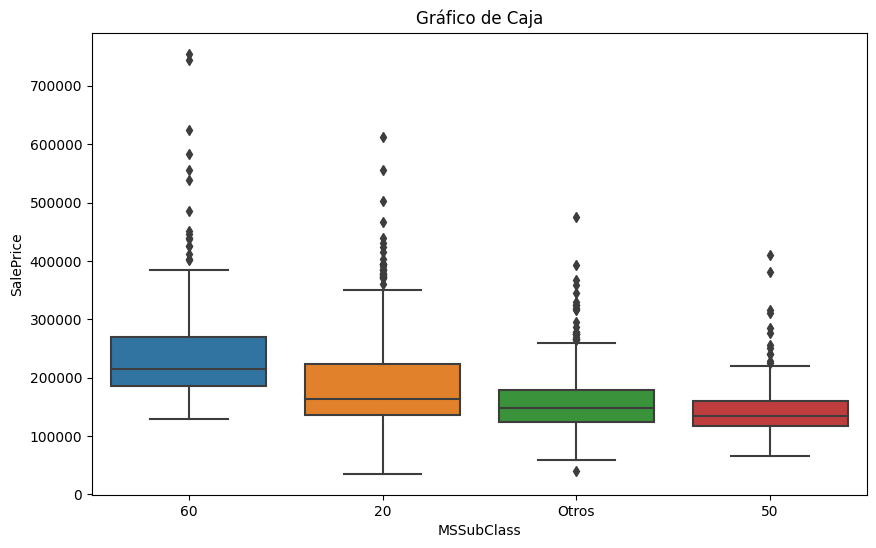

----------------------------------------------------------------------------------------------------
MSZoning


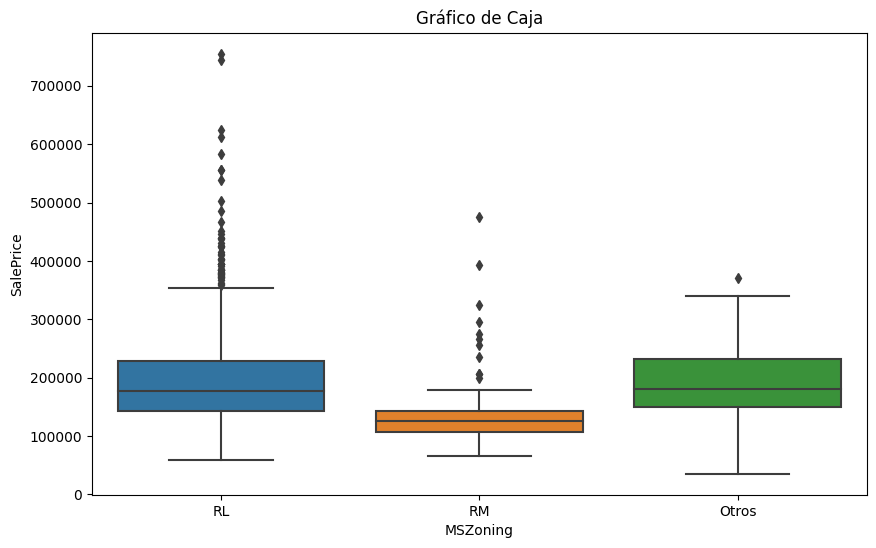

----------------------------------------------------------------------------------------------------
LotShape


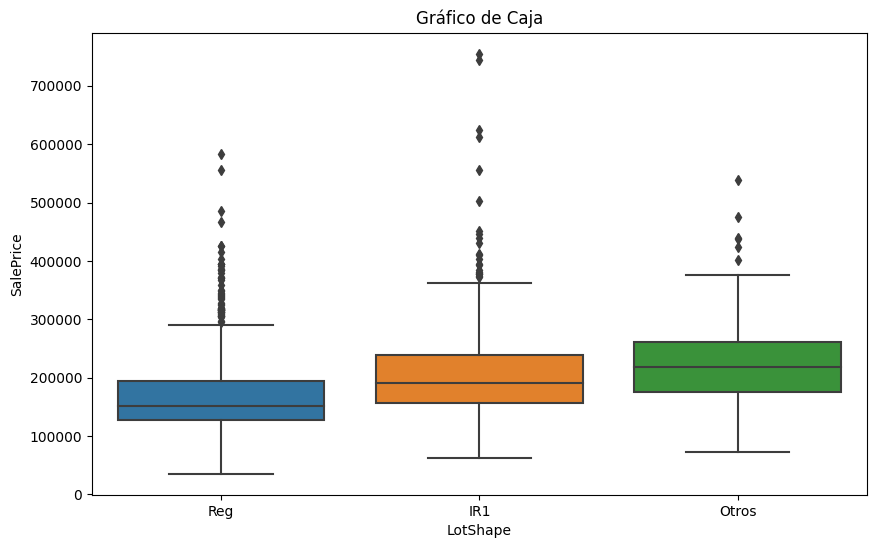

----------------------------------------------------------------------------------------------------
LotConfig


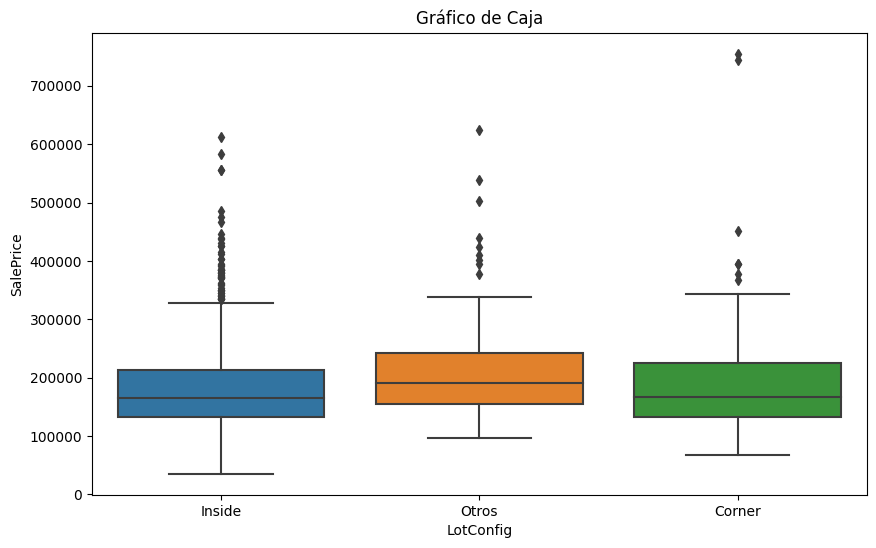

----------------------------------------------------------------------------------------------------
Neighborhood


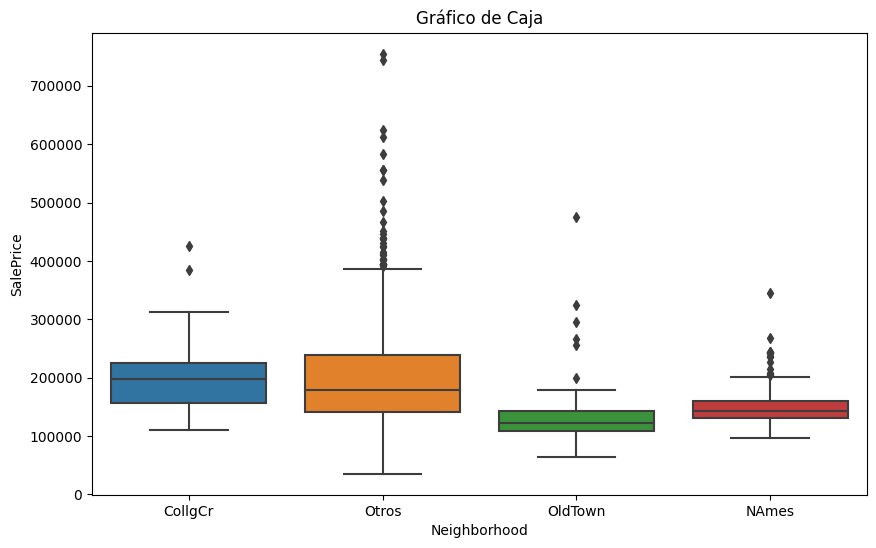

----------------------------------------------------------------------------------------------------
HouseStyle


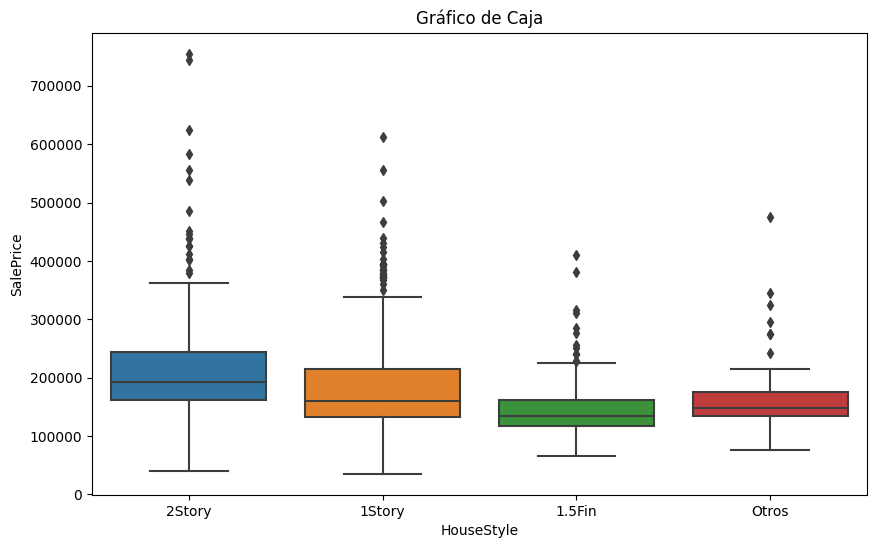

----------------------------------------------------------------------------------------------------
OverallQual


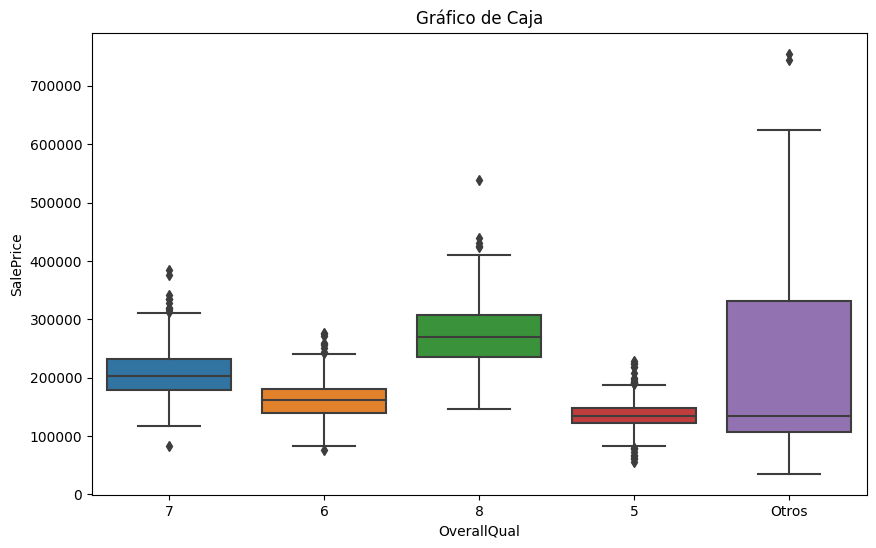

----------------------------------------------------------------------------------------------------
OverallCond


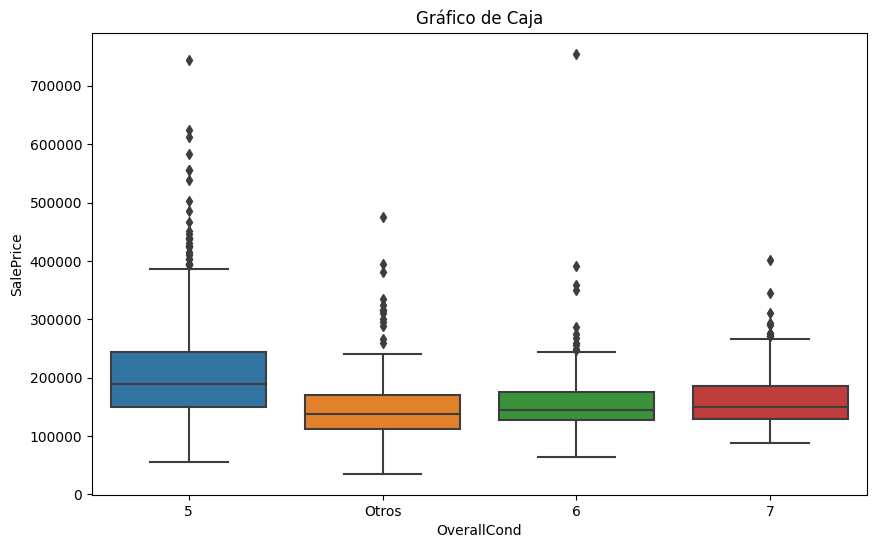

----------------------------------------------------------------------------------------------------
RoofStyle


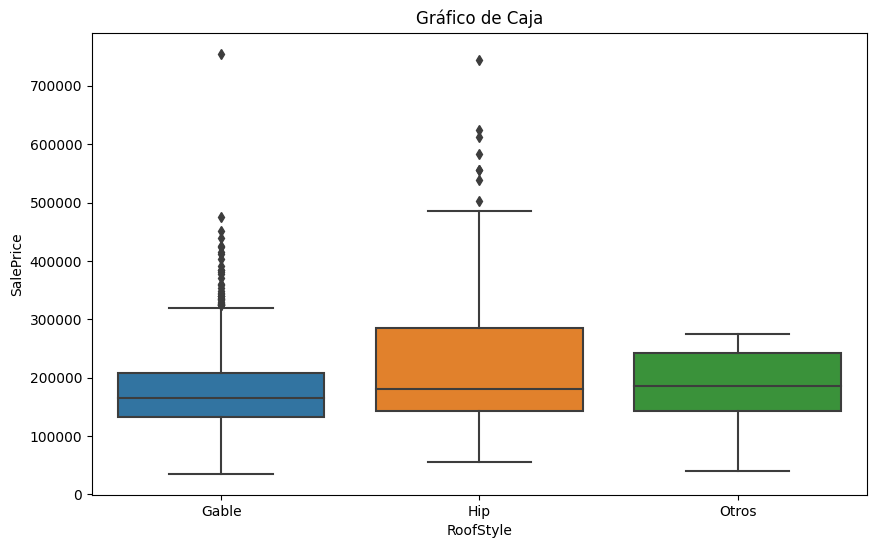

----------------------------------------------------------------------------------------------------
Exterior1st


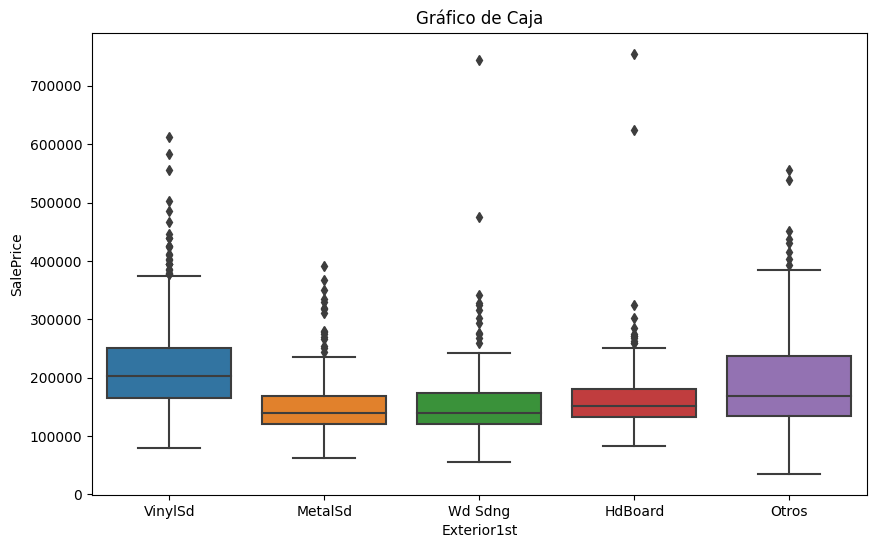

----------------------------------------------------------------------------------------------------
Exterior2nd


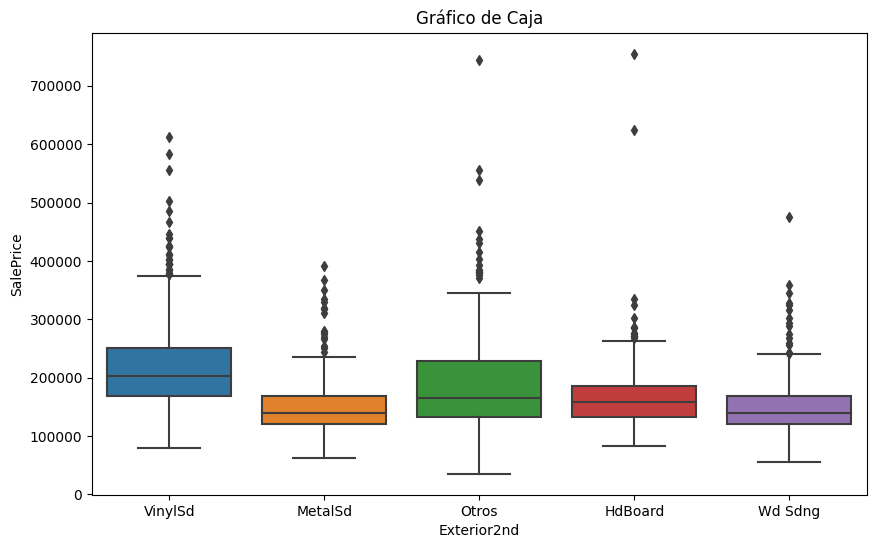

----------------------------------------------------------------------------------------------------
MasVnrType


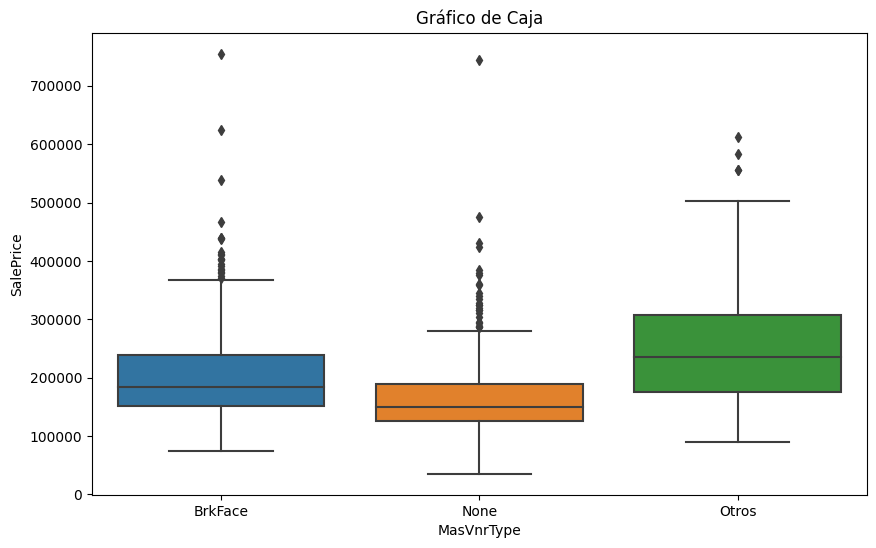

----------------------------------------------------------------------------------------------------
ExterQual


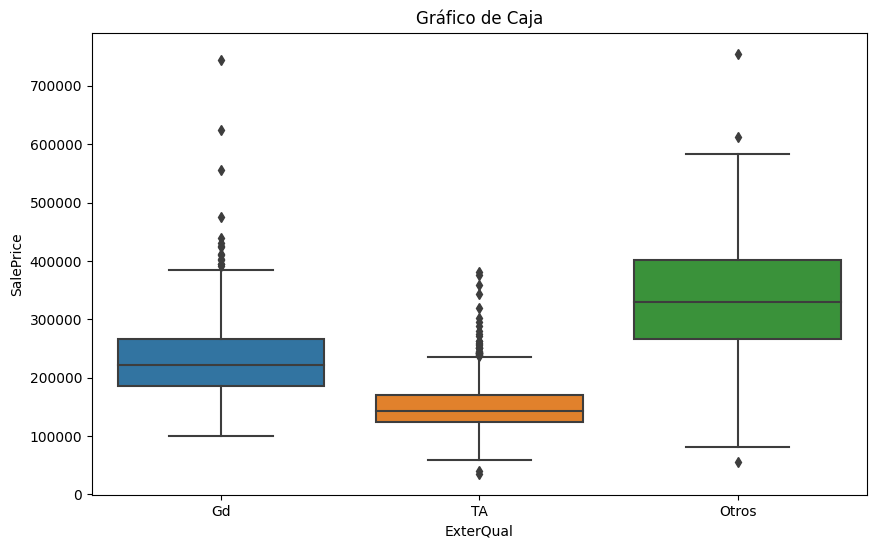

----------------------------------------------------------------------------------------------------
Foundation


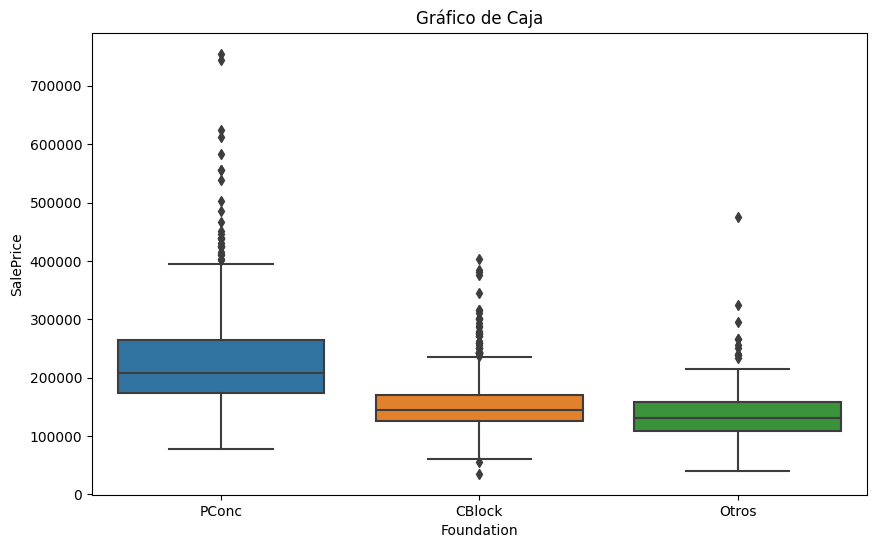

----------------------------------------------------------------------------------------------------
BsmtQual


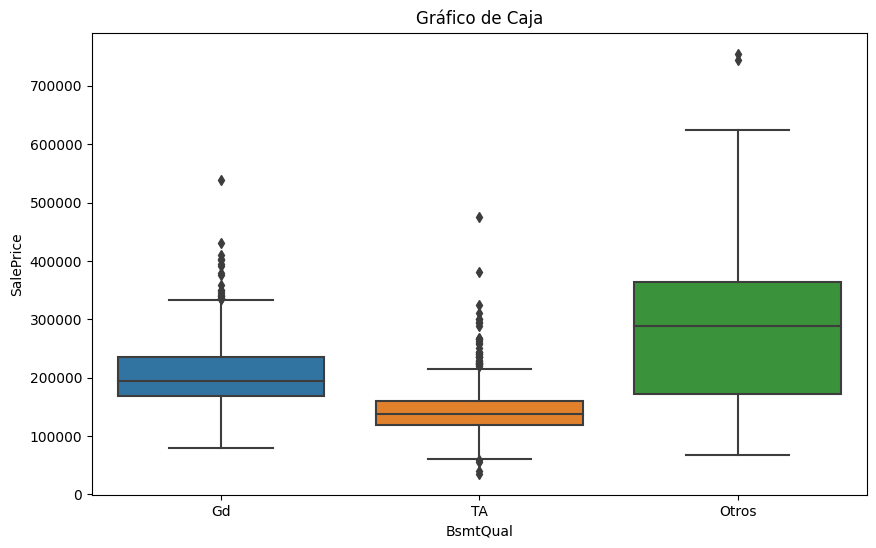

----------------------------------------------------------------------------------------------------
BsmtExposure


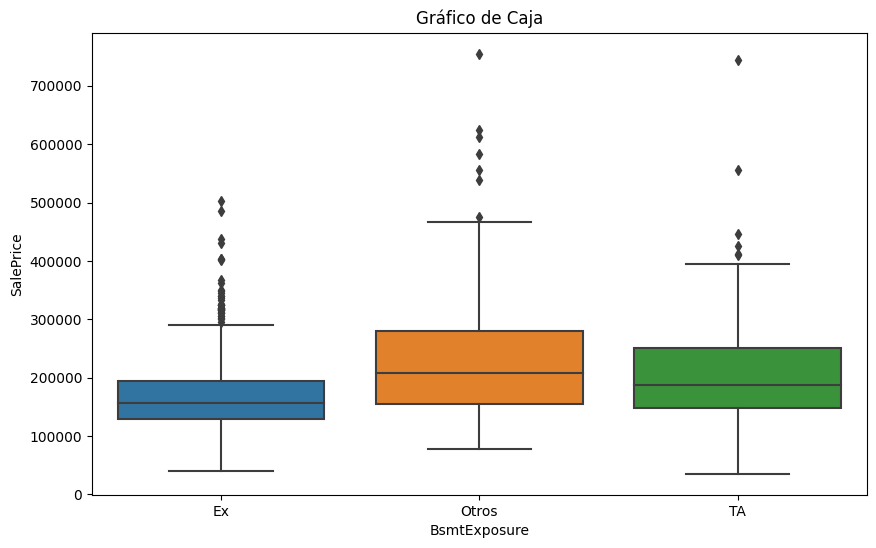

----------------------------------------------------------------------------------------------------
BsmtFinType1


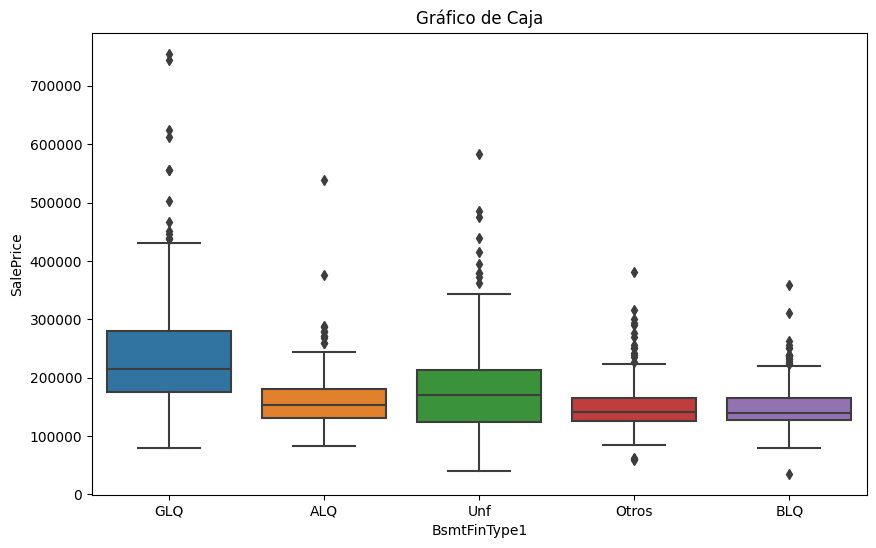

----------------------------------------------------------------------------------------------------
HeatingQC


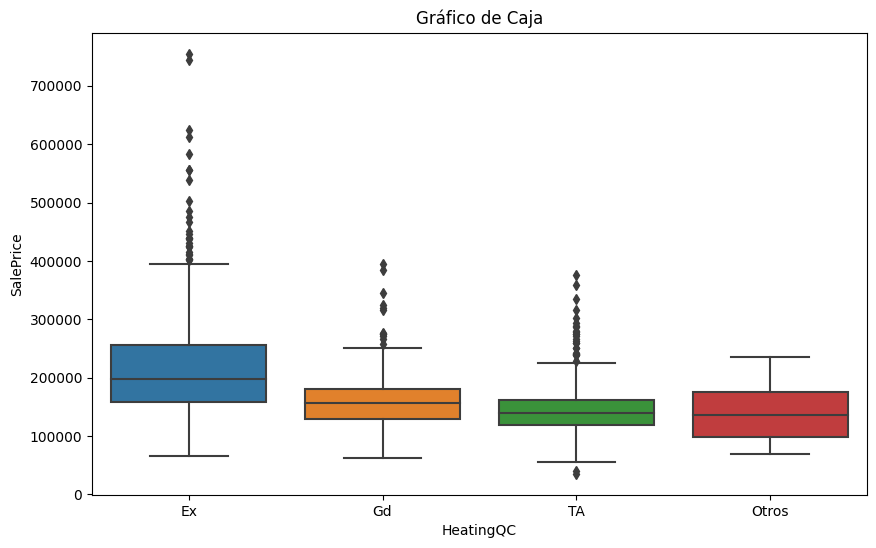

----------------------------------------------------------------------------------------------------
KitchenQual


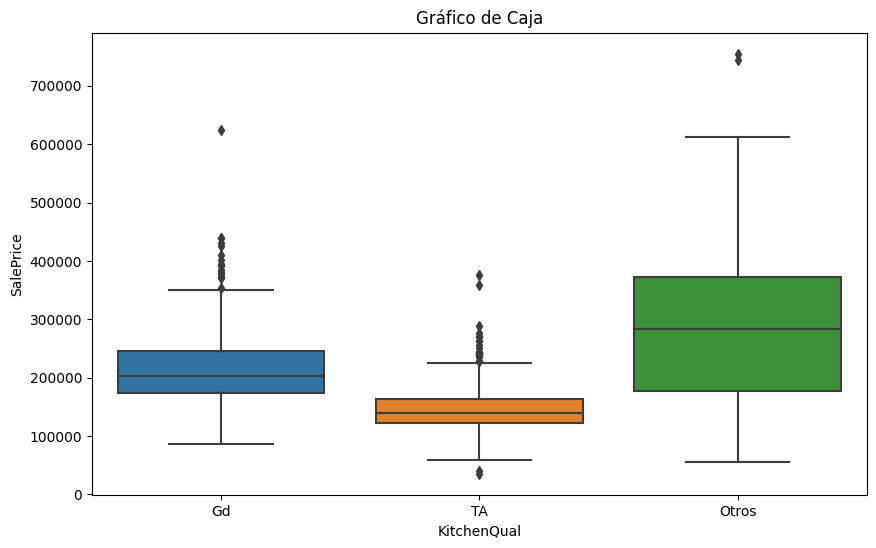

----------------------------------------------------------------------------------------------------
GarageType


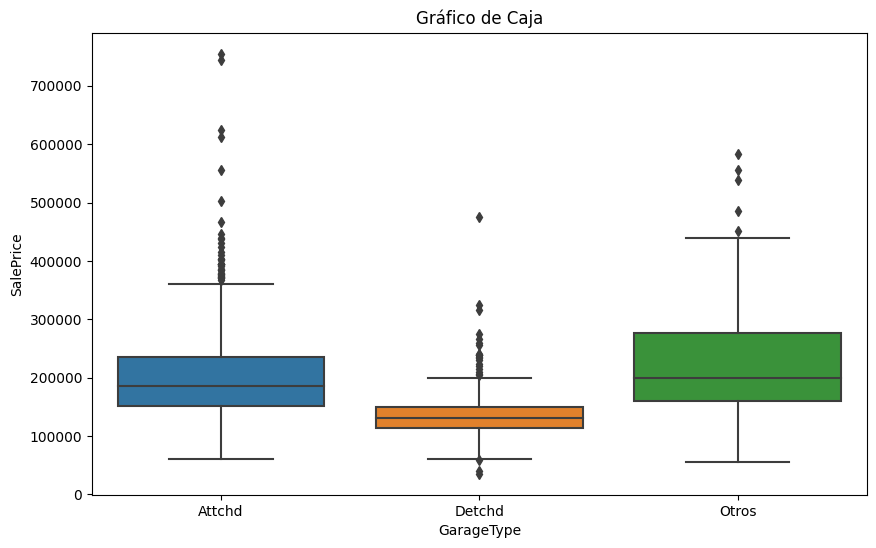

----------------------------------------------------------------------------------------------------
GarageFinish


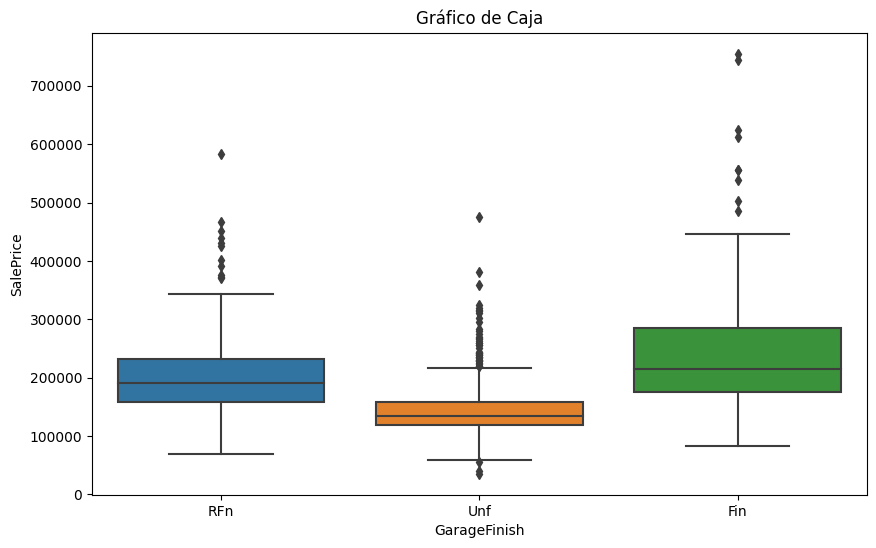

In [ ]:
# Se procede a revisar visualmente la relación entre cada variable independiente categórica y SalePrice
for col in variables_categoricas:
    print('-'*100)
    print(col)
    bi_boxplot (x =  col, y = col_y, data=datos)

Tras un exhaustivo análisis de los boxplots, hemos llegado a la conclusión de que todas las variables categóricas son capaces de diferenciar grupos y mostrar diferencias sustanciales en la distribución de la variable objetivo, "SalePrice." Dado este descubrimiento, hemos decidido mantener las 21 variables categóricas en nuestro conjunto de datos, ya que todas ellas parecen proporcionar información valiosa y relevante para nuestro análisis y la predicción de "SalePrice".

In [ ]:
len(variables_categoricas)

21

## Análisis de las variables númericas

Ahora, al iniciar el análisis de las variables numéricas, comenzamos por validar las columnas que contienen una gran cantidad de ceros. Esto nos permitirá tomar decisiones fundamentadas acerca de si deben ser eliminadas o no.

In [ ]:
# Se valida los nulos de cada columna para tomar decision de eliminar
df_cols_con_ceros = pd.DataFrame(columns= ['Columna', '% de ceros','Conteo'])
for regresor in variables_numericas:
    num_missing = (datos[regresor]==0).sum()
    pct_missing = round(np.mean(datos[regresor]==0)*100,2)
    df_cols_con_ceros = df_cols_con_ceros.append({'Columna':regresor,
                                        '% de ceros':pct_missing,
                                        'Conteo':round(num_missing,0)},
                                       ignore_index=True)

De esta manera, procedemos a eliminar las columnas que contienen más del 85% de ceros, lo que resulta en una reducción de nuestro conjunto de datos de 55 columnas a 47 columnas.

In [ ]:
# Se eliminan las columnas con mas del 85% de ceros, pasando de 55 cols a 47 cols
df_cols_con_ceros = df_cols_con_ceros[df_cols_con_ceros['% de ceros']>= 85]
df_cols_con_ceros

Columna  % de ceros Conteo
5      BsmtFinSF2      87.890   1176
10   LowQualFinSF      98.650   1320
13   BsmtHalfBath      94.020   1258
25  EnclosedPorch      86.320   1155
26      3SsnPorch      98.280   1315
27    ScreenPorch      91.330   1222
28       PoolArea      99.480   1331
29        MiscVal      96.490   1291

Procedemos a eliminar las columnas antes mencionadas.

In [ ]:
datos.drop(columns=df_cols_con_ceros['Columna'], inplace = True)

Después de llevar a cabo la limpieza, visualizamos el estado actual de nuestras variables numéricas mediante sus estadísticas descriptivas.

In [ ]:
# Encontrar variables numéricas
variables_numericas = datos.drop(columns=['Id','SalePrice']).select_dtypes(include=['int64','float64']).columns

In [ ]:
datos[variables_numericas].describe().T

count      mean       std      min      25%      50%  \
LotArea      1338.000 10706.294 10336.621 1300.000 7744.000 9600.000   
YearBuilt    1338.000  1973.029    29.564 1880.000 1956.000 1976.000   
YearRemodAdd 1338.000  1985.669    20.296 1950.000 1968.000 1994.500   
MasVnrArea   1338.000   110.360   185.605    0.000    0.000    0.000   
BsmtFinSF1   1338.000   464.235   458.792    0.000    0.000  413.000   
BsmtUnfSF    1338.000   582.495   439.951    0.000  248.000  489.000   
TotalBsmtSF  1338.000  1095.948   405.554  105.000  819.750 1021.500   
1stFlrSF     1338.000  1176.222   386.645  438.000  894.000 1098.000   
2ndFlrSF     1338.000   357.141   440.325    0.000    0.000    0.000   
GrLivArea    1338.000  1537.585   520.580  438.000 1160.000 1480.000   
BsmtFullBath 1338.000     0.439     0.516    0.000    0.000    0.000   
FullBath     1338.000     1.575     0.548    0.000    1.000    2.000   
HalfBath     1338.000     0.403     0.504    0.000    0.000    0.000   
BedroomAbvGr 1338.000     2.865     0.777    0.000    2.000    3.000   
KitchenAbvGr 1338.000     1.030     0.175    1.000    1.000    1.000   
TotRmsAbvGrd 1338.000     6.550     1.585    3.000    5.000    6.000   
Fireplaces   1338.000     0.649     0.645    0.000    0.000    1.000   
GarageYrBlt  1338.000  1978.596    24.774 1900.000 1962.000 1980.000   
GarageCars   1338.000     1.871     0.634    1.000    1.000    2.000   
GarageArea   1338.000   501.450   186.762  160.000  377.500  484.000   
WoodDeckSF   1338.000    99.385   127.537    0.000    0.000    6.000   
OpenPorchSF  1338.000    47.783    65.363    0.000    0.000   28.000   
YrSold       1338.000  2007.806     1.331 2006.000 2007.000 2008.000   

                   75%        max  
LotArea      11760.750 215245.000  
YearBuilt     2001.000   2010.000  
YearRemodAdd  2004.000   2010.000  
MasVnrArea     174.000   1600.000  
BsmtFinSF1     733.000   5644.000  
BsmtUnfSF      815.750   2336.000  
TotalBsmtSF   1324.000   6110.000  
1stFlrSF      1414.000   4692.000  
2ndFlrSF       740.500   2065.000  
GrLivArea     1791.500   5642.000  
BsmtFullBath     1.000      2.000  
FullBath         2.000      3.000  
HalfBath         1.000      2.000  
BedroomAbvGr     3.000      6.000  
KitchenAbvGr     1.000      3.000  
TotRmsAbvGrd     7.000     12.000  
Fireplaces       1.000      3.000  
GarageYrBlt   2002.000   2010.000  
GarageCars       2.000      4.000  
GarageArea     583.000   1418.000  
WoodDeckSF     174.500    857.000  
OpenPorchSF     70.000    547.000  
YrSold        2009.000   2010.000

Dado que la variable "ID" no aporta información relevante, procedemos a eliminarla de nuestro conjunto de datos.

In [ ]:
datos.drop(columns=['Id'], inplace=True)

## Análisis de linealidad de las variables

Para evaluar la linealidad de nuestras variables, implementamos tres enfoques distintos:

1. **Correlación de Pearson:** La correlación de Pearson se emplea para cuantificar la relación lineal entre dos variables numéricas. Su valor oscila entre -1 y 1, donde 1 indica una correlación positiva perfecta, -1 indica una correlación negativa perfecta, y 0 señala la inexistencia de correlación. Valores cercanos a 1 o -1 denotan una relación lineal más sólida, mientras que valores próximos a 0 sugieren una correlación tenue o la ausencia de una relación lineal.

2. **Modelos de regresión lineal:** Los modelos de regresión, como la regresión lineal, se utilizan para modelar la relación entre una variable dependiente y una o varias variables independientes. Al ajustar estos modelos, evaluamos la linealidad al observar si la relación entre las variables se ajusta adecuadamente a una línea recta en el caso de la regresión lineal. Si la relación no se ajusta de manera apropiada, esto puede indicar la existencia de no linealidad en la relación. Hicimos uso de las métricas R2 y MSE para evaluar los modelos, aunque tomamos nuestras decisiones principalmente en función del valor de R2, ya que nos resultó más accesible su interpretación.

3. **Gráficos de dispersión:** Luego de aplicar un filtro a las variables mediante la correlación y los modelos de regresión lineal, específicamente, al evaluar el R^2, procedimos a analizar los gráficos de dispersión de las variables restantes. Este filtro previo, de R^2 y de coeficiente de correlación, nos permitió evitar la revisión de los gráficos de dispersión de todas las variables numéricas.

Es importante destacar que exploramos otros métodos para analizar la linealidad, como el coeficiente de correlación de Spearman y los gráficos de residuos. Sin embargo, descartamos el coeficiente de correlación de Spearman debido a que, después de una investigación más profunda, constatamos que evalúa la fuerza y dirección de la asociación entre las variables en términos de su orden, y no resulta muy útil para la evaluación de relaciones lineales o no lineales.

Además, el método de los gráficos de residuos no se incluyó en la versión final de este cuaderno, ya que el análisis con R2, el coeficiente de correlación de Pearson y la revisión de los gráficos de dispersión resultaron ser los tres métodos decisivos y más útiles para la selección de las variables que utilizamos para nuestros splines. Y quedamos satisfechos con los resultados que estos enfoques nos proporcionaron.

Por estas mismas razones, optamos por no utilizar más métodos de evaluación de la linealidad, como los gráficos Q-Q y la Prueba de Rainbow.

### Correlación de Pearson

In [ ]:
correlaciones = datos.corr()

# Obtener la correlación de la variable objetivo con todas las variables regresoras
df_correlacion_pearson = pd.DataFrame(correlaciones[col_y]).reset_index().rename(columns={'index':'Columna',
                                                                                'SalePrice':'Pearson'},)

### Modelos de Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
modelo = LinearRegression()
df_linealidad = pd.DataFrame(columns= ['Columna', 'MSE', 'R2'])
for col in variables_numericas:
  # Entrenar el modelo usando el conjunto de entrenamiento
  modelo.fit(np.array(datos[col]).reshape(-1, 1), datos[col_y])
  # Realizar predicciones en el conjunto de prueba
  predicciones = modelo.predict(np.array(datos[col]).reshape(-1, 1))
  error_cuadratico_medio = mean_squared_error(datos[col_y], predicciones)
  coeficiente_determinacion = r2_score(datos[col_y], predicciones)
  df_linealidad = df_linealidad.append({'Columna':col,
                                        'MSE':error_cuadratico_medio,
                                        'R2':coeficiente_determinacion},
                                        ignore_index=True)

Hemos creado gráficos de regresión lineal con el propósito de visualizar la linealidad de las relaciones entre las variables y analizar la distribución de los datos. Estos gráficos nos ayudan a determinar si existe una relación lineal adecuada entre las variables o si existen patrones no lineales en los datos.

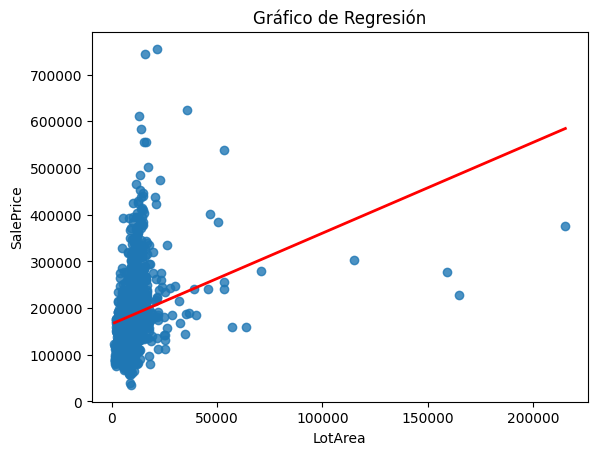

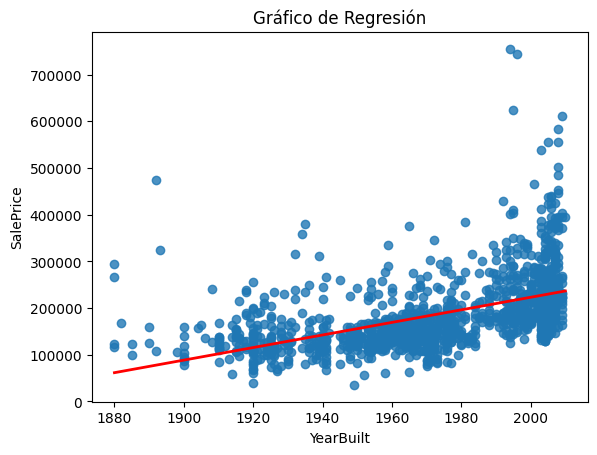

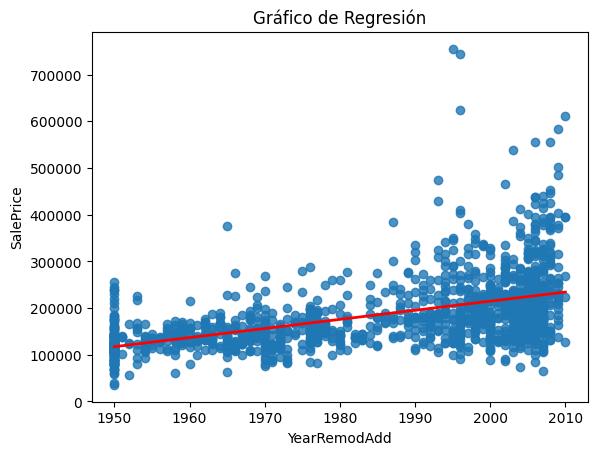

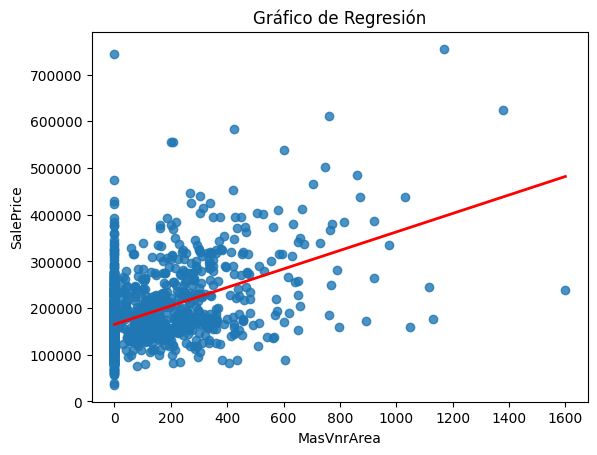

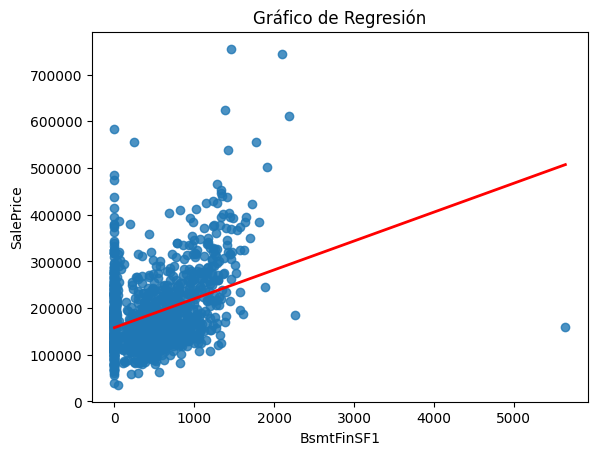

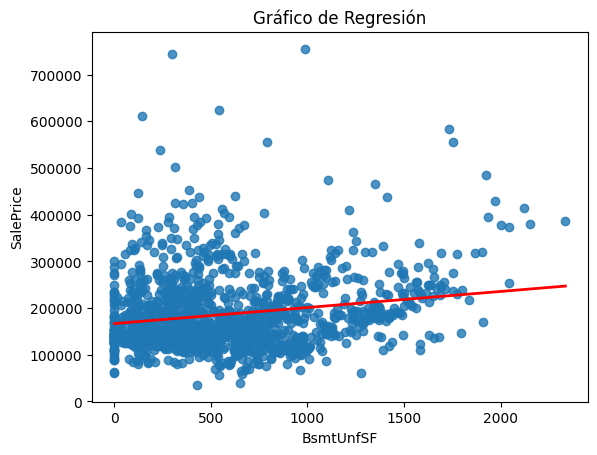

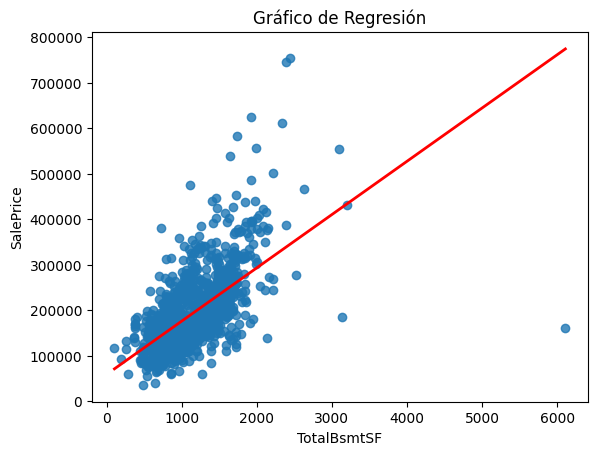

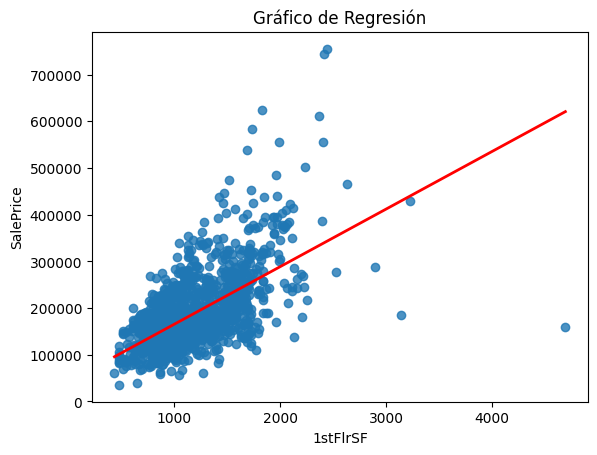

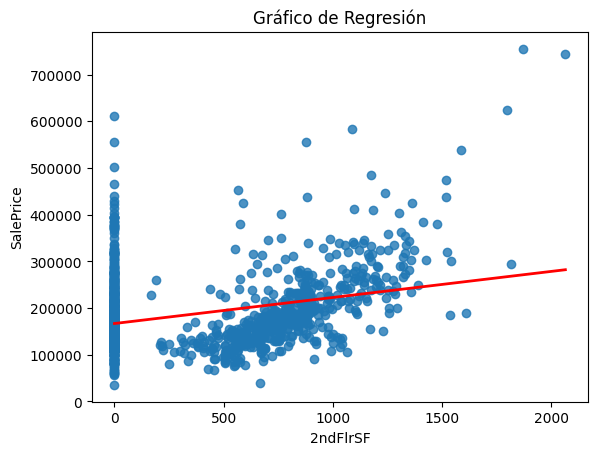

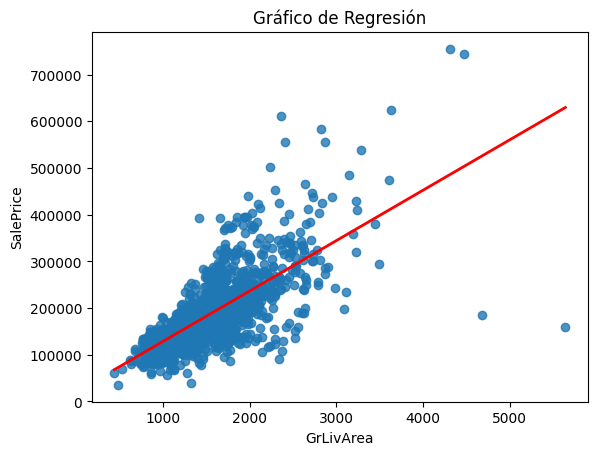

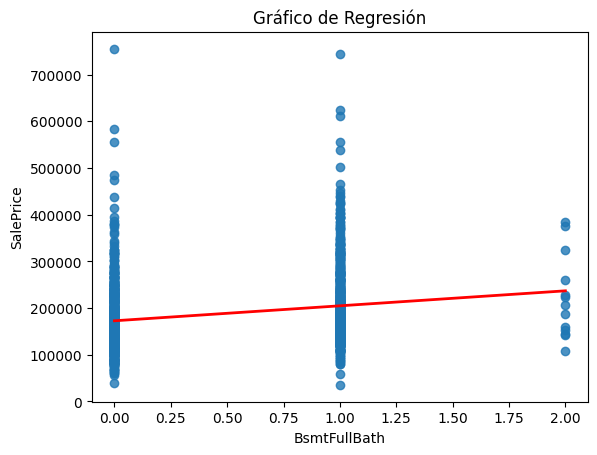

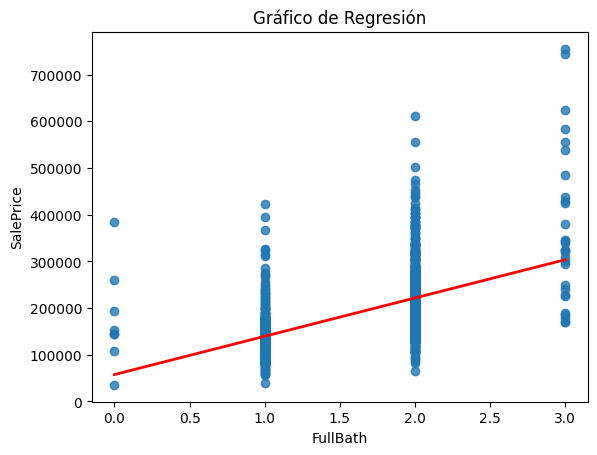

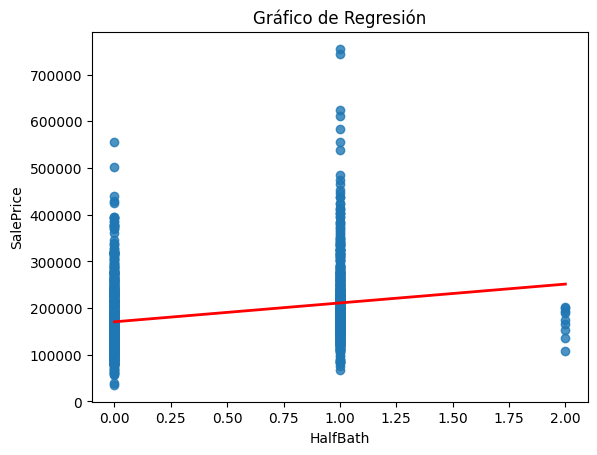

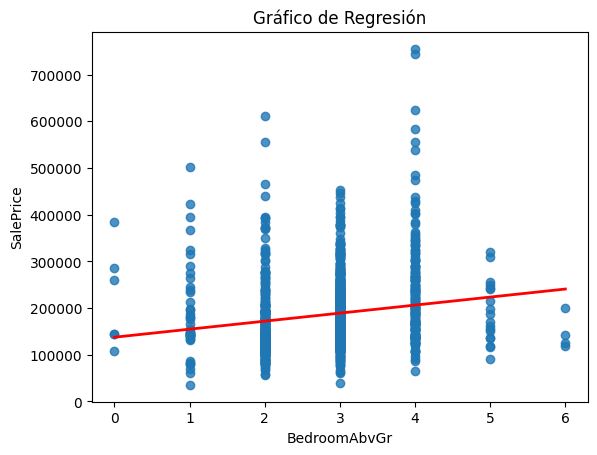

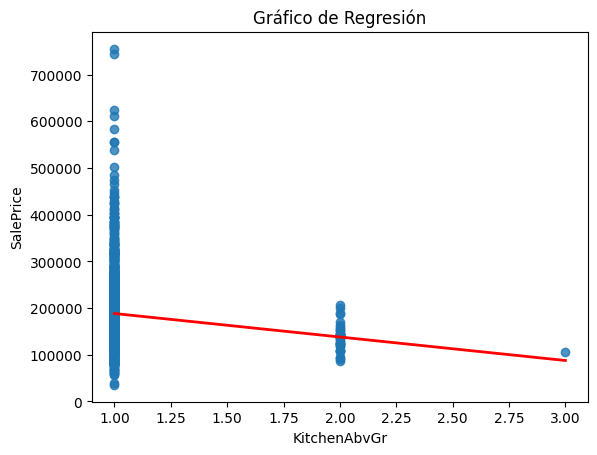

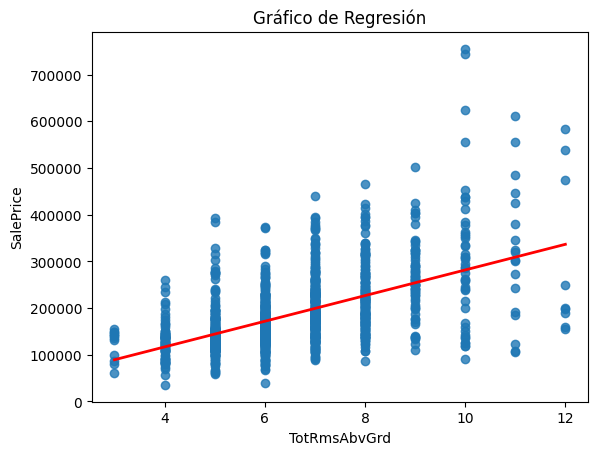

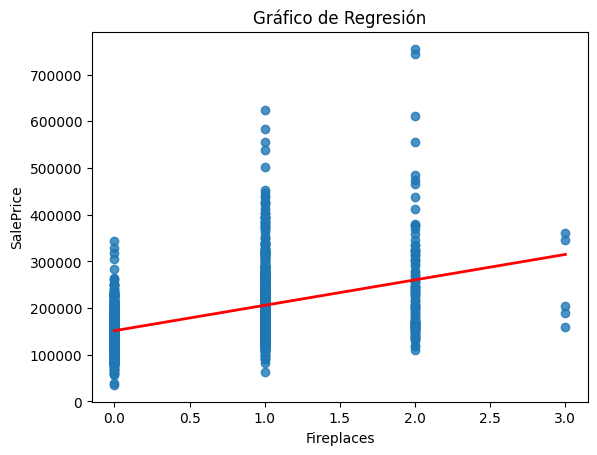

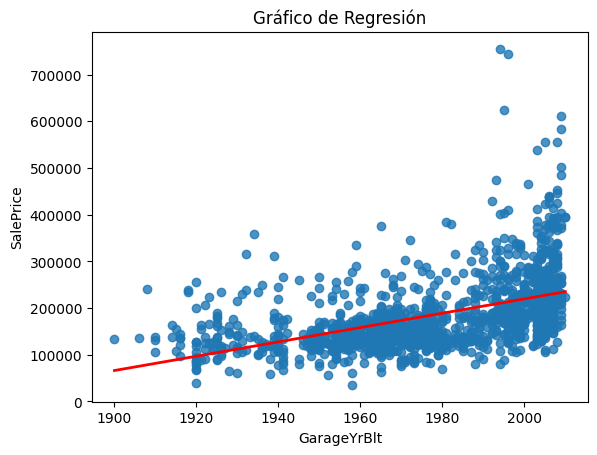

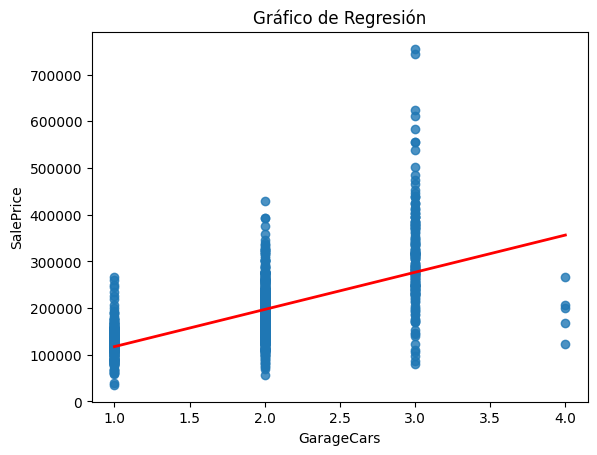

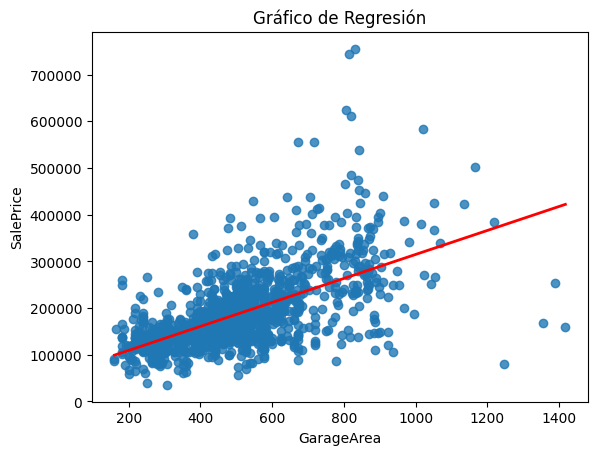

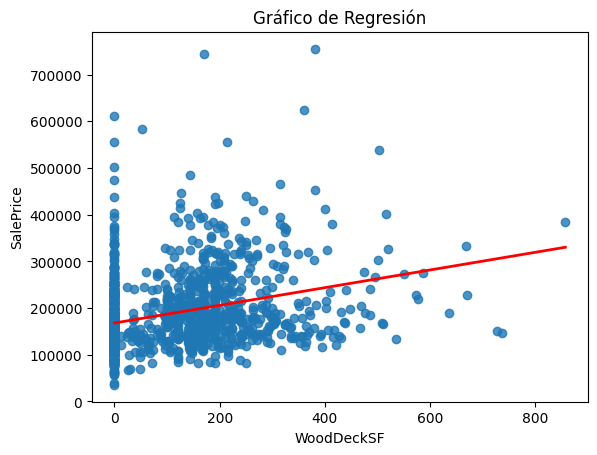

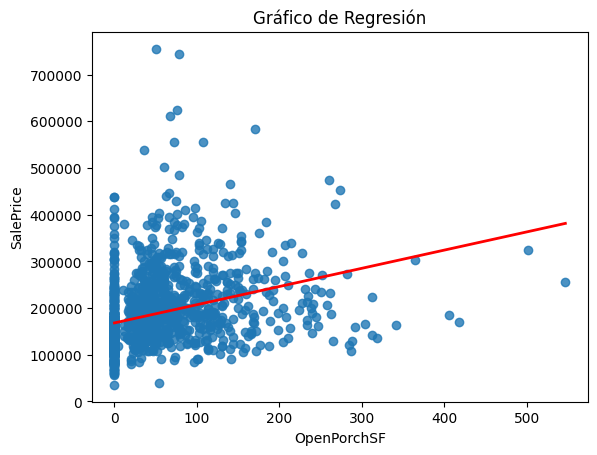

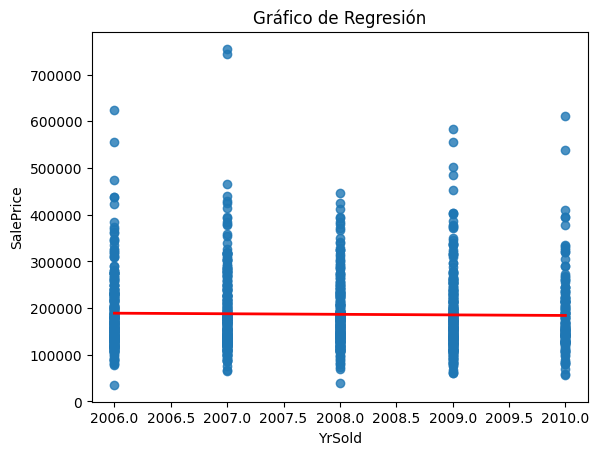

In [ ]:
for regresor in df_linealidad['Columna'] :
  sns.regplot(x=datos[regresor], y=datos[col_y], ci=None, line_kws={'color': 'red', 'linewidth': 2})
  plt.xlabel(regresor)
  plt.ylabel(col_y)
  plt.title('Gráfico de Regresión')
  plt.show()

### Resultados de linealidad de spline


Después de llevar a cabo los tres métodos para analizar la linealidad y revisar sus resultados, estamos listos para determinar cuáles de las variables con relaciones no lineales mantendremos para realizar el ajuste de splines.


In [ ]:
df_resultados_linealidad = df_correlacion_pearson.merge(df_linealidad, on='Columna')

Como es ampliamente reconocido, un valor de $R^2$ bajo sugiere una relación débil o no lineal entre las variables. En consecuencia, nuestro objetivo es identificar aquellas variables que exhiben un coeficiente $R^2$ inferior al 20%. Cabe destacar que, al aplicar este filtro, también estamos examinando que los coeficientes de correlación de Pearson de nuestras variables se encuentren en el rango de -0.5 a 0.5, ya que este intervalo también indica la presencia de relaciones no lineales.

In [ ]:
df_resultados_linealidad[df_resultados_linealidad['R2']<=0.2].sort_values('R2')

Columna  Pearson            MSE    R2
22        YrSold   -0.020 6220138472.538 0.000
14  KitchenAbvGr   -0.111 6145505763.469 0.012
13  BedroomAbvGr    0.169 6044454428.549 0.029
5      BsmtUnfSF    0.192 5994088800.957 0.037
10  BsmtFullBath    0.210 5949115666.925 0.044
0        LotArea    0.255 5818877063.737 0.065
12      HalfBath    0.258 5807968695.988 0.067
20    WoodDeckSF    0.306 5640133696.238 0.094
8       2ndFlrSF    0.311 5619500299.261 0.097
21   OpenPorchSF    0.323 5574389778.826 0.104
4     BsmtFinSF1    0.360 5417722004.628 0.129
16    Fireplaces    0.445 4988075624.883 0.198

Veamos en detalle los gráficos de dispersión de las variables anteriores para definir si nos son utiles para nuestro spline.

In [ ]:
# Columnas con R^2 inferior al 20%
# YrSold, KitchenAbvGr, BedroomAbvGr, BsmtUnfSF, BsmtFullBath, LotArea, HalfBath, WoodDeckSF, 2ndFlrSF, OpenPorchSF, BsmtFinSF1, Fireplaces

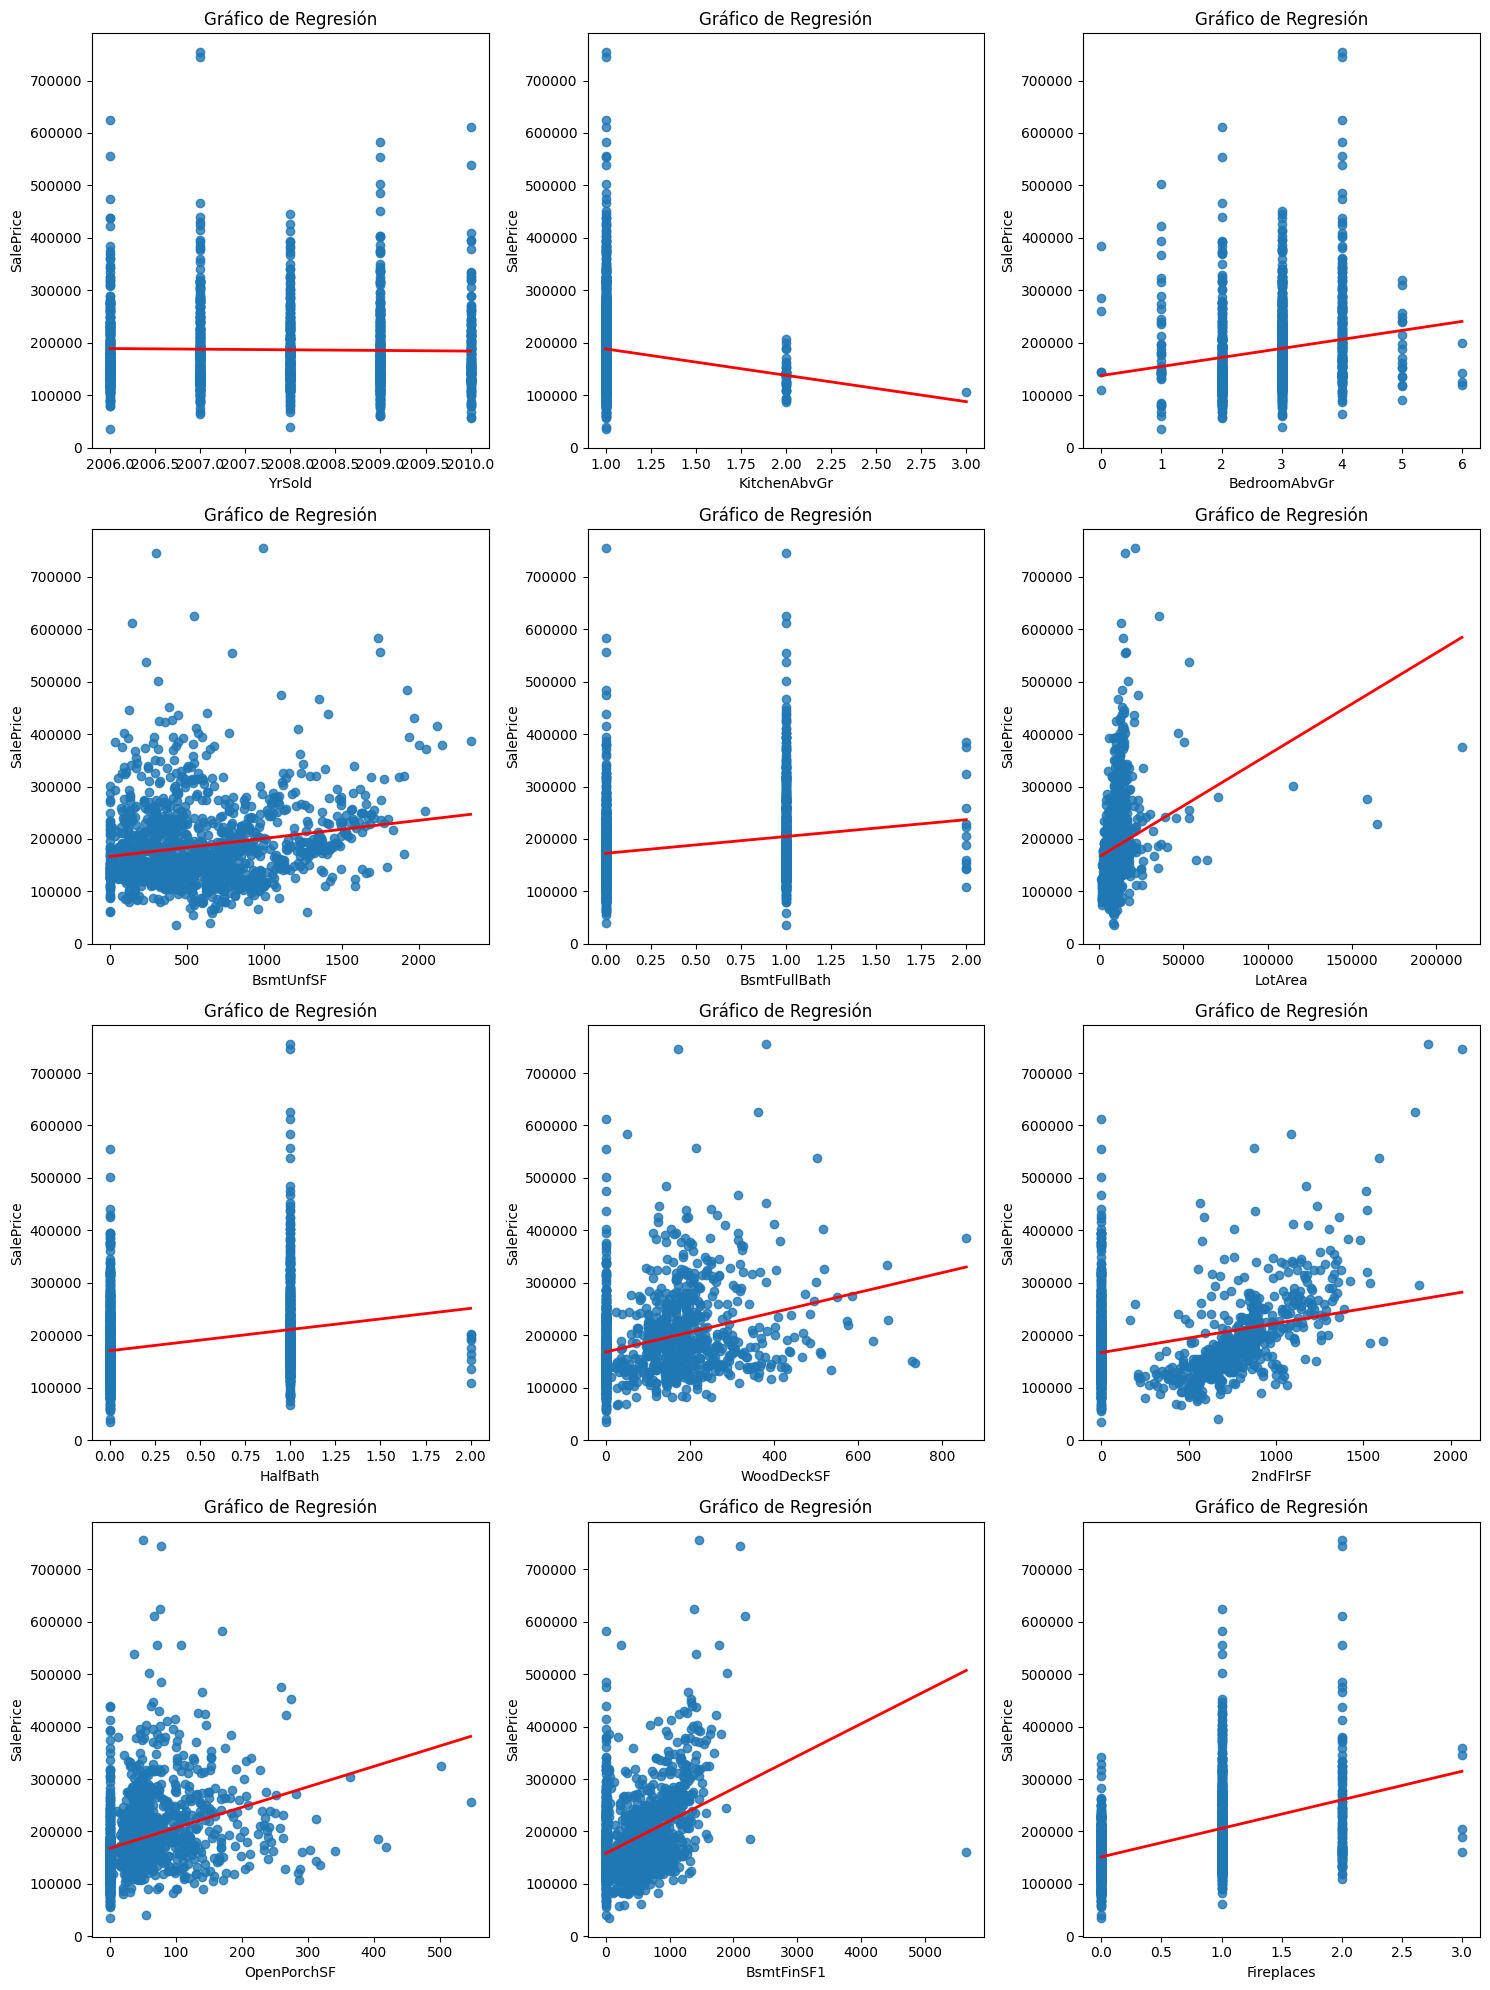

In [ ]:
# Lista de columnas que deseas incluir en los gráficos de regresión
columnas = ['YrSold', 'KitchenAbvGr', 'BedroomAbvGr', 'BsmtUnfSF', 'BsmtFullBath', 'LotArea', 'HalfBath',
            'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtFinSF1', 'Fireplaces']

# Configuración de los subplots en filas de 3 columnas
num_columnas = len(columnas)
num_filas = (num_columnas - 1) // 3 + 1  # Calcula el número de filas necesarias
fig, axes = plt.subplots(num_filas, 3, figsize=(15, 5 * num_filas))  # Ajusta el tamaño de la figura según tus necesidades

# Itera a través de las columnas especificadas y crea los gráficos de regresión
for i, regresor in enumerate(columnas):
    fila = i // 3
    columna = i % 3
    ax = axes[fila, columna]
    sns.regplot(x=datos[regresor], y=datos[col_y], ci=None, line_kws={'color': 'red', 'linewidth': 2}, ax=ax)
    ax.set_xlabel(regresor)
    ax.set_ylabel(col_y)
    ax.set_title('Gráfico de Regresión')

# Elimina los subplots vacíos si es necesario
for i in range(num_columnas, num_filas * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

Se puede notar que en nuestro conjunto de datos, varias columnas muestran un número significativo de valores cero, como BsmtUnfSF, LotArea, WoodDeckSF, 2ndFlrSF, OpenPorchSF y BsmtFinSF1. Dada esta característica, consideramos que la aplicación de la técnica de splines a estas variables no sería apropiada. Al utilizar splines, estaríamos generando una curva suave que podría no reflejar adecuadamente la verdadera distribución de los datos. Los splines suelen funcionar de manera más efectiva cuando existe una distribución más uniforme de los datos.

Comenzar desde el valor 1, por ejemplo, resultaría en una pérdida sustancial de información. Además, basar análisis y conclusiones en una parte limitada de la población no se considera apropiado.

Por otro lado, se observa que las columnas YrSold, KitchenAbvGr, BedroomAbvGr, BsmtFullBath, HalfBath y Fireplaces representan variables numéricas discretas. En este caso, tampoco sería adecuado aplicar la técnica de splines a estas variables. Los splines funcionan mejor con variables continuas, ya que asumen una relación suave entre los datos. Aplicar splines a variables discretas podría introducir complejidad innecesaria y dificultar la interpretación de los resultados.

Como hemos observado previamente, las variables con un $R^2$ inferior al 20% no resultan ser particularmente útiles para el análisis de splines. Por tanto, ahora centrémonos en identificar las variables con un $R^2$ superior al 20%. Esta selección se ha respaldado y validado mediante las correlaciones de Pearson. Los resultados de esta elección se muestran en el siguiente dataframe, donde las variables se presentan en orden ascendente según sus valores de $R^2$.

In [ ]:
# Se Eliminan las variables con mas de un 20% en R^2 y contrastando o validando con correlaciones de Spearman y Pearson
df_resultados_linealidad = df_resultados_linealidad[df_resultados_linealidad['R2']>=0.2]

In [ ]:
df_resultados_linealidad.sort_values('R2')

Columna  Pearson            MSE    R2
3     MasVnrArea    0.466 4872528918.846 0.217
17   GarageYrBlt    0.482 4778669479.368 0.232
2   YearRemodAdd    0.501 4658110990.742 0.251
1      YearBuilt    0.504 4640200707.415 0.254
15  TotRmsAbvGrd    0.552 4327878602.239 0.305
11      FullBath    0.569 4205845728.746 0.324
6    TotalBsmtSF    0.602 3967278041.239 0.362
7       1stFlrSF    0.605 3947211572.521 0.366
19    GarageArea    0.608 3925932071.071 0.369
18    GarageCars    0.640 3672676716.804 0.410
9      GrLivArea    0.712 3070763146.005 0.507

Como se aprecia en el dataframe, las cinco variables con las relaciones no lineales más significativas son: MasVnrArea, GarageYrBlt, YearRemodAdd, YearBuilt y TotRmsAbvGrd.

# Modelado con Spline

Como se mencionó anteriormente, identificamos cinco variables no lineales: MasVnrArea, GarageYrBlt, YearRemodAdd, YearBuilt y TotRmsAbvGrd. Sin embargo, surge la pregunta de cuál de ellas es la más adecuada para aplicar una transformación spline. Para responder a esta interrogante, procederemos a analizar nuevamente estas variables en relación al precio objetivo.

In [ ]:
y = datos['SalePrice']

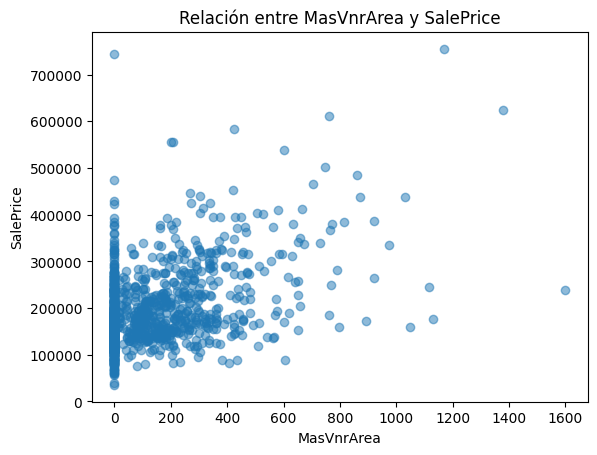

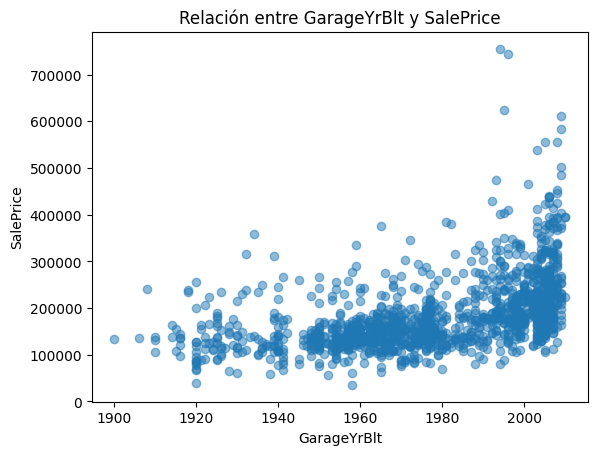

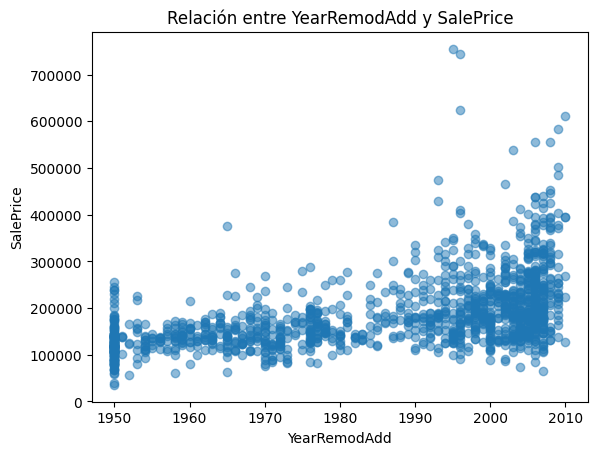

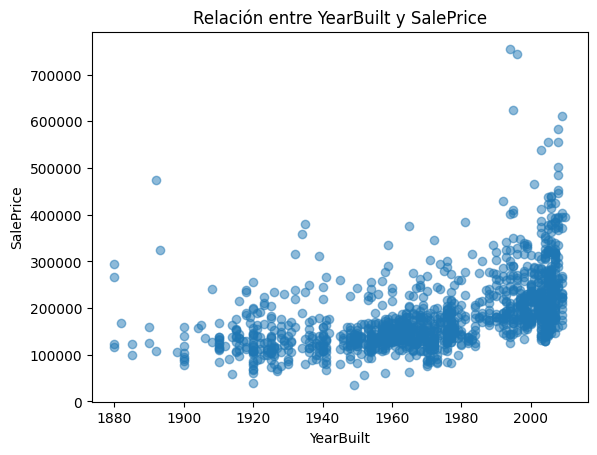

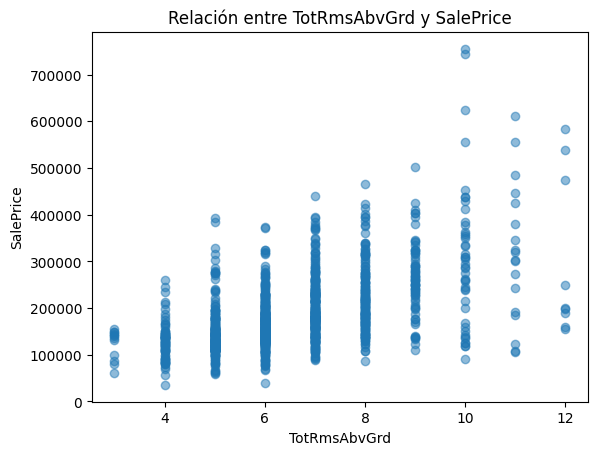

In [ ]:
columns = ['MasVnrArea', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd']
for col in columns:
  plt.scatter(datos[col],y, alpha=0.5)
  plt.title(f'Relación entre {datos[col].name} y {y.name}')
  plt.xlabel(datos[col].name)
  plt.ylabel(y.name)
  plt.show()

A partir de esta observación, se destacan dos puntos importantes. En primer lugar, se nota que la variable TotRmsAbvGrd es categórica, lo que la excluye como candidata para aplicarle una transformación spline, ya que no es apropiada para este tipo de variable. En segundo lugar, se advierte que las variables MasVnrArea y YearRemodAdd contienen una cantidad significativa de valores iguales a cero, lo que podría afectar negativamente la aplicación de la transformación spline en estas variables.

Con base en este análisis, se procederá a examinar la relación entre GarageYrBlt y YearBuilt para determinar finalmente cuál de ellas será la variable seleccionada para la transformación spline.

### GarageYrBlt

In [ ]:
# Ajustar modelos de regresión polinomial de grado 1 a 10
orders = range(1, 10)
rmse = {}
r2 = {}
rmse_cv = []
r2_cv = []
for i in orders:
    #
    poly = PolynomialFeatures(degree=i)
    X_poly_train = poly.fit_transform(np.array(datos['GarageYrBlt']).reshape(-1,1))
    #
    model = LinearRegression()
    scores = cross_validate(model, X_poly_train, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])
    rmse_val = scores['test_neg_root_mean_squared_error'] * -1
    r2_val = scores['test_r2']
    #
    rmse[i] = np.mean(rmse_val)
    r2[i] = np.mean(r2_val)
    rmse_cv.append(rmse_val)
    r2_cv.append(r2_val)

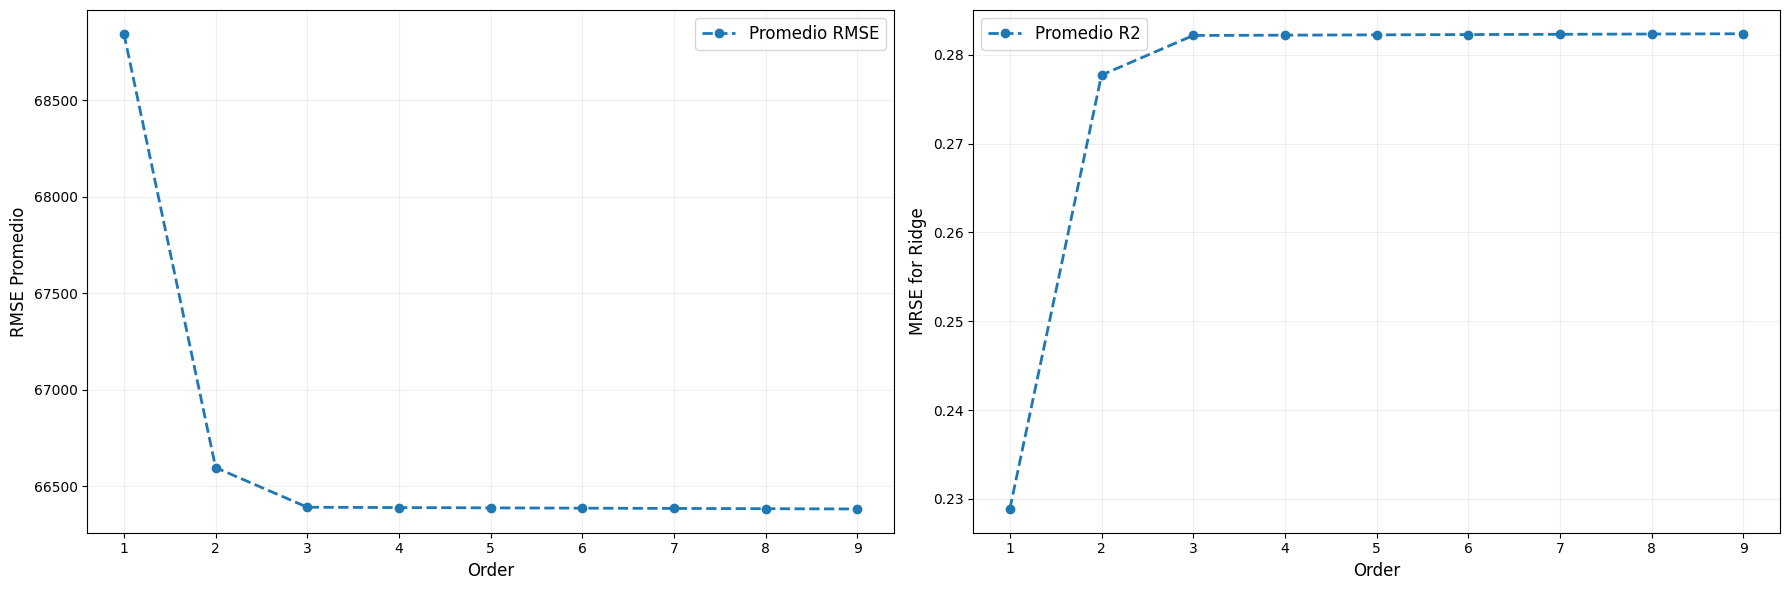

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plotting RMSE
axes[0].plot(orders, list(rmse.values()), '--o', label='Promedio RMSE', linewidth=2)
axes[0].set_xlabel("Order", fontsize=12)
axes[0].set_ylabel("RMSE Promedio", fontsize=12)
axes[0].grid(alpha=0.2)
axes[0].legend(fontsize=12)
# Plotting R2
axes[1].plot(orders, list(r2.values()), '--o', label='Promedio R2', linewidth=2)
axes[1].set_xlabel("Order", fontsize=12)
axes[1].set_ylabel("MRSE for Ridge", fontsize=12)
axes[1].grid(alpha=0.2)
axes[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

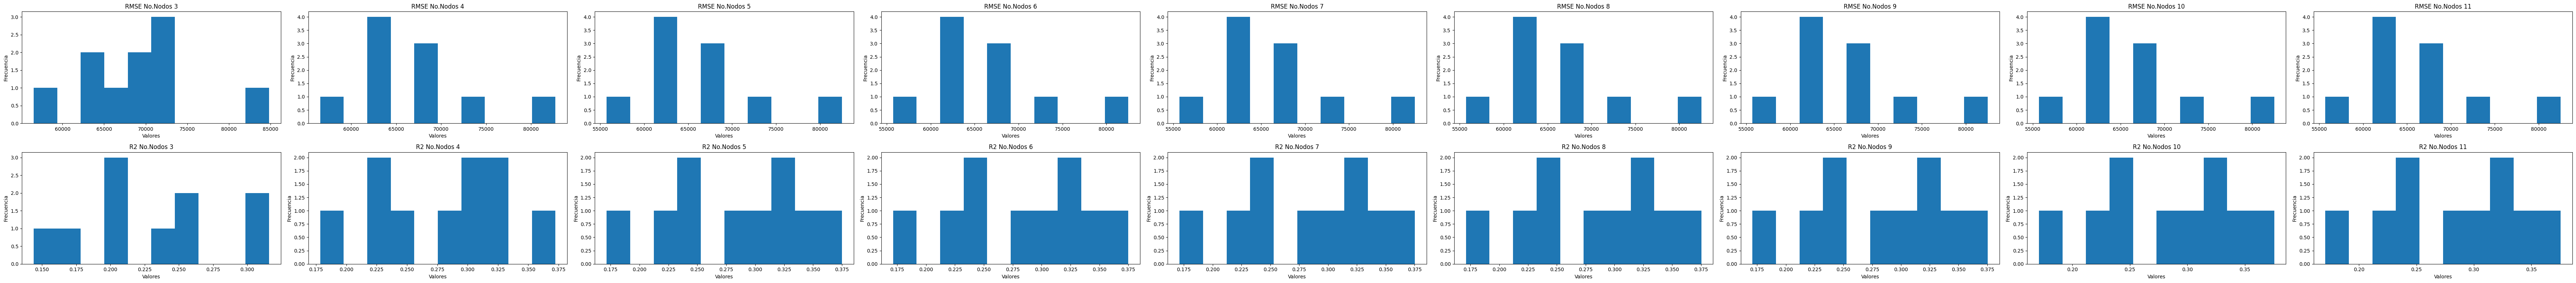

In [ ]:
# Definir el número de columnas y filas para los subplots
num_rows = 2
num_cols = len(r2_cv)
# Crear una figura con el tamaño deseado
plt.figure(figsize=(8*9, 8))
# Iteramos para cada caso
for i in range(num_cols):
    # Crear el primer subplot para RMSE en la fila superior
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(rmse_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'RMSE No.Nodos {i + 3}')
    # Crear el segundo subplot para R2 en la fila inferior
    plt.subplot(num_rows, num_cols, num_cols + i + 1)
    plt.hist(r2_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'R2 No.Nodos {i + 3}')
# Ajustar el espaciado entre subplots y mostrar la figura
plt.tight_layout()
plt.show()

(Al darle click en la imagen se amplia)

Para la variable GarageYrBlt, el análisis indica que el mejor grado de polinomio para la transformación spline es 3. Esto se respalda con la observación de que los histogramas correspondientes a este grado de polinomio presentan rangos de Root Mean Square Error (RMSE) similares, lo que sugiere una buena aproximación del modelo a los datos.

### YearBuilt

In [ ]:
# Ajustar modelos de regresión polinomial de grado 1 a 10
orders = range(1, 10)
rmse_cv = []
rmse = {}
r2_cv = []
r2 = {}
for i in orders:
    # Crear el polinomio
    poly = PolynomialFeatures(degree=i)
    X_poly_train = poly.fit_transform(np.array(datos['YearBuilt']).reshape(-1,1))
    # Hacer validacion cruzada
    model = LinearRegression()
    scores = cross_validate(model, X_poly_train, y, cv=10, scoring=['neg_root_mean_squared_error', 'r2'])
    rmse_val = scores['test_neg_root_mean_squared_error'] * -1
    r2_val = scores['test_r2']
    # Guardar las metricas
    rmse_cv.append(rmse_val)
    rmse[i] = np.mean(rmse_val)
    r2_cv.append(r2_val)
    r2[i] = np.mean(r2_val)

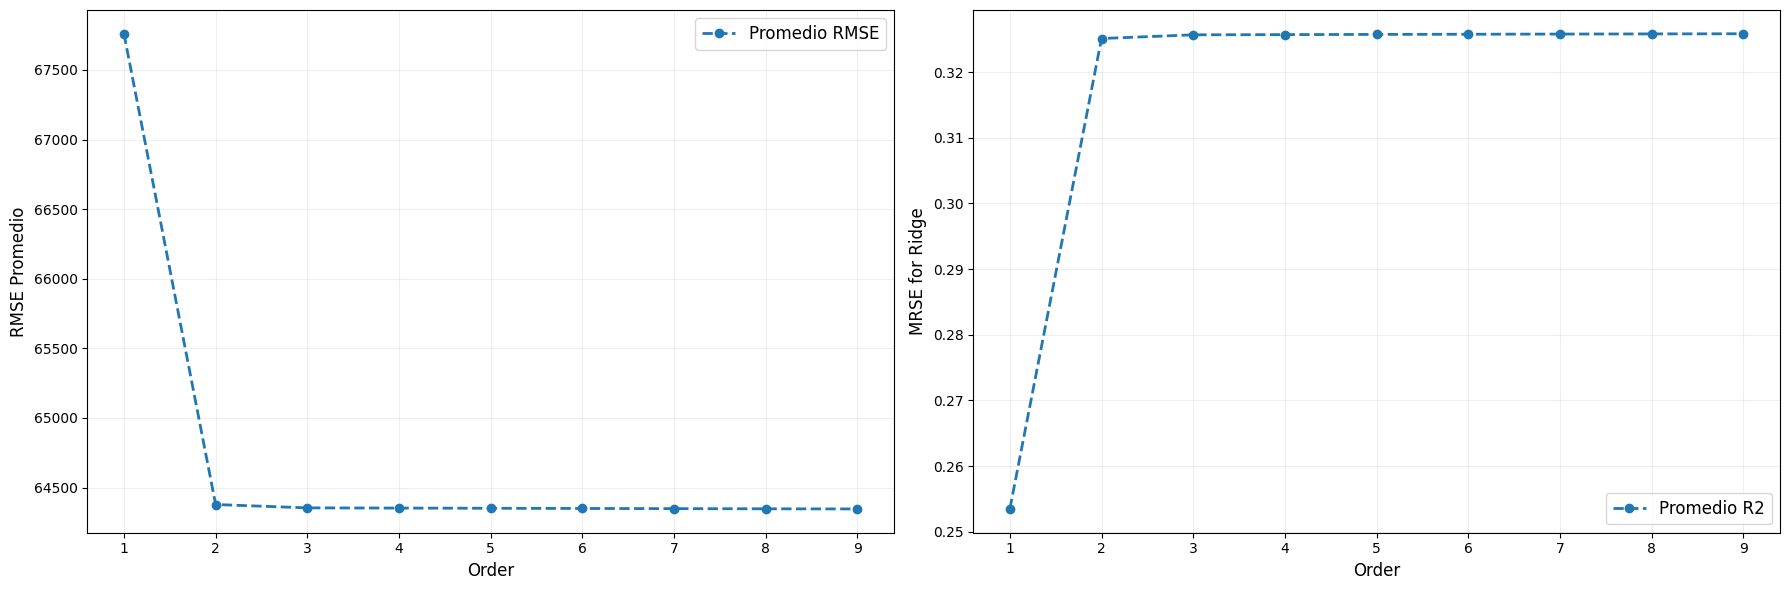

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plotting RMSE
axes[0].plot(orders, list(rmse.values()), '--o', label='Promedio RMSE', linewidth=2)
axes[0].set_xlabel("Order", fontsize=12)
axes[0].set_ylabel("RMSE Promedio", fontsize=12)
axes[0].grid(alpha=0.2)
axes[0].legend(fontsize=12)
# Plotting R2
axes[1].plot(orders, list(r2.values()), '--o', label='Promedio R2', linewidth=2)
axes[1].set_xlabel("Order", fontsize=12)
axes[1].set_ylabel("MRSE for Ridge", fontsize=12)
axes[1].grid(alpha=0.2)
axes[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

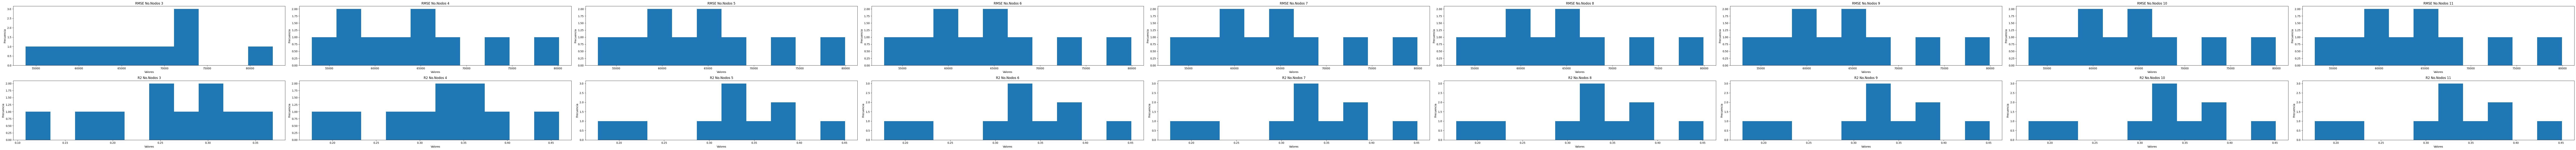

In [ ]:
# Definir el número de columnas y filas para los subplots
num_rows = 2
num_cols = len(r2_cv)
# Crear una figura con el tamaño deseado
plt.figure(figsize=(136, 8))
# Iteramos para cada caso
for i in range(num_cols):
    # Crear el primer subplot para RMSE en la fila superior
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(rmse_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'RMSE No.Nodos {i + 3}')
    # Crear el segundo subplot para R2 en la fila inferior
    plt.subplot(num_rows, num_cols, num_cols + i + 1)
    plt.hist(r2_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'R2 No.Nodos {i + 3}')
# Ajustar el espaciado entre subplots y mostrar la figura
plt.tight_layout()
plt.show()

Para la variable YearBuilt, el análisis sugiere que el grado de polinomio óptimo para la transformación spline es 2. Esto se respalda al observar que los histogramas asociados a este grado de polinomio muestran rangos de Root Mean Square Error (RMSE) similares, lo que indica una buena adecuación del modelo a los datos.

La variable que muestra menos linealidad, considerando el tamaño del polinomio y la consistencia en la estructura de los histogramas, es **GarageYrBlt**. Por lo tanto, esta será la variable seleccionada para aplicar la transformación spline.

In [ ]:
X = datos['GarageYrBlt']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## Modelo 1

### Spline Cubico

#### Selección del Número Óptimo de Nodos

El primer paso en la utilización de Spline es determinar el número óptimo de nodos. Para este propósito, se realizó la construcción de una matriz de datos Spline en un rango que abarcó desde 3 hasta 20 nodos. Esta selección se evaluó mediante un modelo de regresión lineal, aplicando técnicas de validación cruzada. Se calcularon métricas como el Root Mean Square Error (RMSE) y el coeficiente de determinación (R-squared). Luego, se representaron gráficamente los modelos Spline junto con la ubicación de los nodos para su visualización.

Posiciones para 3 nodos: 
[1957.0, 1981.0, 1972.0]
Posiciones para 4 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0]
Posiciones para 5 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0]
Posiciones para 6 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0]
Posiciones para 7 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0]
Posiciones para 8 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0]
Posiciones para 9 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0, 2004.0]
Posiciones para 10 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0, 2004.0, 1978.0]
Posiciones para 11 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0, 2004.0, 1978.0, 2009.0]
Posiciones para 12 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0, 2004.0, 1978.0, 2009.0, 1969.0]
Posiciones para 13 nodos: 
[1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0, 2004.0, 1978.0, 2009.0, 1969.0, 200

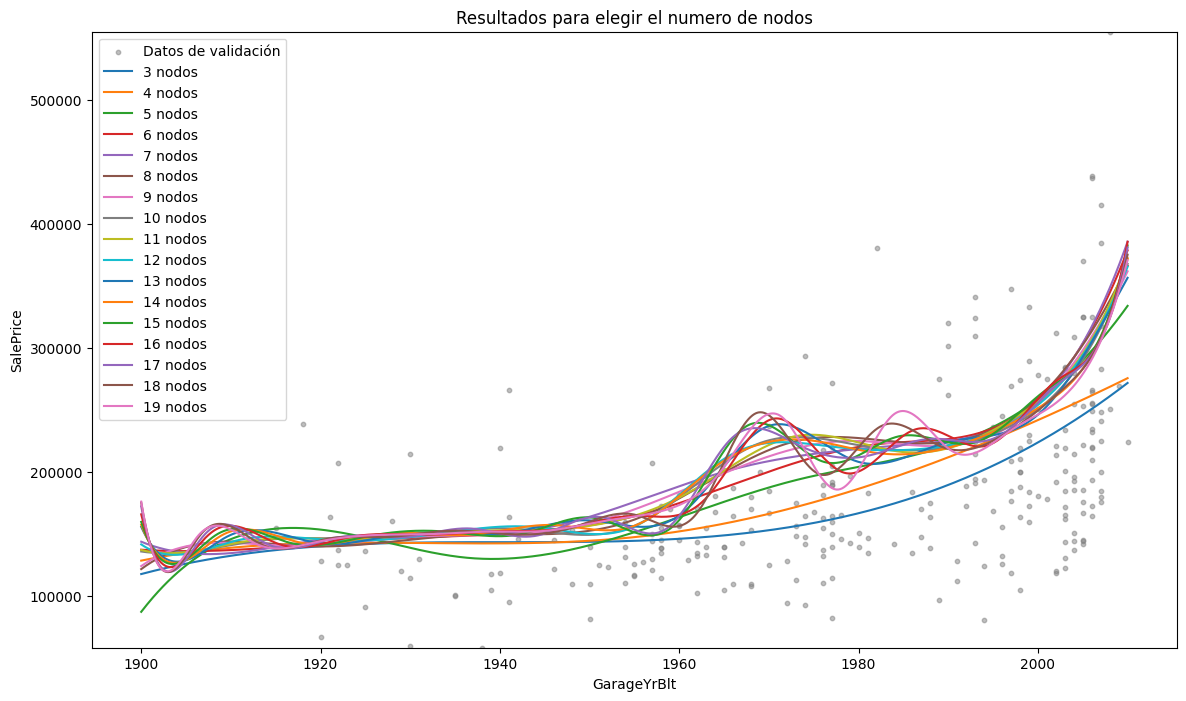

In [ ]:
rmse = {}
rmse_cv = []
r2 = {}
r2_cv = []
knots = range(3, 20)

plt.figure(figsize=(14, 8))

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

X_plot = np.linspace(min(X_train), max(X_train), 1000).reshape(-1, 1)

for num_knots in knots:  # Prueba diferentes números de nodos
    # Spline
    # Se crean los datos para el spline
    X_spline_train = dmatrix(f"bs(X, df={num_knots}, degree=3, include_intercept=False)",
                        {"X": X_train.ravel()}, return_type='dataframe')
    # Inicializar el modelo
    model_spline = LinearRegression()

    # Calcular y almacenar metricas
    # Calcular RMSE utilizando validación cruzada
    scores = cross_validate(model_spline, X_spline_train, y_train, cv=15, scoring=['neg_root_mean_squared_error', 'r2'])
    rmse_val = scores['test_neg_root_mean_squared_error'] * -1
    r2_val = scores['test_r2']
    # Guardar las metricas
    rmse_cv.append(rmse_val)
    rmse[num_knots] = np.mean(rmse_val)
    r2_cv.append(r2_val)
    r2[num_knots] = np.mean(r2_val)

    # Graficar bonito
    # Entrenar el modelo
    model_spline.fit(X_spline_train, y_train)
    # Mostrar la ubicacion de los nodos
    knot_indexes = list(X_spline_train.design_info.column_name_indexes.values())[1:num_knots+1]
    knot_locations = [X_train.index[i] for i in knot_indexes]
    print(f"Posiciones para {num_knots} nodos: \n{X_train.iloc[knot_locations].values.tolist()}")
    # Hacer el gráfico
    X_spline_plot = dmatrix(f"bs(X, df={num_knots}, degree=3, include_intercept=False)",
                        {"X": X_plot.ravel()}, return_type='dataframe')
    y_spline_plot = model_spline.predict(X_spline_plot)
    plt.plot(X_plot, y_spline_plot, label=f"{num_knots} nodos")

plt.title('Resultados para elegir el numero de nodos')
plt.xlabel('GarageYrBlt')
plt.ylabel('SalePrice')
plt.legend()
plt.ylim(min(y_val), max(y_val))
plt.show()

A continuación, se presenta el promedio de los resultados obtenidos a través de la validación cruzada en función del número de nodos. Según las métricas observadas, queda evidente que el número óptimo de nodos es 15.

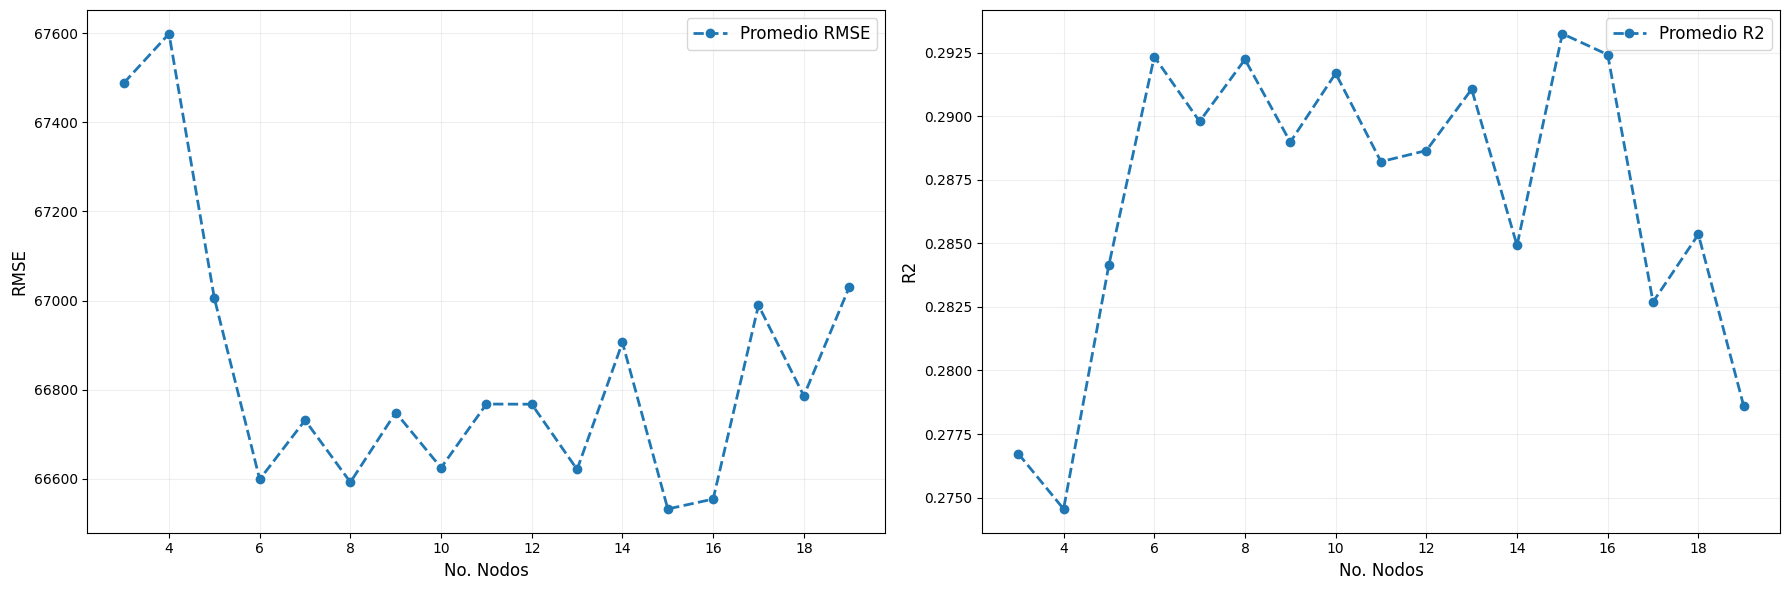

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plotting RMSE
axes[0].plot(knots, list(rmse.values()), '--o', label='Promedio RMSE', linewidth=2)
axes[0].set_xlabel("No. Nodos", fontsize=12)
axes[0].set_ylabel("RMSE", fontsize=12)
axes[0].grid(alpha=0.2)
axes[0].legend(fontsize=12)
# Plotting R2
axes[1].plot(knots, list(r2.values()), '--o', label='Promedio R2', linewidth=2)
axes[1].set_xlabel("No. Nodos", fontsize=12)
axes[1].set_ylabel("R2", fontsize=12)
axes[1].grid(alpha=0.2)
axes[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

No obstante, es importante señalar que la gráfica de comparación entre el número de nodos y las métricas parece mostrar cierta oscilación. Para confirmar esta decisión, se procedió a representar los histogramas de los resultados de la validación cruzada.

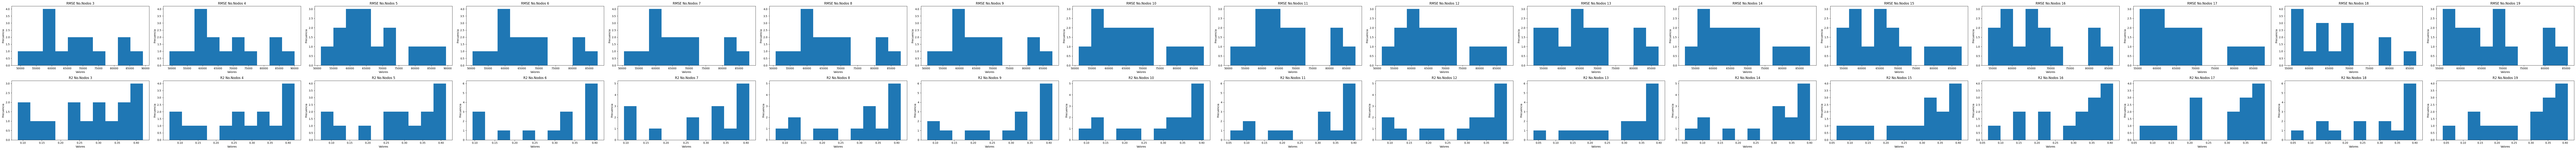

In [ ]:
# Definir el número de columnas y filas para los subplots
num_rows = 2
num_cols = len(r2_cv)
# Crear una figura con el tamaño deseado
plt.figure(figsize=(136, 8))
# Iteramos para cada caso
for i in range(num_cols):
    # Crear el primer subplot para RMSE en la fila superior
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(rmse_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'RMSE No.Nodos {i + 3}')
    # Crear el segundo subplot para R2 en la fila inferior
    plt.subplot(num_rows, num_cols, num_cols + i + 1)
    plt.hist(r2_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'R2 No.Nodos {i + 3}')
# Ajustar el espaciado entre subplots y mostrar la figura
plt.tight_layout()
plt.show()

Los histogramas nos proporcionan una clara visualización de los resultados. En el caso del RMSE, los valores se encuentran dentro del rango de 50,000 a 90,000, y para el R2, se sitúan entre 0.1 y 0.4. Además, se observa que el comportamiento de los histogramas sigue un patrón similar, sin que las métricas se alejen de los rangos mencionados. Por lo tanto, la elección de 15 nodos parece ser una decisión sólida y respaldada por la consistencia en los resultados.

#### Posición Óptima del Número de Nodos

Habiendo seleccionado el número de nodos, el siguiente paso es determinar la posición óptima de estos para minimizar nuestras métricas, en este caso, el RMSE. Para lograr esto, se desarrolló una función que toma como parámetros la ubicación de los nodos y se encarga de crear el spline y realizar la validación cruzada, con el objetivo de devolver el promedio del RMSE. En este proceso, se emplearon métodos como 'Powell', 'Nelder-Mead' y 'BFGS' para asegurarse de encontrar el valor más bajo del RMSE.

In [ ]:
# Definir una función objetivo que mida la calidad del ajuste del spline
def objective_function(nodes):
    # Ajustar el spline
    nodes = tuple(nodes)
    # Crear la matriz de grados y nodos
    X_spline_train = dmatrix(f"bs(X, knots={nodes}, degree=3, include_intercept=False)",
                        {"X": X_train.ravel()}, return_type='dataframe')
    # Inicializar el modelo
    model_spline = LinearRegression()
    # Calcular RMSE utilizando validación cruzada
    val_cros = cross_val_score(model_spline, X_spline_train, y_train, scoring='neg_root_mean_squared_error', cv=10)
    rmse_val = -1* np.mean(val_cros)
    return rmse_val

# Valores iniciales de los nodos segun lo anterior
## TOCA MODIFICARLO
initial_nodes = [1957.0, 1981.0, 1972.0, 1994.0, 1966.0, 1963.0, 1959.0, 1988.0, 2004.0, 1978.0, 2009.0, 1969.0, 2004.0, 1965.0, 1964.0]

# Define las restricciones como un objeto de tipo Bounds
bounds = [(min(X_train), max(X_train))] * len(initial_nodes)

# Optimización de los metodos
methods = ['Powell', 'Nelder-Mead', 'BFGS', 'TNC']
nodes = None
low_rmse = float('inf')

for i in range(len(methods)):
    method = methods[i]
    print(f'\tPara el metodo {method}')
    result = minimize(objective_function, initial_nodes, method=method, bounds=bounds, options={'keep_feasible': True})
    # Nodos óptimos encontrados
    optimal_nodes = tuple(result.x)
    rmse = result.fun
    print(f"RMSE: {rmse}\nNodos óptimos: \n{optimal_nodes}")
    if rmse < low_rmse:
        low_rmse = rmse
        nodes = optimal_nodes

	Para el metodo Powell
RMSE: 66865.90644436063
Nodos óptimos: 
(1967.9837387624884, 1967.9837387624884, 1967.1631573171671, 1969.9948250676248, 1966.695185079537, 1968.1130453907433, 1942.0162612375116, 1968.0924357078484, 1992.1995419037605, 1966.2797984465876, 1967.27169197325, 1967.420091912198, 1989.7887082550642, 1967.175141008322, 1966.8448115539231)
	Para el metodo Nelder-Mead
RMSE: 67084.71320014026
Nodos óptimos: 
(1961.998563371274, 1967.0079905798948, 1976.9893909815828, 1991.0736532118613, 1968.4020346966083, 1968.8562144915318, 1966.99999764714, 1989.3730729650556, 2006.7993275935505, 1972.5429620469365, 2008.8769195881405, 1974.905561239012, 2006.7923249489786, 1966.999998070503, 1969.000940964682)
	Para el metodo BFGS
RMSE: 66936.54434900655
Nodos óptimos: 
(1960.0000262272429, 1977.7488262552113, 1968.9988787259233, 1993.6278040657062, 1968.6936533563469, 1959.9998165272705, 1967.9667297855783, 1987.7725971176249, 1994.0025630823188, 1977.764702106329, 2009.097914782345

In [ ]:
print(f"Best Nodes: \n{nodes}")

Best Nodes: 
(1967.9837387624884, 1967.9837387624884, 1967.1631573171671, 1969.9948250676248, 1966.695185079537, 1968.1130453907433, 1942.0162612375116, 1968.0924357078484, 1992.1995419037605, 1966.2797984465876, 1967.27169197325, 1967.420091912198, 1989.7887082550642, 1967.175141008322, 1966.8448115539231)


#### Evaluación Final

Una vez obtenida la posición óptima de los nodos, se procederá a realizar las comparaciones finales utilizando el conjunto completo de entrenamiento X_train y evaluándolo en relación al conjunto de validación X_val. Esto nos permitirá evaluar el rendimiento del modelo en datos no vistos y obtener una visión más completa de su capacidad predictiva.

RMSE: 59987.45410432153, R^2: 0.28993078330601196


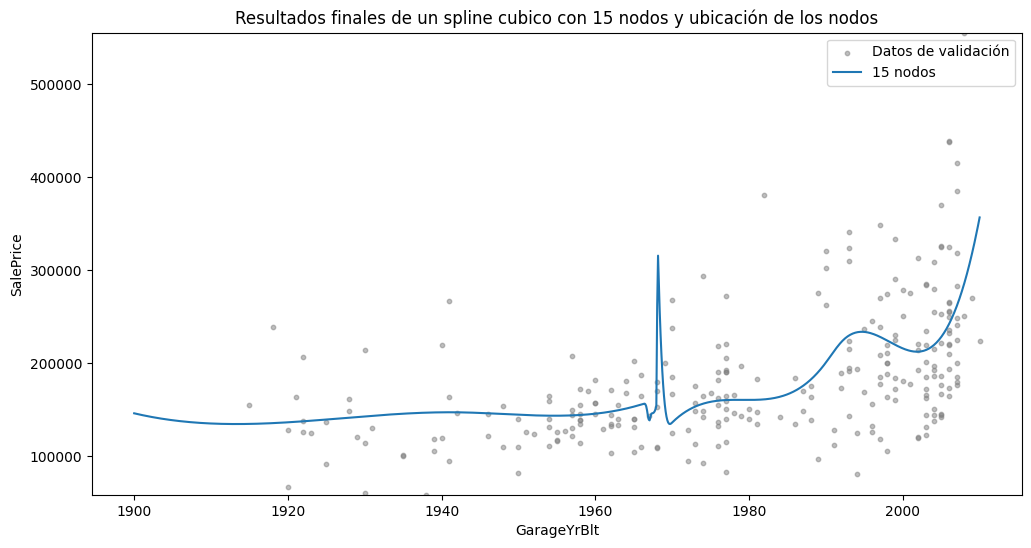

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

X_spline_train = dmatrix(f"bs(X, knots={nodes}, degree=3, include_intercept=False)",
                        {"X": X_train.ravel()}, return_type='dataframe')
X_spline_val = dmatrix(f"bs(X, knots={nodes}, degree=3, include_intercept=False)",
                        {"X": X_val.ravel()}, return_type='dataframe')
# Inicializar el modelo
model_spline = LinearRegression()
model_spline.fit(X_spline_train, y_train)
# Calcular RMSE
y_spline_val_pred = model_spline.predict(X_spline_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))
print(f'RMSE: {rmse_val}, R^2: {r2_score(y_val, y_spline_val_pred)}')

# Hacer el gráfico
X_spline_plot = dmatrix(f"bs(X, knots={nodes}, degree=3, include_intercept=False)",
                        {"X": X_plot.ravel()}, return_type='dataframe')
y_spline_plot = model_spline.predict(X_spline_plot)
plt.plot(X_plot, y_spline_plot, label=f"{len(nodes)} nodos")

plt.title('Resultados finales de un spline cubico con 15 nodos y ubicación de los nodos')
plt.xlabel('GarageYrBlt')
plt.ylabel('SalePrice')
plt.legend()
plt.ylim(min(y_val), max(y_val))
plt.show()

El mejor modelo de spline cúbico, construido con 15 nodos en las siguientes ubicaciones:

(1967.9837387624884, 1967.9837387624884, 1967.1631573171671, 1969.9948250676248, 1966.695185079537, 1968.1130453907433, 1942.0162612375116, 1968.0924357078484, 1992.1995419037605, 1966.2797984465876, 1967.27169197325, 1967.420091912198, 1989.7887082550642, 1967.175141008322, 1966.8448115539231)

En el conjunto de entrenamiento:
- RMSE: 66,865.91

En el conjunto de validación:
- RMSE: 59,987.45
- R^2: 0.29

Estos resultados indican que el modelo es capaz de generalizar bien para datos no vistos, demostrando su capacidad predictiva.

### Spline Natural

#### Selección del Número Óptimo de Nodos

El primer paso en la utilización de Spline es determinar el número óptimo de nodos. Para este propósito, se realizó la construcción de una matriz de datos Spline en un rango que abarcó desde 3 hasta 20 nodos. Esta selección se evaluó mediante un modelo de regresión lineal, aplicando técnicas de validación cruzada. Se calcularon métricas como el Root Mean Square Error (RMSE) y el coeficiente de determinación (R-squared). Luego, se representaron gráficamente los modelos Spline junto con la ubicación de los nodos para su visualización.

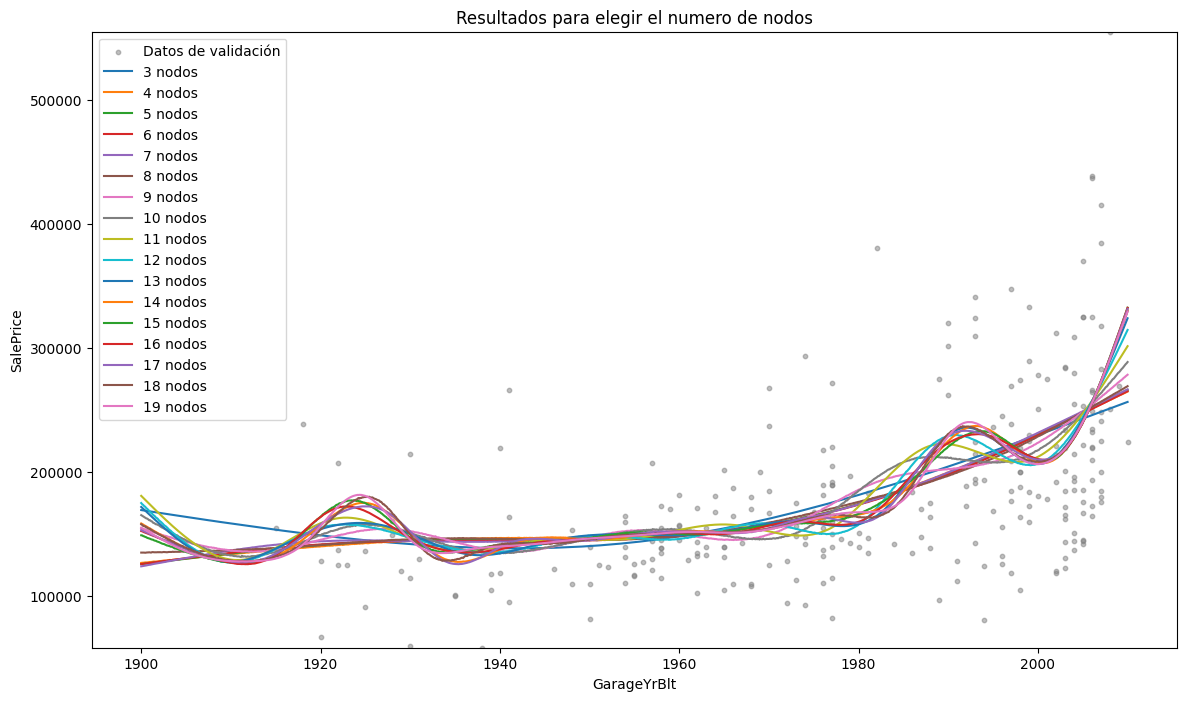

In [ ]:
rmse = {}
rmse_cv = []
r2 = {}
r2_cv = []
knots = range(3, 20)

plt.figure(figsize=(14, 8))

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

X_plot = np.linspace(min(X_train), max(X_train), 1000).reshape(-1, 1)

for num_knots in knots:  # Prueba diferentes números de nodos
    # Spline
    # Se crean los datos para el spline
    X_spline_train = dmatrix(f"cr(X, df={num_knots})",
                        {"X": X_train.ravel()}, return_type='dataframe')
    # Inicializar el modelo
    model_spline = LinearRegression()

    # Calcular y almacenar metricas
    # Calcular RMSE utilizando validación cruzada
    scores = cross_validate(model_spline, X_spline_train, y_train, cv=15, scoring=['neg_root_mean_squared_error', 'r2'])
    rmse_val = scores['test_neg_root_mean_squared_error'] * -1
    r2_val = scores['test_r2']
    # Guardar las metricas
    rmse_cv.append(rmse_val)
    rmse[num_knots] = np.mean(rmse_val)
    r2_cv.append(r2_val)
    r2[num_knots] = np.mean(r2_val)

    # Graficar bonito
    # Entrenar el modelo
    model_spline.fit(X_spline_train, y_train)
    # Hacer el gráfico
    X_spline_plot = dmatrix(f"cr(X, df={num_knots})",
                        {"X": X_plot.ravel()}, return_type='dataframe')
    y_spline_plot = model_spline.predict(X_spline_plot)
    plt.plot(X_plot, y_spline_plot, label=f"{num_knots} nodos")

plt.title('Resultados para elegir el numero de nodos')
plt.xlabel('GarageYrBlt')
plt.ylabel('SalePrice')
plt.legend()
plt.ylim(min(y_val), max(y_val))
plt.show()

A continuación, se presenta el promedio de los resultados obtenidos a través de la validación cruzada en función del número de nodos. Según las métricas observadas, queda evidente que el número óptimo de nodos es 15.

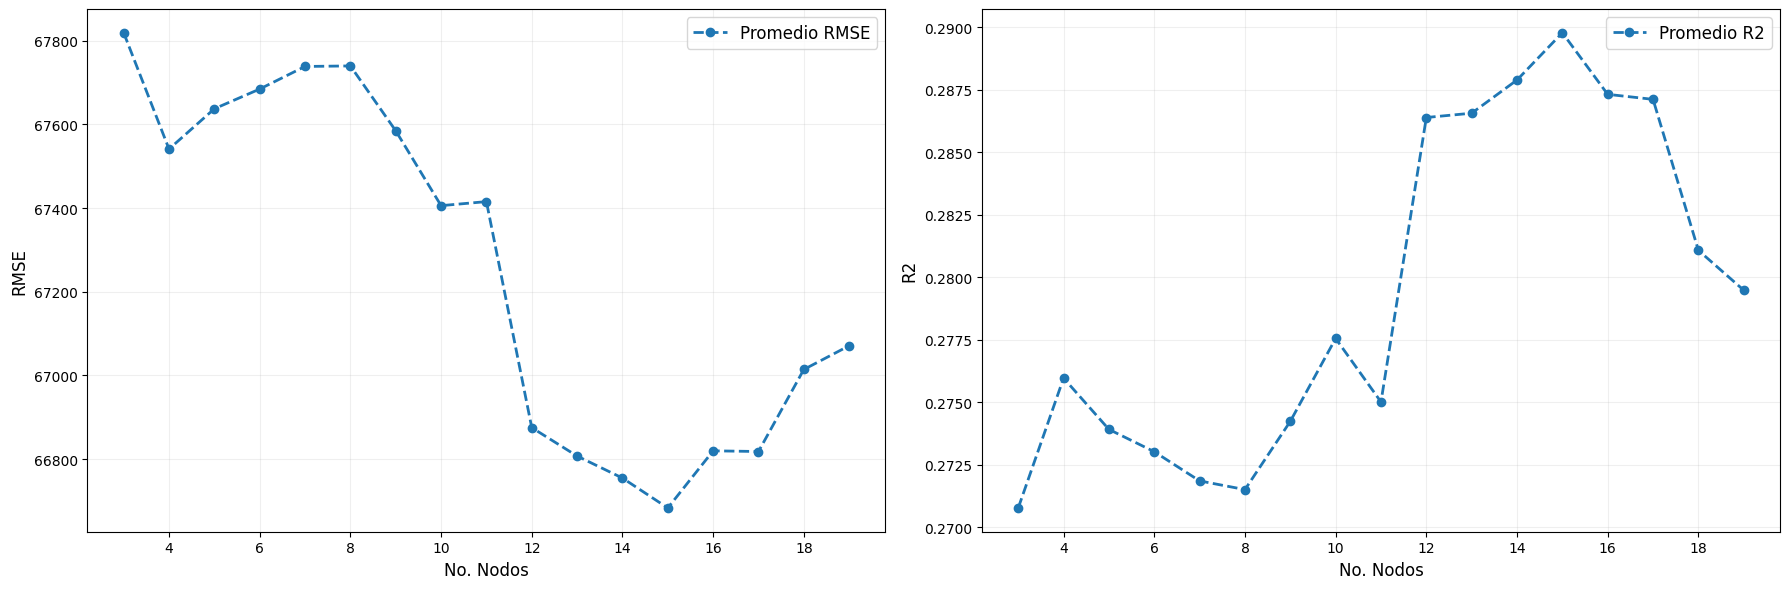

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plotting RMSE
axes[0].plot(knots, list(rmse.values()), '--o', label='Promedio RMSE', linewidth=2)
axes[0].set_xlabel("No. Nodos", fontsize=12)
axes[0].set_ylabel("RMSE", fontsize=12)
axes[0].grid(alpha=0.2)
axes[0].legend(fontsize=12)
# Plotting R2
axes[1].plot(knots, list(r2.values()), '--o', label='Promedio R2', linewidth=2)
axes[1].set_xlabel("No. Nodos", fontsize=12)
axes[1].set_ylabel("R2", fontsize=12)
axes[1].grid(alpha=0.2)
axes[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
print(f"RMSE mejor en 15 nodos: {rmse[15]} y su R2 de: {r2[15]}")

RMSE mejor en 15 nodos: 66682.94172251479 y su R2 de: 0.2897890765245666


No obstante, es importante señalar que la gráfica de comparación entre el número de nodos y las métricas parece mostrar cierta oscilación. Para confirmar esta decisión, se procedió a representar los histogramas de los resultados de la validación cruzada.

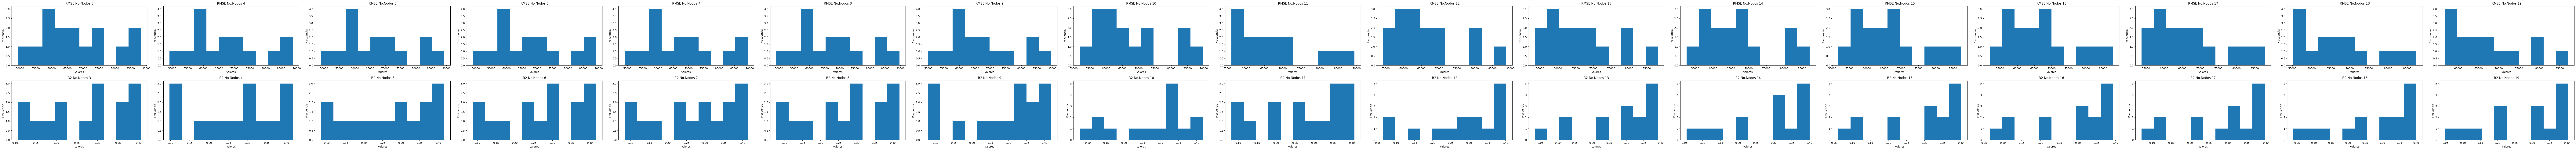

In [ ]:
# Definir el número de columnas y filas para los subplots
num_rows = 2
num_cols = len(r2_cv)
# Crear una figura con el tamaño deseado
plt.figure(figsize=(136, 8))
# Iteramos para cada caso
for i in range(num_cols):
    # Crear el primer subplot para RMSE en la fila superior
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(rmse_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'RMSE No.Nodos {i + 3}')
    # Crear el segundo subplot para R2 en la fila inferior
    plt.subplot(num_rows, num_cols, num_cols + i + 1)
    plt.hist(r2_cv[i])
    plt.xlabel('Valores')
    plt.ylabel('Frecuencia')
    plt.title(f'R2 No.Nodos {i + 3}')
# Ajustar el espaciado entre subplots y mostrar la figura
plt.tight_layout()
plt.show()

Los histogramas nos proporcionan una clara visualización de los resultados. En el caso del RMSE, los valores se encuentran dentro del rango de 50,000 a 90,000, y para el R2, se sitúan entre 0.1 y 0.4. Además, se observa que el comportamiento de los histogramas sigue un patrón similar, sin que las métricas se alejen de los rangos mencionados. Por lo tanto, la elección de 15 nodos parece ser una decisión sólida y respaldada por la consistencia en los resultados.

#### Evaluación Final

Después de seleccionar el número de nodos y determinar su ubicación óptima, se procederá a realizar la evaluación final del modelo. Se mostrarán los resultados obtenidos al entrenar el modelo con todo el conjunto X_train y compararlos con el conjunto de validación. Es importante señalar que, en el caso del spline natural, no se pudo obtener la posición de los nodos, lo que imposibilita su visualización y posterior optimización.

RMSE: 60530.15073541647, R^2: 0.2770249086899579


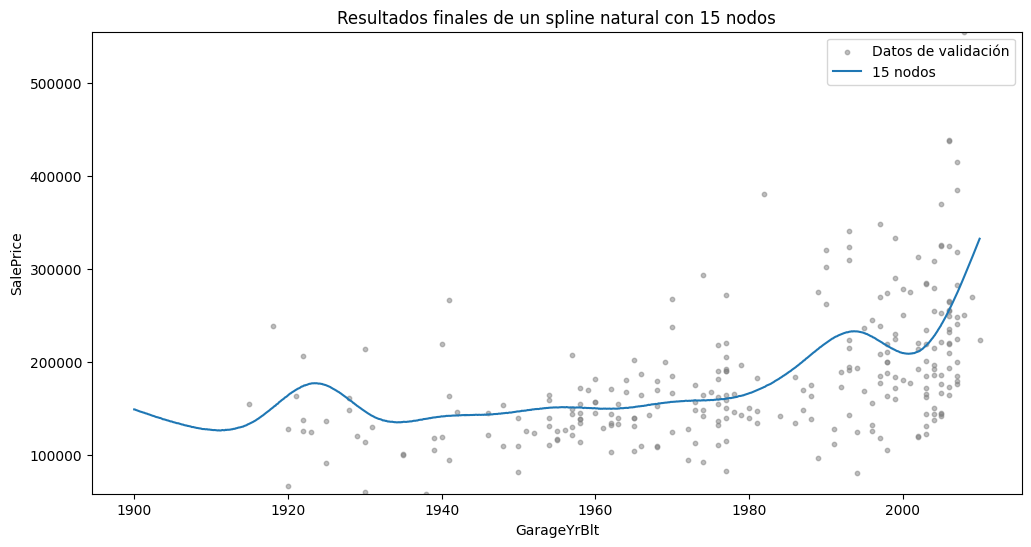

In [ ]:
plt.figure(figsize=(12, 6))

plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")

X_spline_train = dmatrix(f"cr(X, df=15)", {"X": X_train.ravel()}, return_type='dataframe')
X_spline_val = dmatrix(f"cr(X, df=15)", {"X": X_val.ravel()}, return_type='dataframe')

# Inicializar el modelo
model_spline = LinearRegression()
model_spline.fit(X_spline_train, y_train)

# Calcular RMSE
y_spline_val_pred = model_spline.predict(X_spline_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_spline_val_pred))
print(f'RMSE: {rmse_val}, R^2: {r2_score(y_val, y_spline_val_pred)}')

# Hacer el gráfico
X_spline_plot = dmatrix(f"cr(X, df=15)", {"X": X_plot.ravel()}, return_type='dataframe')
y_spline_plot = model_spline.predict(X_spline_plot)
plt.plot(X_plot, y_spline_plot, label=f"15 nodos")

plt.title('Resultados finales de un spline natural con 15 nodos')
plt.xlabel('GarageYrBlt')
plt.ylabel('SalePrice')
plt.legend()
plt.ylim(min(y_val), max(y_val))
plt.show()

El mejor modelo de spline natural, construido con 15 nodos, mostró los siguientes resultados:

En el conjunto de entrenamiento:
- RMSE: 66,682.94
- R^2: 0.2897

En el conjunto de validación:
- RMSE: 60,530.15
- R^2: 0.2770

Comparando estos resultados con el conjunto de prueba previamente mencionado, se observa que el modelo de spline natural tiene un RMSE menor en el conjunto de validación, lo que indica un mejor rendimiento en comparación con el conjunto de prueba. Sin embargo, el R^2 también disminuye, lo que sugiere que el modelo podría no ser tan explicativo en el conjunto de validación como en el conjunto de prueba.

### Decisión Final

Ambos modelos exhibieron un comportamiento similar en el conjunto de entrenamiento, alcanzando un RMSE de aproximadamente 66,700. Sin embargo, en lo que respecta al conjunto de validación, el modelo de spline cúbico mostró métricas superiores con un RMSE de 59,987.45 y un R^2 de 0.29, en contraste con el spline natural. Debido a su destacada capacidad de generalización en datos no vistos, el modelo de spline cúbico será presentado en la sección final de conclusiones.


## Modelo 2

### Validación cruzada

Se define la validación cruzada tanto manual como por librería con 15 divisiones por defecto. La diferencia entre estas dos son únicamente entre algunos estadísticos, por ejemplo, el coeficiente de correlación de Pearson en la manual, y la capacidad de escoger métricas definidad por `sklearn` en el de la librería.

In [ ]:
def validacion_cruzada(
    modelo: BaseEstimator,
    X: npt.NDArray[np.floating],
    y: npt.NDArray[np.floating],
    metricas={
        "r2": "r2",
        "mse": "neg_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
    },
    n_splits = 15
) -> dict[str, Any]:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    cv: dict[str, Any] = cross_validate(
        modelo,
        X,
        y,
        cv=kf,
        scoring=metricas,
        return_train_score=True,
    )

    metricas_negativas = {"mse", "mae", "rmse"}
    for metrica in cv.keys():
        cv[metrica] = np.mean(cv[metrica])
        if metrica.split("_")[-1] in metricas_negativas:
            cv[metrica] = abs(cv[metrica])
    return cv


def validacion_cruzada_manual(
    model: LinearRegression, X: npt.NDArray, y: npt.NDArray, n_splits = 15
) -> dict[str, Any]:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    metricas = ["r2", "mse", "pearson"]
    cv: dict[str, list[Any]] = {}
    for metrica in metricas:
        cv[f"test_{metrica}"] = []
        cv[f"train_{metrica}"] = []

    model = copy(model)
    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]

        X_test = X[test_index]
        y_test = y[test_index]

        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        cv["train_r2"].append(r2_score(y_train, y_train_pred))
        cv["test_r2"].append(r2_score(y_test, y_test_pred))

        cv["train_mse"].append(mean_squared_error(y_train, y_train_pred))
        cv["test_mse"].append(mean_squared_error(y_test, y_test_pred))

        cv["train_pearson"].append(stats.pearsonr(y_train, y_train_pred).correlation)
        cv["test_pearson"].append(stats.pearsonr(y_test, y_test_pred).correlation)

    for metrica in cv.keys():
        cv[metrica] = np.mean(cv[metrica])

    cv["train_rmse"] = np.sqrt(cv["train_mse"])  # type: ignore
    cv["test_rmse"] = np.sqrt(cv["test_mse"])  # type: ignore

    return cv

### Definición de Spline

Dada la existencia de los nodos, definir un grado del spline no será tomado en este proyecto. Así, nos quedamos con el estándar (cúbico) junto el natural. Estos modelos serán evaluados a través de validación cruzada.

In [ ]:
TipoSpline = Literal["natural", "cubico"]

def predecir_y_validar_spline(
    X: npt.NDArray[np.floating],
    y: npt.NDArray,
    knots: tuple[float, ...],
    tipo: TipoSpline = "cubico",
) -> tuple[pd.DataFrame, dict[str, Any]]:
    match tipo:
        case "cubico":
            descripcion_modelo = (
                f"bs(data, knots={knots}, degree=3, include_intercept=False)"
            )
        case "natural":
            descripcion_modelo = f"cr(data, knots={knots})"
        case _:
            raise ValueError("Tipo no es válido")


    variables = {
        "data": X.ravel(),
    }
    X_spline = dmatrix(
        descripcion_modelo,
        variables,
        return_type="dataframe",
    )

    modelo = LinearRegression()
    cv = validacion_cruzada(
        modelo,
        X_spline.to_numpy(),
        y,
    )

    modelo.fit(X_spline, y)
    preds = modelo.predict(X_spline)
    df = pd.DataFrame({"X": X.flatten(), "y_pred": preds, "y_true": y})
    df = df.sort_values("X")

    return (df, cv)

def evaluar_spline(
    X: npt.NDArray[np.floating],
    y: npt.NDArray[np.floating],
    knots: tuple[float, ...] | list[tuple[float, ...]],
    tipos: TipoSpline | list[TipoSpline] = "cubico",
) -> pd.DataFrame:
    tipos_arr: list[TipoSpline] = np.asarray([tipos]).flatten().tolist()
    fig, ax = plt.subplots()
    ax.scatter(X, y, color="C1")
    cvs = []

    if not isinstance(knots, list):
        knots_arr = [knots] * len(tipos_arr)
    else:
        knots_arr = knots

    for idx, tipo in enumerate(tipos_arr):
        df, cv = predecir_y_validar_spline(
            X,
            y,
            knots_arr[idx],
            tipo,
        )
        X_ordenado = df["X"]
        preds = df["y_pred"]
        ax.plot(X_ordenado, preds, color=f"C{idx + 2}", label=tipo)
        cvs.append(cv)
    ax.legend(loc="upper right")

    df = pd.DataFrame(cvs)
    df.index = tipos_arr  # type: ignore
    return df


### Visualización del Spline con nodos arbitrarios

Para esta visualización únicamente se seleccionan nodos arbitrarios cerca del mínimo y el máximo.

fit_time  score_time  test_r2  train_r2       test_mse  \
cubico      0.002       0.001    0.294     0.300 4635861453.726   
natural     0.001       0.001    0.285     0.286 4688914542.410   

             train_mse  test_mae  train_mae  test_rmse  train_rmse  
cubico  4558658345.137 46476.899  46145.249  66609.957   67509.576  
natural 4649764474.586 46652.282  46434.114  67068.403   68181.468

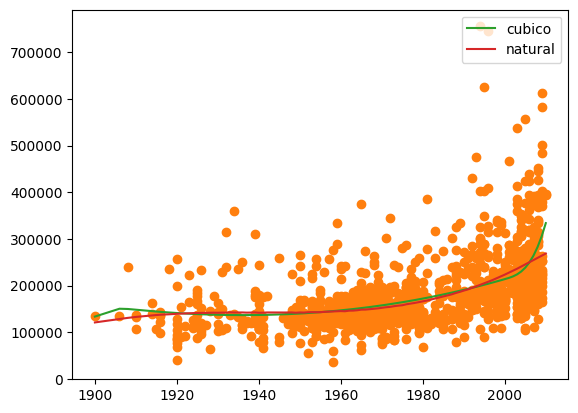

In [ ]:
columna = "GarageYrBlt"
X_spline_values, y_spline_values = X_train.to_numpy(), y_train.to_numpy()

knots = (1910, 2000)
tipos: list[TipoSpline] = ["cubico", "natural"]
evaluar_spline(X_spline_values, y_spline_values, knots, tipos)

Podemos observar que poseen un $R^2$ incluso menor al obtenido por la regresión lineal

### Encontrar nodos adecuados

A través de la fuerza bruta lo haremos seleccionando los cuantiles del conjunto de datos, conteniendo en los nodos impares los cuantiles con denominador par ($\frac{1}{4}, \frac{1}{2}, \frac{3}{4}, ...$) y en los pares los cuantiles con denominador impar ($\frac{1}{3}, \frac{2}{3}, ...$). Esto se hará hasta encontrar cuantiles correspondientes al 10% de la población.

In [ ]:
def encontrar_parametros_spline(
    X: npt.NDArray,
    y: npt.NDArray,
    tipo: TipoSpline = "cubico",
    metodo: Literal["fuerza_bruta"] = "fuerza_bruta",
) -> dict[str, Any]:
    best_knots = {}
    metrica = "test_r2"

    def es_mejor_metrica(a: float) -> bool:
        return a > best_knots[metrica]

    match metodo:
        case "fuerza_bruta":
            iter = 1
            while iter < len(X) * 0.1:
                qs = [1 / (iter + 1) * i for i in range(1, iter + 1)]
                knots = tuple(np.quantile(X, qs))
                _, cv = predecir_y_validar_spline(X, y, tipo=tipo, knots=knots)
                if best_knots.get(metrica) is None or es_mejor_metrica(cv[metrica]):
                    best_knots = cv
                    best_knots["knots"] = knots
                    best_knots["n_knots"] = len(knots)
                iter += 1
        case _:
            raise ValueError("Método desconocido")

    return best_knots


best_knots_cubico = encontrar_parametros_spline(
    X_spline_values, y_spline_values, "cubico"
)
best_knots_natural = encontrar_parametros_spline(
    X_spline_values, y_spline_values, "natural"
)
best_knots = [best_knots_cubico.pop("knots"), best_knots_natural.pop("knots")]

In [ ]:
df = pd.DataFrame([best_knots_cubico, best_knots_natural])
df.index = ["cubico", "natural"] # type: ignore
df

fit_time  score_time  test_r2  train_r2       test_mse  \
cubico      0.001       0.001    0.298     0.313 4578738223.421   
natural     0.012       0.002    0.302     0.333 4531203518.941   

             train_mse  test_mae  train_mae  test_rmse  train_rmse  n_knots  
cubico  4473365217.362 46438.793  46022.679  66316.834   66875.839        3  
natural 4341931458.779 46345.755  45462.471  66089.051   65886.716       16

fit_time  score_time  test_r2  train_r2       test_mse  \
cubico      0.002       0.001    0.298     0.313 4578738223.421   
natural     0.011       0.002    0.302     0.333 4531203518.941   

             train_mse  test_mae  train_mae  test_rmse  train_rmse  
cubico  4473365217.362 46438.793  46022.679  66316.834   66875.839  
natural 4341931458.779 46345.755  45462.471  66089.051   65886.716

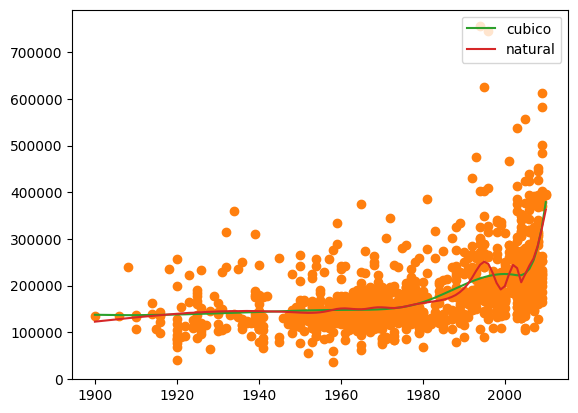

In [ ]:
evaluar_spline(X_spline_values, y_spline_values, best_knots, tipos)

# Kernel

## Modelo 1

Ahora presentaremos el primer modelo que implementamos para los kernel. A continuación, explicaremos que funciones o conceptemos nos fueron utiles a la hora de implementarlo, además de que daremos una descripción de como fue el paso a paso para encontrar el modelo que arrojara las mejores métricas. Por último, hablaremos de un hallazgo que descubrimos al realizar el ejercicio y nos parecio importante mencionarlo.

### Explicación del primer modelo de kernel

En este modelo utilizamos la función `KernelRidge` de la librería scikit-learn que hace uso de regularización de kernel para ajustar un modelo de regresión. Esta función nos permite incorporar información sobre la estructura de los datos y encontrar una relación no lineal entre las características de entrada y la variable objetivo.

Para obtener los mejores parámetros, realizamos una búsqueda en grilla con la función `GridSearchCV` que explora exhaustivamente un espacio predefinido de parámetros para el modelo `KernelRidge`. Lo que hace es evaluar el rendimiento del modelo con diferentes combinaciones de hiperparámetros mediante validación cruzada. En este caso, utilizamos una validación cruzada de 10-fold (cv=10) y como métrica de evaluación utilizamos el coeficiente de determinación R2 (scoring='r2'). `GridSearchCV` busca las combinaciones de parámetros que maximizan esta métrica, lo que nos ayuda a encontrar la configuración óptima del modelo.

En nuestro caso la grilla tiene la siguiente forma:

```
parameters = {
    'kernel': ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    'alpha': [0.1, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0]
}
```
Donde:

- *'kernel'* especifica el tipo de kernel utilizado en el modelo KernelRidge. Podemos elegir entre varios tipos, como 'linear', 'poly', 'rbf', entre otros.
- *'alpha'* representa el hiperparámetro de regularización, que controla la fuerza de la regularización aplicada al modelo.
- *'gamma'* es otro hiperparámetro que se utiliza en algunos tipos de kernel, como 'poly' y 'rbf', para ajustar la complejidad del modelo.


Por último, calculamos las métricas de R2 y RMSE. El coeficiente de determinación R2 nos proporciona información sobre cuánta varianza en la variable objetivo es explicada por nuestro modelo. Un valor de 1 indica un ajuste perfecto, mientras que un valor cercano a 0 sugiere que el modelo no explica la variabilidad de los datos. El RMSE (Root Mean Square Error) mide la precisión de las predicciones, proporcionando una medida de cuán cerca están las predicciones del modelo de los valores reales.

### Primer intento: $R^2$ = 0.76 y RMSE = 34571.81

Antes de iniciar con nuestro kernel, primero escalaremos nuestros datos con el propósito de ajustarlos en un rango que va de 0 a 1. Es relevante mencionar que en este modelo inicial, emplearemos tanto variables numéricas discretas como continuas como predictores, lo que implica que contaremos con un total de 23 variables predictoras.

In [ ]:
X = datos[variables_numericas]
X.head()

LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtUnfSF  \
0     8450       2003          2003     196.000         706        150   
1     9600       1976          1976       0.000         978        284   
2    11250       2001          2002     162.000         486        434   
3     9550       1915          1970       0.000         216        540   
4    14260       2000          2000     350.000         655        490   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  FullBath  \
0          856       856       854       1710             1         2   
1         1262      1262         0       1262             0         2   
2          920       920       866       1786             1         2   
3          756       961       756       1717             1         1   
4         1145      1145      1053       2198             1         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         1             3             1             8           0   
1         0             3             1             6           1   
2         1             3             1             6           1   
3         0             3             1             7           1   
4         1             4             1             9           1   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  YrSold  
0     2003.000           2         548           0           61    2008  
1     1976.000           2         460         298            0    2007  
2     2001.000           2         608           0           42    2008  
3     1998.000           3         642           0           35    2006  
4     2000.000           3         836         192           84    2008

In [ ]:
y

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1338, dtype: int64

In [ ]:
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Vamos a dividir nuestro conjunto de datos entre train y validación.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Introduciremos varios parámetros, que posteriormente serán evaluados mediante validación cruzada para determinar cuáles son los más óptimos.

In [ ]:
parameters = {
    'kernel': ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    'alpha': [0.1, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0]
}

In [ ]:
# Se genera el modelo KernelRidge.
kernel_ridge = KernelRidge()

# Se crea un objeto GridSearchCV para la búsqueda de malla.
grid_search = GridSearchCV(kernel_ridge, parameters, cv=10, scoring='r2')

# Entrenamos el modelo con los datos de entrenamiento.
grid_search.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = grid_search.predict(X_test)

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

print("Mejores Parámetros: ", grid_search.best_params_)

Error de raíz cuadrada media: 34571.81
R2: 0.76
Mejores Parámetros:  {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'laplacian'}


### Segundo intento: $R^2$ = 0.79 y RMSE = 32699.68

Al escalar las variables dentro del rango de 0 a 1, observamos un coeficiente de determinación (R^2) de 0.76 y un error de raíz cuadrada media de 34571.81, utilizando un alpha de 0.1 (ancho de ventana), un gamma de 0.1 y un kernel laplaciano. No obstante, ahora evaluaremos si esta métrica mejora al escalar las variables numericas en el rango de -1 a 1, en total para este intento tenemos 23 variables predictoras.

In [ ]:
X = datos[variables_numericas]
X.head()

LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtUnfSF  \
0     8450       2003          2003     196.000         706        150   
1     9600       1976          1976       0.000         978        284   
2    11250       2001          2002     162.000         486        434   
3     9550       1915          1970       0.000         216        540   
4    14260       2000          2000     350.000         655        490   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  BsmtFullBath  FullBath  \
0          856       856       854       1710             1         2   
1         1262      1262         0       1262             0         2   
2          920       920       866       1786             1         2   
3          756       961       756       1717             1         1   
4         1145      1145      1053       2198             1         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0         1             3             1             8           0   
1         0             3             1             6           1   
2         1             3             1             6           1   
3         0             3             1             7           1   
4         1             4             1             9           1   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  YrSold  
0     2003.000           2         548           0           61    2008  
1     1976.000           2         460         298            0    2007  
2     2001.000           2         608           0           42    2008  
3     1998.000           3         642           0           35    2006  
4     2000.000           3         836         192           84    2008

In [ ]:
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
parameters = {
    'kernel': ['additive_chi2', 'chi2', 'linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine'],
    'alpha': [0.1, 1.0, 10.0],
    'gamma': [0.01, 0.1, 1.0]
}

In [ ]:
# Se genera el modelo KernelRidge.
kernel_ridge = KernelRidge()

# Se crea un objeto GridSearchCV para la búsqueda de malla.
grid_search = GridSearchCV(kernel_ridge, parameters, cv=10, scoring='r2')

# Entrenamos el modelo con los datos de entrenamiento.
grid_search.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = grid_search.predict(X_test)

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

print("Mejores Parámetros: ", grid_search.best_params_)

Error de raíz cuadrada media: 32699.68
R2: 0.79
Mejores Parámetros:  {'alpha': 0.1, 'gamma': 0.1, 'kernel': 'laplacian'}


Observamos que la métrica ha mejorado, alcanzando un valor de R2 de 0.79 y un RMSE de 32699.68, al mantener un alpha de 0.1 (ancho de ventana), un gamma de 0.1 y utilizar el kernel laplaciano, al escalar las variables en el rango de -1 a 1.

### Kernel con categoricas: $R^2$ = 0.83 y RMSE = 29198.12

Ahora, exploraremos si la inclusión de variables categóricas mejora nuestras métricas. Para hacer uso de estas variables categóricas, realizaremos una codificación one-hot (one-hot encoding). La recategorización inicial que hemos aplicado nos será de utilidad para reducir el número de variables resultantes.

Además, comenzaremos con el escalamiento de las variables numéricas, lo cual facilitará el proceso de aprendizaje del modelo.

In [ ]:
# Crear un objeto MinMaxScaler
scaler = MinMaxScaler()
df_kernel = datos[variables_numericas].copy()
df_kernel[variables_numericas] = scaler.fit_transform(datos[variables_numericas])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Recodificacion por OneHotEncoder a variables categoricas
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohencoder = encoder.fit(datos[variables_categoricas])
df_cat = ohencoder.transform(datos[variables_categoricas])
column_names = encoder.get_feature_names_out(datos[variables_categoricas].columns)
df_cat = pd.DataFrame(df_cat, columns=column_names)

In [ ]:
# Union de variables numericas escaladas y categoricas codificadas
df_kernel_categoricas = pd.concat([pd.DataFrame(df_kernel).reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

In [ ]:
df_kernel_categoricas.shape

(1338, 99)

In [ ]:
# Division de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_kernel_categoricas, y, test_size=0.2, random_state=0)

Nosotros corrimos varios intentos variando los parametros de la malla, y estos fueron los resultados.

- **Intento 1**

*Variación de la malla:*

```
parameters = {
    'kernel': ['additive_chi2', 'rbf', 'laplacian', 'sigmoid',
    'cosine', 'chi2', 'linear', 'poly', 'polynomial'],
    'alpha': [0.5, 0.7],
    'gamma': [0.04555, 0.05, 0.1]
}
```

*Resultados obtenidos:*

Error Cuadrático Medio: 31699.96

R2: 0.80

Mejores Parámetros:  {'alpha': 0.05, 'gamma': 0.01, 'kernel': 'laplacian'}

- **Intento 2**

*Variación de la malla:*

```
parameters = {
    'kernel': ['additive_chi2', 'rbf', 'laplacian'],
    'alpha': [0.001, 0.01, 0.05],
    'gamma': [0.05, 0.06]
}
```

*Resultados obtenidos:*

Error Cuadrático Medio: 30492.96

R2: 0.82

Mejores Parámetros:  {'alpha': 0.05, 'gamma': 0.05, 'kernel': 'laplacian'}



Ahora en este caso vamos ajustar los parametros de la malla para los valores de ventana (alpha) y el gamma tomando en cuenta los hallazgos anteriores.

In [ ]:
parameters = {
    'kernel': ['additive_chi2', 'rbf', 'laplacian', 'sigmoid', 'cosine', 'chi2', 'linear', 'poly', 'polynomial'],
    'alpha': [0.5, 0.7],
    'gamma': [0.045, 0.05, 0.1]
}

In [ ]:
# Se genera el modelo KernelRidge.
kernel_ridge = KernelRidge()

# Se crea un objeto GridSearchCV para la búsqueda de malla.
grid_search = GridSearchCV(kernel_ridge, parameters, cv=10, scoring='r2')

# Entrenamos el modelo con los datos de entrenamiento.
grid_search.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = grid_search.predict(X_test)

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

print("Mejores Parámetros: ", grid_search.best_params_)

Error de raíz cuadrada media: 29198.12
R2: 0.83
Mejores Parámetros:  {'alpha': 0.5, 'gamma': 0.045, 'kernel': 'laplacian'}


Al ejecutar nuestro modelo con el conjunto completo de variables, incluyendo tanto las numéricas como las categóricas, que suman un total de 99 variables, obtuvimos un R2 de 0.83 y un error de raíz cuadrada media de 29198.12. Estos resultados se lograron utilizando los siguientes parámetros optimizados: alpha=0.5, gamma=0.045 y un kernel tipo 'laplacian'.

### Un enfoque interesante sobre este modelo de kernel

Como se acaba de demostrar utilizando las 99 variables disponibles, que incluyen tanto variables numéricas como categóricas, se obtiene un R2 de 0.83 y un RMSE de 29198.12 con el mejor modelo. Sin embargo, debido a la gran cantidad de variables en juego, este modelo podría resultar costoso en términos computacionales y difícil de interpretar. Para contextualizarlo, imaginemos que estamos desarrollando este modelo para una empresa inmobiliaria. No sería factible ni práctico sugerir a los clientes que proporcionen datos de 99 características de sus propiedades con el fin de obtener el precio más preciso.

Por lo tanto, en esta sección, nuestra intención es seleccionar las variables que no solo tengan un buen desempeño en términos de predicción, sino también reduzcan el costo computacional y, al mismo tiempo, simplifiquen el número de variables predictoras para mejorar la interpretabilidad del modelo.


In [ ]:
# Utilizando todas las 99 variables, (numericas y categoricas) se obtienen
# resultados de R2 de 0.83 y un RMSE de 29198.12 con el mejor modelo, la idea es seleccionar las
# variables que mejor performance tengan y tambien que bajen el costo computaional.

# Se genera el modelo KernelRidge.
kernel_ridge = KernelRidge()

# Se crea un objeto GridSearchCV para la búsqueda de malla.
grid_search = GridSearchCV(kernel_ridge, parameters, cv=10, scoring='r2')

# Entrenamos el modelo con los datos de entrenamiento.
grid_search.fit(X_train, y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = grid_search.predict(X_test)

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

print("Mejores Parámetros: ", grid_search.best_params_)

Error de raíz cuadrada media: 29198.12
R2: 0.83
Mejores Parámetros:  {'alpha': 0.5, 'gamma': 0.045, 'kernel': 'laplacian'}


In [ ]:
X_train.shape

(1070, 99)

Para alcanzar el objetivo planteado al comienzo de esta sección, investigamos diversas técnicas para identificar las mejores características, y descubrimos la función `SelectKBest`.

`SelectKBest` es una herramienta de selección de características proporcionada por la biblioteca scikit-learn (sklearn). Su función principal radica en la elección de un subconjunto óptimo de características (variables predictoras) basándose en métricas específicas o pruebas estadísticas.

Al utilizar `SelectKBest`, proporcionamos como parámetros la métrica o prueba estadística que deseamos emplear y el número K de características que deseamos que nos seleccione. La función nos devuelve un nuevo conjunto de datos con las variables seleccionadas.

En este contexto, hemos aplicado `SelectKBest` para identificar el conjunto más adecuado de variables. Nos enfocamos en la función *mutual_info_regression*, pues esta la cantidad de información mutua entre las características y la variable objetivo en el contexto de regresión, y puede manejar tanto características numéricas como categóricas.

Nosotros para elegir nuestro K, fuimos probando con distintos valores, y los resultados los fuimos consignando en la siguiente tabla:


| K | $R^2$ | RMSE |
|:--------:|:------:|:---------:|
| 5| 0.73| 36843.47|
| 10| 0.74| 36129.67|
| 15| 0.76| 34614.24|
| 20| 0.79| 32918.97|
| 25| 0.81| 30980.89|
| 29| 0.82| 30554.33|
| 30| 0.82| 30580.44|


Como se puede observar, hemos obtenido un valor de $R^2$ de 0.82 para K igual a 29. A medida que aumentamos el valor de K hasta 30, el $R^2$ se mantiene en ese mismo nivel. Sin embargo, es importante destacar que el RMSE para K=30 aumenta. Debido a esta observación, hemos tomado la decisión de mantener 29 como el número de variables predictoras. Esta elección se basa en el hecho de que el valor de $R^2$ es ligeramente inferior en comparación con el modelo que utiliza 99 variables predictoras, pero está por debajo de un umbral de un punto porcentual. Estamos dispuestos a sacrificar ese punto porcentual con el objetivo de ganar en interpretabilidad y mejorar el rendimiento computacional de nuestro modelo.

In [ ]:
# Se utiliza SelectkBest para buscar el mejor conjunto de variables, basado
# en la función de mutual_info_regression, obteniendo 29 variables.

from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Se crear un selector de variables
selector = SelectKBest(score_func= mutual_info_regression, k=29)

selector.fit(X_train, y_train)

# Se obtiene las variables seleccionadas
campos = selector.get_feature_names_out()

In [ ]:
# De acuerdo a el mejor modelo obtenido anteriormente y con las mejores variables
# se consiguen las siguientes metricas: r2 y RMSE, se pretende mejorar su rendimiento
# con una segunda malla de ajuste de hiperparametros

kernel_ridge = KernelRidge(alpha= 0.5, gamma= 0.045, kernel='laplacian')

# Entrenamos el modelo con los datos de entrenamiento.
kernel_ridge.fit(X_train[campos], y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = kernel_ridge.predict(X_test[campos])

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

Error de raíz cuadrada media: 30894.68
R2: 0.81


In [ ]:
# Variables predictoras finales:
campos

array(['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'OpenPorchSF', 'OverallQual_5', 'OverallQual_7',
       'OverallQual_8', 'ExterQual_Gd', 'ExterQual_TA',
       'Foundation_CBlock', 'Foundation_PConc', 'BsmtQual_Gd',
       'BsmtQual_TA', 'KitchenQual_Gd', 'KitchenQual_TA',
       'GarageType_Detchd', 'GarageFinish_Unf'], dtype=object)

Las mejores 29 variables predictoras seleccionadas por `SelectkBest` fueron: 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'OpenPorchSF', 'OverallQual_5', 'OverallQual_8',
       'OverallQual_Otros', 'ExterQual_Gd', 'ExterQual_TA',
       'Foundation_PConc', 'BsmtQual_Gd', 'BsmtQual_TA', 'KitchenQual_Gd',
       'KitchenQual_TA', 'GarageType_Detchd', 'GarageFinish_Fin',
       'GarageFinish_Unf'



---

Ahora, aplicamos el KernelRidge y la busqueda en grilla a las mejores variables predictoras antes seleccionadas.

In [ ]:
parameters = {
    'kernel': ['additive_chi2', 'rbf', 'laplacian', 'sigmoid', 'cosine', 'chi2', 'linear', 'poly', 'polynomial'],
    'alpha': [0.5, 0.7],
    'gamma': [0.045, 0.05, 0.1]
}

In [ ]:
# Buscamos los mejores parametros para las variables finales, obteniendo r2
# y RMSE de metricas
kernel_ridge = KernelRidge()

# Se crea un objeto GridSearchCV para la búsqueda de cuadrícula.
grid_search = GridSearchCV(kernel_ridge, parameters, cv=10, scoring='r2')

# Entrenamos el modelo con los datos de entrenamiento.
grid_search.fit(X_train[campos], y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = grid_search.predict(X_test[campos])

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

print("Mejores Parámetros: ", grid_search.best_params_)

Error de raíz cuadrada media: 30629.73
R2: 0.81
Mejores Parámetros:  {'alpha': 0.5, 'gamma': 0.1, 'kernel': 'laplacian'}


Como vemos los mejores parámetros son: 'alpha': 0.5, 'gamma': 0.1, 'kernel': 'laplacian'

Vamos a entrenar el modelo final con estos parámetros.

In [ ]:
# Entrenamos el modelo final, con los hiperparametros tuneados.
kernel_ridge = KernelRidge(alpha= 0.5, gamma = 0.1, kernel ='laplacian') # Aqui se cambia

# Entrenamos el modelo con los datos de entrenamiento.
kernel_ridge.fit(X_train[campos], y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = kernel_ridge.predict(X_test[campos])

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

Error de raíz cuadrada media: 30629.73
R2: 0.81


## Modelo 2

### Definición de Kernel Gaussiano, Epanechnikov y Tricube (Kernel Estándar)

Intento de adaptar el ejemplo visto en clase a múltiples variables.

In [ ]:
TipoKernel = Literal["epanechnikov", "gaussian", "tricube"]
class KernelRegression(LinearRegression):
    def __init__(
        self,
        *,
        lmbda: float,
        tipo: TipoKernel = "epanechnikov",
        fit_intercept: bool = True,
        copy_X: bool = True,
        n_jobs: int | None = None,
        positive: bool = False,
    ) -> None:
        super().__init__(
            fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs, positive=positive
        )
        self.lmbda = lmbda
        self.tipo = tipo

    def fit(
        self, X: npt.NDArray, y: npt.NDArray, sample_weight: npt.NDArray | None = None
    ) -> "KernelRegression":
        self.X = X
        self.y = y
        return super().fit(X, y, sample_weight)

    def predict(self, X: npt.NDArray) -> np.ndarray:
        preds = np.zeros(X.shape)
        for i, puntos in enumerate(X.T):
            for j, punto in enumerate(puntos):
                t = np.absolute(self.X.T[i] - punto) / self.lmbda
                match self.tipo:
                    case "epanechnikov":
                        k = np.where(t <= 1, 0.75 * (1 - t), 0)
                    case "gaussian":
                        k = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * t**2)
                    case "tricube":
                        k = np.where(t <= 1, (1 - t**3) ** 3, 0)
                    case _:
                        raise ValueError("Tipo Kernel inválido")
                preds[j, i] = (k @ self.y) / k.sum()
        return np.mean(preds, axis = 1)

### Evaluación kernel estándar

In [ ]:
def validacion_cruzada(
    modelo: BaseEstimator,
    X: npt.NDArray[np.floating],
    y: npt.NDArray[np.floating],
    metricas={
        "r2": "r2",
        "mse": "neg_mean_squared_error",
        "mae": "neg_mean_absolute_error",
        "rmse": "neg_root_mean_squared_error",
    },
    n_splits = 15
) -> dict[str, Any]:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    cv: dict[str, Any] = cross_validate(
        modelo,
        X,
        y,
        cv=kf,
        scoring=metricas,
        return_train_score=True,
    )

    metricas_negativas = {"mse", "mae", "rmse"}
    for metrica in cv.keys():
        cv[metrica] = np.mean(cv[metrica])
        if metrica.split("_")[-1] in metricas_negativas:
            cv[metrica] = abs(cv[metrica])
    return cv

In [ ]:
def evaluar_kernel(
    X: npt.NDArray,
    y: npt.NDArray,
    lmbdas: list[float],
    tipos: list[TipoKernel] = ["epanechnikov"],
) -> Any:
    cvs = []
    for idx, tipo in enumerate(tipos):
        modelo = KernelRegression(lmbda=lmbdas[idx], tipo=tipo)
        cv = validacion_cruzada(modelo, X, y, n_splits=5)
        cvs.append(cv)
    df = pd.DataFrame(cvs)
    df.index = tipos  # type: ignore
    return df


X_kernel, y_kernel = df_kernel_categoricas, y

X_kernel_values, y_kernel_values = X_kernel.to_numpy(), y_kernel.to_numpy()
X_kernel_values = SelectKBest(chi2, k=10).fit_transform(X_kernel, y_kernel_values)

evaluar_kernel(
    X_kernel_values,
    y_kernel_values,
    lmbdas=[1] * 3,
    tipos=["epanechnikov", "gaussian", "tricube"],
)

fit_time  score_time  test_r2  train_r2       test_mse  \
epanechnikov     0.003       0.130    0.147     0.151 5305264149.213   
gaussian         0.003       0.149    0.012     0.014 6142837055.783   
tricube          0.005       0.310    0.147     0.151 5305264149.213   

                  train_mse  test_mae  train_mae  test_rmse  train_rmse  
epanechnikov 5283483415.298 53070.679  52977.493  72508.239   72669.038  
gaussian     6134564853.889 56389.999  56360.133  78023.680   78300.935  
tricube      5283483415.298 53070.679  52977.493  72508.239   72669.038

### Hallar mejor lambda

Se trata de obtener un lambda óptimo a través de fuerza bruta, definiendo un lower bound y un upper bound. El lambda elegido será el punto medio entre estos, redefiniéndose estas cotas en cada iteración, según aquellos que aporten una mejor métrica.

In [ ]:
def obtener_mejor_lambda_kernel(
    obtener_modelo: Callable[[float], Any],
    X: npt.NDArray,
    y: npt.NDArray,
    lower: float,
    upper: float,
) -> dict[str, Any]:
    def obtener_metrica(lmbda: float):
        modelo = obtener_modelo(lmbda)
        cv = validacion_cruzada(modelo, X, y)
        cv["lmbda"] = lmbda
        return cv

    err = 1
    mid = (lower + upper) / 2
    mejor_lmbda = obtener_metrica(mid)

    metrica = "test_r2"

    def es_mejor_metrica(a: float, b: float | None = None) -> bool:
        c = b or mejor_lmbda[metrica]
        return a > c

    while abs(err) > 0.005:
        prev_lmbda = mejor_lmbda
        left = (lower + mid) / 2
        metrica_left = obtener_metrica(left)

        right = (upper + mid) / 2
        metrica_right = obtener_metrica(right)

        if es_mejor_metrica(metrica_left[metrica]) and not es_mejor_metrica(
            metrica_right[metrica], metrica_left[metrica]
        ):
            upper = mid
            mid = left
            mejor_lmbda = metrica_left
        elif es_mejor_metrica(metrica_right[metrica]):
            lower = mid
            mid = right
            mejor_lmbda = metrica_right

        err = mejor_lmbda["lmbda"] - prev_lmbda["lmbda"]

    return mejor_lmbda

### Lambdas kernel estándar

In [ ]:
lmbda_gaussian = obtener_mejor_lambda_kernel(
    lambda a: KernelRegression(lmbda=a, tipo="gaussian"),
    X_kernel_values,
    y_kernel_values,
    0.01,
    10,
)
lmbda_epanechnikov = obtener_mejor_lambda_kernel(
    lambda a: KernelRegression(lmbda=a, tipo="epanechnikov"),
    X_kernel_values,
    y_kernel_values,
    0.3,
    10,
)
lmbda_tricube = obtener_mejor_lambda_kernel(
    lambda a: KernelRegression(lmbda=a, tipo="tricube"),
    X_kernel_values,
    y_kernel_values,
    0.3,
    10,
)

tipos: list[TipoKernel] = ["gaussian", "epanechnikov", "tricube"]
df = pd.DataFrame([lmbda_gaussian, lmbda_epanechnikov, lmbda_tricube])
df.index = [tipos] # type: ignore
df

fit_time  score_time  test_r2  train_r2       test_mse  \
gaussian         0.002       0.064    0.142     0.151 5308206075.358   
epanechnikov     0.003       0.059    0.142     0.151 5308206075.358   
tricube          0.003       0.125    0.142     0.151 5308206075.358   

                  train_mse  test_mae  train_mae  test_rmse  train_rmse  lmbda  
gaussian     5285686172.945 53076.216  52987.225  72350.234   72700.181  0.088  
epanechnikov 5285686172.945 53076.216  52987.225  72350.234   72700.181  0.906  
tricube      5285686172.945 53076.216  52987.225  72350.234   72700.181  0.906

### Lambdas Kernel Ridge

In [ ]:
X_kernel_ridge, y_kernel_ridge = df_kernel_categoricas, y
X_kernel_ridge_values, y_kernel_ridge_values = X_kernel_ridge.to_numpy(), y_kernel_ridge.to_numpy()


cvs = []
kernels = ["poly", "laplacian", "cosine"]
for kernel in kernels:
    cv = obtener_mejor_lambda_kernel(
        lambda a: KernelRidge(alpha=a, kernel=kernel),
        X_kernel_ridge_values,
        y_kernel_ridge_values,
        0.01,
        5,
    )
    cvs.append(cv)
df = pd.DataFrame(cvs)
df.index = kernels  # type: ignore
df


fit_time  score_time  test_r2  train_r2       test_mse  \
poly          0.148       0.013    0.808     0.870 1238252489.649   
laplacian     0.269       0.023    0.850     0.948  940389260.494   
cosine        0.110       0.007    0.797     0.823 1309671846.702   

               train_mse  test_mae  train_mae  test_rmse  train_rmse  lmbda  
poly       806429975.727 20190.900  16968.999  33401.697   28385.156  0.322  
laplacian  326001155.822 17659.449  11276.496  29320.512   18050.664  0.049  
cosine    1102461176.417 22178.378  20761.137  34505.254   33188.927  0.107

# Evaluaciones y Conclusiones Finales.

## Spline

Como se mencionó previamente, el mejor modelo de spline cúbico se construyó con 15 nodos en las ubicaciones especificadas. Los resultados obtenidos fueron los siguientes:

En el conjunto de entrenamiento:
- RMSE: 66,865.91

En el conjunto de validación:
- RMSE: 59,987.45
- R^2: 0.29

Por lo tanto, se procederá a construir el modelo final utilizando todos los datos de X e y. Luego, se realizará una evaluación del modelo utilizando validación cruzada para obtener el promedio de las métricas finales, lo que permitirá tener una visión más precisa del rendimiento del modelo en datos externos.

In [ ]:
X = datos['GarageYrBlt']
y = datos['SalePrice']

In [ ]:
nodes = tuple([1967.9837387624884, 1967.9837387624884, 1967.1631573171671, 1969.9948250676248, 1966.695185079537, 1968.1130453907433, 1942.0162612375116, 1968.0924357078484, 1992.1995419037605, 1966.2797984465876, 1967.27169197325, 1967.420091912198, 1989.7887082550642, 1967.175141008322, 1966.8448115539231])

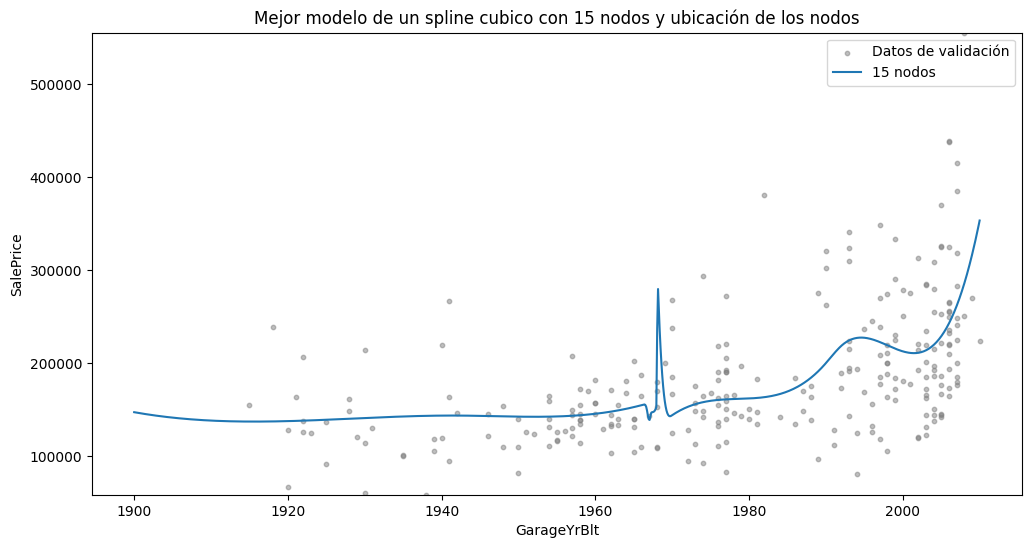

RMSE Promedio Obtenido: 65255.21441646183, 
R2 Promedio Obtenido: 0.30023173565347844


In [ ]:
# Para graficar
plt.figure(figsize=(12, 6))
plt.scatter(X_val, y_val, s=10, color='gray', alpha=0.5, label="Datos de validación")
# Creando el spline final
X_spline = dmatrix(f"bs(X, knots={nodes}, degree=3, include_intercept=False)",
                        {"X": X.ravel()}, return_type='dataframe')
# Inicializar el modelo
model_spline = LinearRegression()
# Obteniendo las métricas finales con validación cruzada
scores = cross_validate(model_spline, X_spline, y, cv=15, scoring=['neg_root_mean_squared_error', 'r2'])
rmse_val = scores['test_neg_root_mean_squared_error'] * -1
r2_val = scores['test_r2']
rmse_final = np.mean(rmse_val)
r2_final = np.mean(r2_val)
# Entrenar el modelo
model_spline.fit(X_spline, y)
# Hacer el gráfico
X_spline_plot = dmatrix(f"bs(X, knots={nodes}, degree=3, include_intercept=False)",
                        {"X": X_plot.ravel()}, return_type='dataframe')
y_spline_plot = model_spline.predict(X_spline_plot)
plt.plot(X_plot, y_spline_plot, label=f"{len(nodes)} nodos")

plt.title('Mejor modelo de un spline cubico con 15 nodos y ubicación de los nodos')
plt.xlabel('GarageYrBlt')
plt.ylabel('SalePrice')
plt.legend()
plt.ylim(min(y_val), max(y_val))
plt.show()

print(f"RMSE Promedio Obtenido: {rmse_final}, \nR2 Promedio Obtenido: {r2_final}")

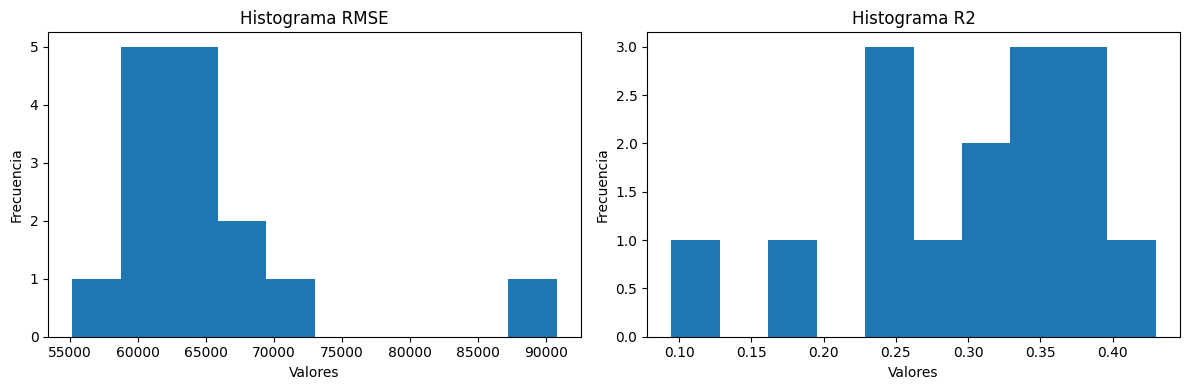

In [ ]:
# Crear los histogramas
plt.figure(figsize=(12, 4))
# Histograma 1
plt.subplot(1, 2, 1)  # Subplot 1 de 1 fila y 2 columnas
plt.hist(rmse_val)
plt.title('Histograma RMSE')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
# Histograma 2
plt.subplot(1, 2, 2)  # Subplot 2
plt.hist(r2_val)
plt.title('Histograma R2')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
# Ajustar espaciado entre subplots
plt.tight_layout()
# Mostrar los histogramas
plt.show()

El mejor modelo de spline cúbico, construido con 15 nodos en las siguientes ubicaciones:

(1967.9837387624884, 1967.9837387624884, 1967.1631573171671, 1969.9948250676248, 1966.695185079537, 1968.1130453907433, 1942.0162612375116, 1968.0924357078484, 1992.1995419037605, 1966.2797984465876, 1967.27169197325, 1967.420091912198, 1989.7887082550642, 1967.175141008322, 1966.8448115539231)

En el conjunto de entrenamiento:
- RMSE: 66,865.91

En el conjunto de validación:
- RMSE: 59,987.45
- R2: 0.29

En el conjunto total
- RMSE: 65,255.21
- R2: 0.3

El hecho de que el modelo tenga un RMSE más bajo en el conjunto de validación en comparación con el conjunto de entrenamiento es una señal positiva, ya que indica que el modelo no está sobreajustando los datos de entrenamiento. A pesar de no tener un R2 muy alto, el modelo todavía muestra una capacidad apreciable para explicar la variabilidad en los datos, lo que sugiere que puede ser útil en tareas de predicción.

Con un RMSE de alrededor de 65,255.21 en el conjunto total, el modelo tiene un rendimiento aceptable en la predicción de valores en nuevos datos, lo que puede ser beneficioso para aplicaciones prácticas. Estos resultados ofrecen una base sólida para trabajar y mejorar el modelo de spline cúbico, ya que existen oportunidades para ajustar sus parámetros y técnicas para obtener un mejor rendimiento, especialmente en términos de reducción del error y mejora del ajuste.


## Kernel

### Modelo 1

A continuación, presentamos uno de nuestros modelos finales y los mejores parámetros a los que llegamos durante el proceso de optimización mediante busqueda en grilla y haciendo una técnica de feature selection:
- Ancho de la ventana (alpha) = 0.5,
- gamma = 0.1,
- kernel ='laplacian'

Es importante recordar que el kernel laplaciano se define de la siguiente manera:

$k(x,y)=exp(-\gamma \left \| x-y \right \|)$

Donde $x$ y $y$ son vectores de entrada y $\left \| x-y \right \|$ es la distancia Manhattan entre los vectores.

Las métricas finales obtenidas para el Modelo 1 final son las siguientes:
- Error de raíz cuadrada media: 30234.64
- R2: 0.82

In [ ]:
# Entrenamos el modelo final, con los hiperparametros tuneados.
kernel_ridge = KernelRidge(alpha= 0.5, gamma = 0.1, kernel ='laplacian') # Aqui se cambia

# Entrenamos el modelo con los datos de entrenamiento.
kernel_ridge.fit(X_train[campos], y_train)

# Hacemos predicciones en el conjunto de prueba.
predictions = kernel_ridge.predict(X_test[campos])

# Evaluamos el rendimiento del modelo utilizando el error de raíz cuadrada media (RMSE).
mse = mean_squared_error(y_test, predictions)
print("Error de raíz cuadrada media: {:.2f}".format(np.sqrt(mse)))

r2 = r2_score(y_test, predictions)
print("R2: {:.2f}".format(r2))

Error de raíz cuadrada media: 30629.73
R2: 0.81


Para verificar las métricas obtenidas y evaluar la robustez del modelo, llevaremos a cabo la validación cruzada y utilizaremos la técnica de bootstrap.

R2 promedio: 0.71
Desviación estándar de la R2: 0.26


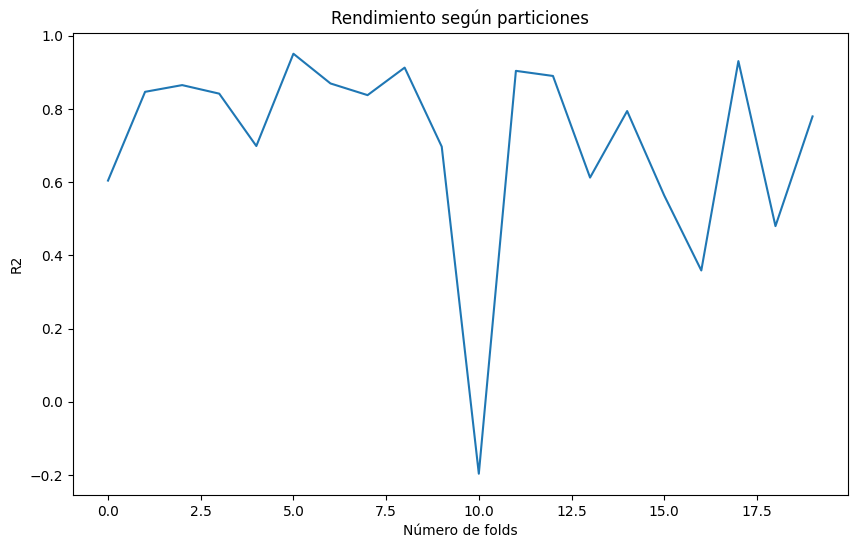

In [ ]:
# Se utiliza crossvalidation para comprobar las metricas obtenidas:
cv_scores = cross_val_score(kernel_ridge, X_test[campos], y_test,
                            cv=20,
                            scoring="r2",
                            n_jobs = -1)
round(np.mean(cv_scores),3)

print(f"R2 promedio: {cv_scores.mean():.2f}")
print(f"Desviación estándar de la R2: {cv_scores.std():.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.title('Rendimiento según particiones')
plt.xlabel('Número de folds')
plt.ylabel('R2')
plt.plot(cv_scores)
plt.show()

Se observa que la métrica R² es consistente en diferentes Folds, con un promedio de 0.73 en R². Aunque la desviación estándar es un poco alta (0.26), gran parte de esta variabilidad se debe a una sola partición (número de folds en 10) en la que el conjunto de datos no logra obtener una métrica óptima. En términos generales, los resultados sugieren que el modelo es consistente y tiende a explicar aproximadamente el 73% de la variabilidad en los datos de prueba, lo que indica un buen ajuste a los datos en la mayoría de las particiones.

RMSE promedio: 30855.79
Desviación estándar de la RMSE: 12952.99


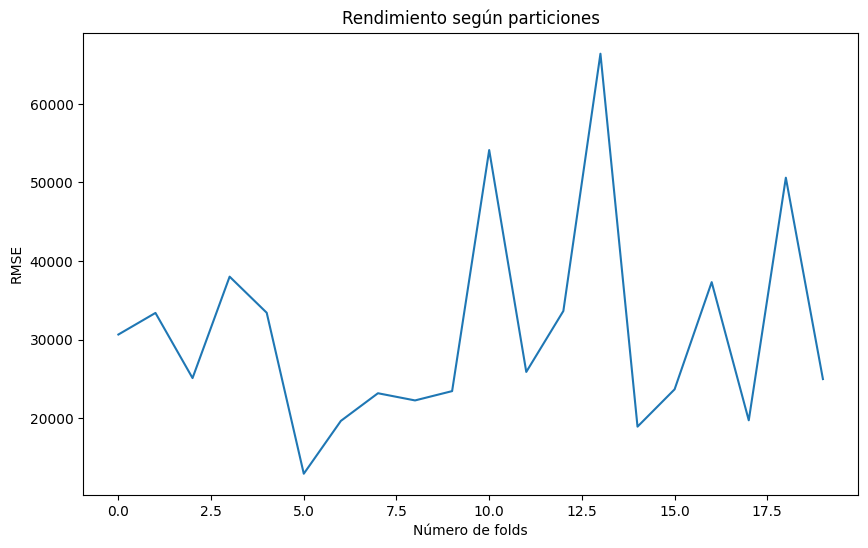

In [ ]:
cv_scores = cross_val_score(kernel_ridge, X_test[campos], y_test,
                            cv=20,
                            scoring="neg_root_mean_squared_error",
                            n_jobs = -1)
round(-1*np.mean(cv_scores),3)

print(f"RMSE promedio: {-1*cv_scores.mean():.2f}")
print(f"Desviación estándar de la RMSE: {cv_scores.std():.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.title('Rendimiento según particiones')
plt.xlabel('Número de folds')
plt.ylabel('RMSE')
plt.plot(-1*cv_scores)
plt.show()

El RMSE promedio obtenido al realizar particiones con distintos números de folds es de 29,856.54, lo cual puede considerarse un valor positivo. Es importante destacar que, al inicio, al seleccionar las mejores características, estábamos obteniendo RMSE en un rango entre 30,000 y 36,000. Sin embargo, es relevante mencionar que estamos observando una desviación estándar de 12,788.56, la cual podría considerarse relativamente alta. Esto se debe a que, como podemos apreciar en la gráfica, en algunos números de folds, particularmente en 3 particiones, estamos obteniendo RMSE significativamente elevados.

---



Ahora, realicemos bootstrap para evaluar la robustez de nuestro modelo.

In [ ]:
from sklearn.utils import resample

# Número de repeticiones del bootstrap
n_iterations = 1000

# Almacena las métricas de interés para cada iteración
rmse_scores = []
r2_scores = []
# Almacena las predicciones para cada iteración
predictions_bootstrap = []

# Realiza el bootstrap y evalúa el modelo en cada iteración
for _ in range(n_iterations):
    # Muestreo bootstrap del conjunto de prueba
    X_boot, y_boot = resample(X_test[campos], y_test)

    # Realiza predicciones en el conjunto de prueba bootstrap
    predictions_boot = kernel_ridge.predict(X_boot)

    # Almacena las predicciones
    predictions_bootstrap.append(predictions_boot)

    # Calcula el error cuadrático medio (RMSE) y guárdalo en la lista
    rmse = np.sqrt(mean_squared_error(y_boot, predictions_boot))
    rmse_scores.append(rmse)

    # Calcula el R2
    r2 = r2_score(y_boot, predictions_boot)
    r2_scores.append(r2)

# Calcula los percentiles para obtener el intervalo de confianza (por ejemplo, 95%)
lower_bound = np.percentile(rmse_scores, 2.5)
upper_bound = np.percentile(rmse_scores, 97.5)

print(f"Intervalo de Confianza del RMSE: [{lower_bound:.2f}, {upper_bound:.2f}]")


# Calcula los percentiles para obtener el intervalo de confianza (por ejemplo, 95%)
lower_bound_r2 = np.percentile(r2_scores, 2.5)
upper_bound_r2 = np.percentile(r2_scores, 97.5)

print(f"Intervalo de Confianza del R2: [{lower_bound_r2:.2f}, {upper_bound_r2:.2f}]")


Intervalo de Confianza del RMSE: [20751.66, 45273.77]
Intervalo de Confianza del R2: [0.57, 0.92]


Se aplicó la técnica de Bootstrap para calcular los intervalos de confianza de las dos métricas. Los resultados revelan que, en el caso del R², se puede estar seguro con un nivel de confianza del 95% de que estará en un rango desde un mínimo del 63% hasta un máximo del 92%. Estos valores se consideran aceptables para la solución.

Asimismo, en cuanto al RMSE, los resultados son consistentes con las observaciones anteriores, mostrando un valor mínimo de 20,346.45 y un máximo de 42,119.92, lo que proporciona una estimación confiable de la variabilidad del error en las predicciones.

### Comparación Modelo 1 y Modelo 2

A continuación, presentamos las conclusiones finales al realizar la comparación de los dos modelos kernel planteados:

1. Con el Modelo 2, hemos logrado mejorar el valor de $R^2$ en el caso del kernel laplaciano, alcanzando un impresionante 0.85. No obstante, es importante tener en cuenta que este rendimiento se ha obtenido al utilizar todas las 99 variables disponibles, tanto las numéricas como las categóricas. Por lo tanto, puede ser beneficioso considerar la opción de sacrificar dos puntos porcentuales de $R^2$ al obtener un valor de 0.83, pero aplicando este rendimiento al Modelo 1, que solo utiliza 29 variables. Este enfoque brindaría ventajas significativas en cuanto a interpretabilidad del modelo y una reducción considerable en los costos computacionales.

2. Sería valioso considerar la posibilidad de investigar en el futuro un enfoque de limpieza de datos diferente, específicamente la eliminación de valores atípicos. Hemos observado que esta modificación puede tener un impacto significativo en la mejora de las métricas de rendimiento del modelo. Esto se evidenció cuando nuestro colega, Diryon, realizó una limpieza de datos adicional, eliminando los valores atípicos y logrando un impresionante 86% de $R^2$ con el kernel laplaciano. Lamentablemente, debido a restricciones de tiempo, no pudimos implementar esta modificación para este cuaderno de trabajo, pero podría ser una dirección prometedora para futuros proyectos.

In [ ]:
%%shell
jupyter nbconvert --to html /content/AAD2_final.ipynb

[NbConvertApp] Converting notebook /content/AAD2_final.ipynb to html
[NbConvertApp] Writing 6070393 bytes to /content/AAD2_final.html
